# Understanding Cosmic Muons Through Simulation

## 0 - Imports and setup

In [2]:
# ensuring the setup has the latest version of numba and tbb
import sys
!{sys.executable} -m pip install --upgrade numba
!{sys.executable} -m pip install --upgrade tbb

import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# sampling random variables
import random

# integrating and data analysis
from scipy.integrate import quad as quad_int
from scipy.optimize import curve_fit
from scipy.stats import chisquare, chi2


# progress bars
from tqdm.autonotebook import tqdm

# optimisation
import numba
import warnings

# time
import time

# Ignore numpy deprecation warnings
warnings.simplefilter(action = 'ignore', category=DeprecationWarning)
warnings.simplefilter(action = 'ignore', category=numba.errors.NumbaPendingDeprecationWarning)
print('\nNumba version:',numba.__version__) # should be 0.55 or greater

     |████████████████████████████████| 3.3 MB 8.7 MB/s 
     |████████████████████████████████| 34.5 MB 5.1 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
     |████████████████████████████████| 4.0 MB 24.8 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



Numba version: 0.55.1


In [3]:
# set seed for random numbers for reproducability
random.seed(111)

## 1 - Constants

In [4]:
# Global constants
# S_0 for the energy loss approximation.
S_0 = 2.0 # MeV cm^2/g (= MeV per (g/cm^3) per cm)

# Properties of air (dry, 1 atm) - https://pdg.lbl.gov/2021/AtomicNuclearProperties/HTML/air_dry_1_atm.html
air_properties = {}
air_properties['I'] = 85.7e-6 # MeV 
air_properties['Z/A'] = 0.49919 # mol/g
air_properties['density'] = 1.204e-3 # g/cm^3
air_properties['d_0'] = 0.00
air_properties['x_0'] = 1.7418
air_properties['x_1'] = 4.2759
air_properties['C_bar'] = 10.5961
air_properties['a'] = 0.10914

# Speed of light
c_ms = 2.99792458*10**8 # m/s
c_cms = 2.99792458*10**10 # cm/s

# Muon lifetimes
#tau_minus = 1.043E-6 # s # exaggerated
tau_plus = 2.1969811E-6 # s

cap_rate = 6.57E3 # s^-1

tau_minus = 1/(cap_rate + 1/tau_plus) # 2.17e-06

#cap_rate = 1/tau_minus - 1/tau_plus # muon capture rate
tau_cap = 1/cap_rate

# Cosmic muon charge ratio
charge_ratio = 1.2766
P_muon = 1/(charge_ratio + 1) # 0.439 -- prob of producing a mu-

# muon and electron mass
m_mu = 105.6583755 # MeV/c^2
m_e = 0.510999 # MeV/c^2

## 2 - Classes and functions

### 2.1 - Muons

#### 2.1.1 - Muon property functions

In [6]:
## Generate muon type
def sample_exp(Lambda):
    '''
    Samples a single number from the exponential distribution given the rate parameter
    lambda using the inverse transform method.

    Arguments
    ---------
    Lambda (float) - The rate parameter of the exponential distribution.
    '''
    x = random.uniform(0.0, 1.0)
    return (-1/Lambda)*np.log(1 - x)

def muon_type(prob_muon):
    '''
    Determines whether the current muon is a mu+ or mu- using P(mu-) = prob_muon.
    This is sampled by simply generating a uniformly distributed random variable 
    and checking if it is larger than prob_muon. Returns the lifetime in matter 
    of the mu+/-.


    Arguments
    ---------
    prob_muon (float) - The probability of generating a mu- (must be between 0.0
                        and 1.0).
    '''
    
    # note rate parameter is 1/mean = 1/lifetime
    if prob_muon > random.uniform(0.0, 1.0):
        #lifetime = sample_exp(1/1.043E-6) # negative muon lifetime = 1.04E-6 s
        lifetime = sample_exp(1/tau_minus) # negative muon lifetime = 1.04E-6 s
    else:
        lifetime = sample_exp(1/tau_plus) # positive muon lifetime = 2.1969811E-6 s
    # no need to return charge - simulation is only dependent upon charge^2
    
    return lifetime

In [7]:
## Generate zenith angle
# Defining our distributions
def cos2_P(phi):
    return (4/np.pi)*(np.cos(phi))**2

# sin^2 distribtion - used in place of the cos^2 distribution due to a typo made
# when determining the distance to the detector, causing the trigonometry to be
# used throughout to consider the angle generated by this distribution (from the
# horizontal to the muons path) rather than the one generated by the cos^2 distribution.
    # this is a quick fix - a better change would be to change the trigonoemtery 
    # to ensure it is correct.
#def sin2_P(phi):
#    return (4/np.pi)*(np.sin(phi))**2

def cos2_F(phi):
    return (1/np.pi)*(np.sin(2*phi) + 2*phi)

# Sampling
def vN_sample(pdf, domain = [0, np.pi/2], range = [0, 4/np.pi], norm = 1):
    '''
    Produces a single sample point via the von Neuman rejection method. Always
    results in a single point being produced, which may require multiple loops
    if points are rejected.

    Arguments
    ---------
    pdf (function) - The probability density function to be sampled. should take
                     a single argument (i.e., in the form p.d. = f(x)).
    domain (list/tuple) - The domain of the pdf to be sampled, in the form 
                          [xmin, xmax].
    range (list/tuple) - Range of the pdf to be sampled in the form [ymin, ymax].
    norm (float) - Optional normalisation constant for the pdf.
    '''
    
    while True:
        x = random.uniform(domain[0], domain[1])
        y = random.uniform(range[0], range[1])

        if y < pdf(x)/norm:
            return x

# Angle sampling - defining so that each generation function is of a consistent form
# AK you might consider importance sampling here to speed things up (maybe use saw tooth instead of uniform?), 
def sample_zenith():
    '''
    Uses the von_Neumann sampling method to sample the cos^2 distribution to produce
    a muon zenith angle.
    '''
    return vN_sample(cos2_P, domain = [0, np.pi/2], range = [0, cos2_P(0)])

In [8]:
# Energy sampling
def E_detailed_flux(E, Ec = 1000):
    '''
    Uses equation (2) from Shukla et al. to generate the normalised flux of muons 
    at a given momentum. Paper available here: https://arxiv.org/pdf/1606.06907.pdf

    E - (float) energy of the muon in MeV.
    Ec - (float) the maximum energy a muon may be produced with in MeV.
    '''

    # note: equation only valid for E > 500 MeV
    # currently no better distribution has been found.

    #AK better to provide detailed ref here
    # using the data from Table 1 row 2 (Durham, UK data)
    I0 = 72.5e-4 # cm^-2s^-1sr^-1
    n = 3.06 # no units
    E0 = 3.87e3 # MeV
    eps = 854e3 # MeV

    N = (n-1)*(E0 + Ec)**(n-1)

    # note - returns itensity --> proportional to prob, but needs normalising.
    # must use a numerical integration technique to normalise for sampling.

    return I0 * N * (E0 + E)**(-n) * (1 + E/eps)**-1

# Energy sampling
def E_detailed_prob(E):
    '''
    Uses equation (2) from Shukla et al. to generate the non-normalised flux of
    muons at a given momentum. May be normalised through integration between the
    energy limts of the simulation to obtain the p.d.f. of energies in the simulation. 
    Paper available here: https://arxiv.org/pdf/1606.06907.pdf.
        - note: equation only valid for E > 500 MeV

    E - (float) energy of the muon in MeV.
    '''

    # 
    # currently no better distribution has been found.

    #AK better to provide detailed ref here
    # using the data from Table 1 row 2 (Durham, UK data)
    I0 = 72.5e-4 # cm^-2s^-1sr^-1
    n = 3.06 # no units
    E0 = 3.87e3 # MeV
    eps = 854e3 # MeV

    # note - returns itensity --> proportional to prob, but needs normalising.
    # must use a numerical integration technique to normalise for sampling.

    return I0 * (E0 + E)**(-n) * (1 + E/eps)**-1

def sample_momentum(lower, upper, norm = None):
    '''
    Samples the detailed energy distribution for muon energy using the inverse
    transform method. Returns a muon momentum within the specified bounds in units
    of MeV/c

    Arguments
    ---------
    lower (float) - The lower bound of muon momentum in MeV/c.

    upper (float) - The upper bound of muon momentum in MeV/c.

    norm (float) - The normalisation constant for the detailed energy distribution.
                   If not specified, will calculate the norm manually using numerical
                   integration.
    '''

    # More detailled energy distribution - note: only valid for E > 0.5GeV
    # from https://arxiv.org/abs/1606.06907 eq (2)
    if type(norm) != float:
        norm, _ = quad_int(E_detailed_prob, lower, upper)
    
    return vN_sample(E_detailed_prob, domain = [lower, upper], range = [0, E_detailed_prob(lower)/norm], norm = norm)

In [9]:
# Generating muons on the generation plane
        #AK note that the extra radius will limit the angular range reaching the detector, 3 is arbitrary and too small
def generate_position(plane,coords='cartesian'):
    '''
    Generates the initial muon position as a point on a circular plane above the
    detector. Returns the coordinates of the initial point in either cylindrical
    (radius, angle, height), or cartesian (x, y, z).

    Arguments
    ---------
    plane (muon_plane) - The plane upon which the muon will be generated.
    coords (string) - The coordinates to return the result in. Must be either
                      'cartesian' or 'cylindrical'.
    '''
    # generate the cylindrical coordinates
    rad = plane.radius*np.sqrt(random.uniform(0, 1))
    angle = random.uniform(0,2*np.pi)
    height = plane.z # height relative to the bottom of the detector

    cyl = np.array([rad, angle, height])

    if coords == 'cylindrical':
        return cyl

    elif coords == 'cartesian':
        # convert to cartesian
        cart = np.array([cyl[0]*np.cos(cyl[1]), # x
                        cyl[0]*np.sin(cyl[1]), # y
                        cyl[2]]) # z
        return cart
    else:
        raise ValueError("invalid value for coords. Input either 'cylindrical' or 'cartesian'.")


In [10]:
def generation_time(rate, last_t):
    '''
    Produces a time of generation for the particle, relative to the time of generation.

    Arguments
    ---------
    rate - (float) the rate of production of the particle, given in s^-1
    last_t - (float) the last generation time produced from this source of particles
    '''
    return last_t + sample_exp(rate)

In [11]:
def gamma(velocity, units = 'cm'):
    '''Calculate the Lorentz factor for a given velocity'''
    # determine the units of the speed of light we should use
    if units == 'cm':
        c = c_cms # speed of light in cm/s
    elif units == 'm':
        c = c_ms # speed of light in m/s
    else:
        raise KeyError("Invalid length unit. Please provide velocity in units of cm/s (with units = 'cm') or m/s (with units = 'm')")
    
    return 1/np.sqrt(1 - (velocity/c)**2)


In [12]:
def Bethe_Bloch(material,v, multi_return = False):
    '''
    Calculates the value of dE/ds using the Bethe-Bloch formula. Assumes the 
    particle being considered is a muon/antimuon (z = ±1, M = 105.658 MeV).

    Arguments
    ---------
    Z (int) - The atomic number of the material.
    A (int) - The atomic mass of the material.
    I (float) - The mean excitation potential of the material in eV.
    density (float) - The density of the material in g/cm^3.
    v (float) - The velocity of the particle in cm/s.
    ZoverA (float) - Optional value of Z/A for mixtures such as air where the value
                     of Z and A are not clear, so alternate data must be used.
                     Use of this parameter will override any values provided for
                     Z and A.
    '''

    # Extract all the properties of the material from the dict
    if len(material) == 9:
        ZoverA = material['Z']/material['A']
        Z = material['Z']
    elif len(material) == 8:
        ZoverA = material['Z/A']
        Z = 0.1 # for checking if the material is a conductor
    else:
        # if we don't have 7 entries, we can't do Bethe-Bloch.
        print(material)
        raise AttributeError('Not enough properties of material specified')
    I = material['I'] # MeV
    density = material['density'] # g/cm^3
    d_0 = material['d_0'] # unitless
    x_0 = material['x_0'] # unitless
    x_1 = material['x_1'] # unitless
    C_bar = material['C_bar'] # unitless
    a = material['a'] # unitless

    beta = v/c_cms # unitless
    gamma = 1/np.sqrt(1-beta**2) # unitless
    x = np.log10(beta*gamma) # unitless

    pre_factor = -0.307075 * ZoverA / (beta**2) # K approx= 0.307075 MeV mol^-1 cm^2, Z/A has units of mol g^-1 --> units = MeV g^-1 cm^2

    W_max = 2*m_e*(c_ms*beta*gamma)**2/(1 + 2*gamma*m_e/m_mu + (m_e/m_mu)**2)

    # logarithmic term
    ln_term = np.log( (2*m_e*(c_ms*beta*gamma)**2 * W_max)/I**2 )

    # density term (Sternheimer paramterisation)
    if x >= x_1:
        dens_term = 2*np.log(10) * x - C_bar
    elif x >= x_0:
        dens_term = 2*np.log(10) * x - C_bar + a*(x_1 - x)
    else:
        if Z == 13:
            # Al is the only conductor in our simulation. If more are added this will have to be etended.
            dens_term = d_0 * 10**(2*(x - x_0)) # x < x_0
        else:
            dens_term = 0

    res = density*pre_factor * (0.5*ln_term - beta**2 - dens_term/2)

    if res != res:
        print('W_max:',W_max)
        print('ln term:',ln_term)
        print('gamma:', gamma)
        print('velocity:', v)
        print('beta:', beta)
        raise ArithmeticError('Energy change is not a number :(')
    
    if multi_return:
        return res, density*pre_factor*ln_term, density*pre_factor*dens_term/(2*beta**2)
    
    return res

In [13]:
def gen_azimuth(mu_position, det_positions, zenith):
    '''
    Generates an azimuthal angle for the muon's velocity such that it will definitely
    hit one of the given detectors.

    Arguments
    ---------
    mu_position (tuple) - The position of the muon in the format (x,y,z).
    det_positions (list) - List of detector positions in the format (x,y,z).
    zenith (float) - The zenith angle of the muon's velocity (between -ve z and
                     the muon's path).
    '''
    for det_pos in det_positions:
        x0 = mu_position[0] - det_pos[0]
        r0 = np.sqrt(())


#### 2.1.2 - Parallelised muon property functions

In [14]:
@numba.jit(parallel = True, nopython = True)
def muon_type_parallel(prob_muon, n_events = 1000):
    '''
    Parallel version of muon_type().
    Determines whether the current muon is a mu+ or mu- using P(mu-) = prob_muon.
    This is sampled by simply generating a uniformly distributed random variable 
    and checking if it is larger than prob_muon. Returns the corresponding charge
    and lifetime in matter of the mu+/-.


    Arguments
    ---------
    prob_muon (float) - The probability of generating a mu- (must be between 0.0
                        and 1.0).
    '''
    #charges = np.empty(n_events, dtype = np.int64)
    lifetimes = np.empty(n_events, dtype = np.float64)

    for i in numba.prange(n_events):
        if prob_muon > random.uniform(0.0, 1.0):
            lifetimes[i] = (-tau_minus)*np.log(1 - random.uniform(0.0, 1.0))
            #charges[i] = -1

        else:
            lifetimes[i] = (-tau_plus)*np.log(1 - random.uniform(0.0, 1.0))
            #charges[i] = 1
    
    #return charges, lifetimes
    return lifetimes

In [15]:
@numba.jit(parallel = True, nopython = True)
def sample_zenith_parallel(n_events = 1000):
    '''
    Parallel version of sample_zenith().
    Uses the von_Neumann sampling method to sample the cos^2 distribution to produce
    a muon zenith angle.
    '''
    zeniths = np.empty(n_events, dtype = np.float64)

    for i in numba.prange(n_events):
        while True:
            x = random.uniform(0, np.pi/2)
            y = random.uniform(0, 4/np.pi)

            if y < (4/np.pi)*(np.cos(x))**2:
                zeniths[i] = x
                break
    
    return zeniths


In [16]:
@numba.jit(parallel = True, nopython = True)
def sample_azimuth_parallel(n_events = 1000):
    '''
    Parallel sampling of the azimuthal angle (uniform sampling).
    '''
    azimuths = np.empty(n_events, dtype = np.float64)

    for i in numba.prange(n_events):
        azimuths[i] = random.uniform(0, 2*np.pi)
    
    return azimuths

In [17]:
@numba.jit(parallel = True, nopython = True)
def sample_energy_parallel(p_min, p_max, norm, n_events = 1000):
    '''
    Parallel version of sample_momentum(). Converts to kinetic energy automatically.
    Samples the detailed energy distribution for muon energy using the inverse
    transform method. Returns a muon momentum within the specified bounds in units
    of MeV/c.

    Arguments
    ---------
    p_min (float) - The lower bound of muon momentum in MeV/c.

    p_max (float) - The upper bound of muon momentum in MeV/c.

    norm (float) - The normalisation constant for the detailed energy distribution.
    '''

    # More detailled energy distribution - note: only valid for E > 0.5GeV
    # from https://arxiv.org/abs/1606.06907 eq (2)

    # parameters of the energy distribution
    I0 = 72.5 # m^-2s^-1sr^-1
    n = 3.06 # no units
    E0 = 3.87e3 # MeV
    eps = 854e3 # MeV

    y_max = I0*(E0 + p_min)**(-n)*(1 + p_min/eps)**(-1) / norm
    
    energies = np.empty(n_events, dtype = np.float64) # could use float 32?
    
    for i in numba.prange(n_events):
        while True:
            x = random.uniform(p_min, p_max)
            y_x = (I0 * (E0 + x)**(-n) * (1 + x/eps)**-1 / norm)

            y = random.uniform(0, y_max)
            if y < y_x:
                g = np.sqrt(1 + ((x)/m_mu)**2)

                energies[i] = (g-1)*m_mu

                break

    return energies


In [18]:
@numba.jit(parallel = True, nopython = True)
def generate_position_parallel(plane_radius, n_events = 1000):
    '''
    Parallel version of generate_position().
    Generates the initial muon position as a point on a circular plane above the
    detector. Returns the coordinates of the initial point in cartesian (x, y, z).

    Arguments
    ---------
    plane (muon_plane) - The plane upon which the muon will be generated.
    coords (string) - The coordinates to return the result in. Must be either
                      'cartesian' or 'cylindrical'.
    '''
    # storing x and y - z may be obtained from the plane height.
    xy_coords = np.empty((n_events,2), dtype = np.float64) 

    for i in numba.prange(n_events):
        # generate the cylindrical coordinates
        rad = plane_radius*np.sqrt(random.uniform(0, 1))
        angle = random.uniform(0,2*np.pi)

        # convert to cartesian
        xy_coords[i][0] = rad*np.cos(angle) # x
        xy_coords[i][1] = rad*np.sin(angle) # y
    
    return xy_coords

In [19]:
@numba.jit(parallel = True, nopython = True)
def generation_time_parallel(rate, last_t, n_events = 1000):
    '''
    Produces a time of generation for the particle, relative to the time of generation.

    Arguments
    ---------
    rate (float) - The rate of production of the particle, given in s^-1
    last_t (float) - The last generation time produced from this source of particles
    '''
    times = np.empty(n_events, dtype = np.float64)
    for i in numba.prange(n_events):
        # using sample_exp (inverse transform)
        times[i] = (-1/rate)*np.log(1 - random.uniform(0.0, 1.0))
    
    # make each time relative to t = 0 rather than the last time of generation.
    return np.cumsum(times) + last_t


#### 2.1.2 - Muon plane and muon

In [20]:
class muon_plane():
    def __init__(self, height, radius, 
                 p_min = 1.0, p_max = 500.0, p_muon = P_muon,
                 n_pre_gen = 1000):
        '''
        Create a circular muon plane at z = height, x = y = 0 with radius = radius.

        Arguments
        ---------
        height (float) - The z coordinate of the muon plane.
        radius (float) - The radius of the muon plane in cm.
        p_min (float) - The minimum momentum generated muons may have in MeV/c
        p_max (float) - The maximum momumtum generated muons may have in MeV/c
        p_muon (float) - The probability of producing a muon rather than antimuon.
        rate (float) - The rate of muon production in mu min^-1 cm^-2 sr^-1.
        n_pre_gen (int) - The number of muons to pre-generate at initialisation.
        '''
        
        # position and size of plane
        self.z = height
        self.x = 0
        self.y = 0
        self.radius = radius

        # prob of producing mu-
        self.p_muon = p_muon

        # energy limits and normalisation
        self.p_min = p_min
        self.p_max = p_max
        self.p_norm, _ = quad_int(E_detailed_prob, p_min, p_max)

        # keeping track of the last generation time
        self.last_t = 0.0 # change to current unix time?
        
        # rate of muon production (per solid angle)
        self.rate_per_sr = np.pi*(radius**2) * quad_int(E_detailed_flux, p_min, p_max, args = p_max)[0]
            # area of generation plate * muon flux over the given energy range(approx 1 mu per cm^2 per min per sr)
            # will be multiplied by the max detectable solid angle range to give the overall flux
        self.rate = self.rate_per_sr*2*np.pi # placeholder - assuming all angles are detectable (not true)

        self.pre_gen_i = 0
        self.pre_generate(n_events = n_pre_gen)

    
    def pre_generate(self, n_events = 1000):
        '''
        Samples the distributions required to generate a muon in parallel, allowing
        acceleration of the simulation. Stores only the variables that must be
        randomly sampled (lifetime, zenith, azimuth, energy and position).


        Arguments
        ---------
        n_events (int) - The number of muons to prepare.
        '''
        # Pre-generate properties
        self.pre_gen_data = {}
        #self.pre_gen_data['charges'], self.pre_gen_data['lifetimes'] = muon_type_parallel(self.p_muon, n_events)
        self.pre_gen_data['lifetimes'] = muon_type_parallel(self.p_muon, n_events)
        self.pre_gen_data['zeniths'] = sample_zenith_parallel(n_events)
        self.pre_gen_data['azimuths'] = sample_azimuth_parallel(n_events)
        self.pre_gen_data['energies'] = sample_energy_parallel(self.p_min, self.p_max, self.p_norm, n_events)
        self.pre_gen_data['positions'] = generate_position_parallel(self.radius, n_events)
        self.pre_gen_data['gen_times'] = generation_time_parallel(self.rate, self.last_t, n_events)

        # update counter
        self.pre_gen_i = 0



    def gen_muon(self, use_pre_gen = True, n_pre_gen = 1000):
        '''
        Generate a single muon on the plane. By default will use pre-generated
        values if any are present, or will generate some if none are present.
        Optionally, if use_pre_gen is set to False, a muon will be generated 
        without pre-sampling using the parallelised functions.

        Arguments
        ---------
        use_pre_gen (bool) - If False, will generate a muon by sampling its
                             properties using the non-parallelised functions.
                             Otherwise, will use pre-generated data to generate
                             the muon. If no pre-generated data is available but
                             use_pre_gen == True, more data will be genereated
                             using muon.pre_generate().
        n_pre_gen (int) - The number of events to pre-generate if pre-generation
                          is required.
        '''
        if use_pre_gen:
            if self.pre_gen_i == len(self.pre_gen_data['lifetimes']):
                #print('len data = ',len(self.pre_gen_data['lifetimes']))
                # if we have no pre-generated data, make some more
                self.pre_generate(n_pre_gen)
            
            mu = muon(self, 
                      #charge = self.pre_gen_data['charges'][self.pre_gen_i],
                      lifetime = self.pre_gen_data['lifetimes'][self.pre_gen_i],
                      zenith = self.pre_gen_data['zeniths'][self.pre_gen_i],
                      azimuth = self.pre_gen_data['azimuths'][self.pre_gen_i],
                      energy = self.pre_gen_data['energies'][self.pre_gen_i],
                      xy_position = self.pre_gen_data['positions'][self.pre_gen_i],
                      gen_time = self.pre_gen_data['gen_times'][self.pre_gen_i])
            
            # update last_t
            self.last_t = self.pre_gen_data['gen_times'][self.pre_gen_i]
            self.pre_gen_i += 1
            
        else:
            # using non-pregenerated data if requested
            mu = muon(self)

            self.last_t += sample_exp(self.rate)

        return mu

In [21]:
class muon():
    '''
    Generates a single muon with all of the required properties for the simulation.
    For descriptions of the distributions of each function, see the docstrings of
    each helper function.

    Attributes
    ----------
    lifetime (float) - The lifetime (in s) of the muon/antimuon.
        - Both of these attributes are generated using the function muon_type()
    zenith (float) - The zenith approach angle (in radians) of the muon.
        - Generated using the function sample_zenith()
    energy (float) - the energy of the muon in MeV. Ranges from Emin to Emax.
        - Generated using the function sample_momentum(), then converted to kinetic
          energy.
    path_len (float) - the path length (in cm) of the muon from generation to detection.
                       If the muon does not stop within the detector, will be set
                       to np.nan.
    position (tuple of 3 floats) - the distance (in cm), azimuthal (x-y) angle
                                   (in radians) and height (in cm) of the muon
                                   all relative to (0,0,0) - the centre of the
                                   bottom of the detector.
        - Radius, azimuth and height generated using generate_position()
    '''

    def __init__(self, plane, # charge=None, 
                 lifetime=None, zenith=None, azimuth=None, energy=None, 
                 xy_position=None, gen_time=None):
        '''
        Initialise the muon. Sets each of the properties of the muon according to
        each observed distribution. The properties are described in the class docstring
        (help(muon)). For descriptions of each variables distribution, see the docstrings
        of each generation helper function. Properties may optionally be specified
        at initialisation (either for testing or if variables have been pre-sampled)

        Arguments
        ---------
        detector (detector) - the detector used in the simulation.
        prob_muon (float) - the probability of producing a muon (as opposed to an
                            anti-muon). The type of muon produced defines its charge
                            and the lifetime.
        Emin (float) - the lower bound of muon energy in MeV.
        Emax (float) - the upper bound of muon energy in MeV.
        mu_height (float) - the height (in cm) above the detector of the muon generation
                            plane.
        mu_rad (float) - the radius (in cm) of the muon generation plane.
        last_t (float) - the time of generation of the previous generated muon.
        '''
        # Generate muon charge and lifetime (in muon rest frame)
        if type(lifetime) == type(None):
            #self.charge, self.lifetime = muon_type(plane.p_muon)
            self.lifetime = muon_type(plane.p_muon)
        else:
            #self.charge = charge
            self.lifetime = lifetime

        # Angles of muon momentum - independent of detector coords
        if (type(zenith) == type(None)):
            self.zenith = sample_zenith() 
            # Note this is the angle from the negative z axis to the x-y plane 
            # they are generated on (i.e., muons all travel downwards)
        else:
            self.zenith = zenith
        
        if (type(azimuth) == type(None)):
            self.azimuth = random.uniform(0,2*np.pi) # relative to x
        else:
            self.azimuth = azimuth

        # Energy (note, not total energy - kinetic energy)
        if (type(energy) == type(None)):  
            momentum = sample_momentum(lower = plane.p_min, upper = plane.p_max, norm = plane.p_norm) # MeV/c

            self.gamma = np.sqrt((momentum/m_mu)**2 + 1) # lorentz factor

            self.energy = (self.gamma - 1)* m_mu # T = (gamma - 1)mc^2
        else:
            self.energy = energy # kinetic energy

            self.gamma = energy/(m_mu) + 1

        self.velocity = c_cms*np.sqrt(1 - 1/self.gamma**2) # velocity in cm/s

        # Distance travelled from generation
        self.path_len = 0.0

        # Generate the initial cartesian coordinates
        if (type(xy_position) == type(None)):
            self.position = generate_position(plane) # (x, y, z)
        else:
            self.position = np.append(xy_position, plane.z)
    
        # produce the time of generation, relative to the first muon generation
        self.gen_time = plane.last_t # obtain t_g using exponential dist.

    

    def y(self, value, coord = 'x'):
        '''
        Returns the y coordinate of a point on the muons path given either the x
        or z coordinate.

        Arguments
        ---------
        value (float/array of floats) - the value of the specified coordinate
        coord (string) - name of the coordinate specified (either 'x' or 'z')
        '''

        # initial position
        x0, y0, z0 = self.position

        if self.azimuth == np.pi:
            return y0

        if coord == 'x':
            return y0 + (value - x0) * np.tan(self.azimuth)
        else:
            return y0 + (z0 - value) * np.tan(self.zenith) * np.sin(self.azimuth)


    def z(self, value, coord = 'x'):
        '''
        Returns the z coordinate of a point on the muons path given either the x
        or y coordinate. 

        Arguments
        ---------
        value (float/array of floats) - the value of the specified coordinate
        coord (string) - name of the coordinate specified (either 'x' or 'y')
        '''

        # initial position
        x0, y0, z0 = self.position

        # if zenith = 0, the height will not change as the muon is travelling horizontally
        if self.zenith == 0.0:
            return z0

        if coord == 'x':
            return z0 - (value - x0)/(np.cos(self.azimuth) * np.tan(self.zenith))
        else:
            return z0 - (value - y0)/(np.sin(self.azimuth) * np.tan(self.zenith))

            
    def r_path(self, z, origin = (0,0,0)):
        '''
        Returns the muon's r coordinate (cylindrical coordinates) given a value
        of z. The origin to use may be specified, allowing a detector to be set
        as the origin.

        Arguments
        ---------
        z (float) - The value of z at which to evaluate r.
        origin (tuple) - The position of the new origin of the system. By defualt
                         uses the centre of the muon plane.
        '''
        x0, y0, z0 = self.position

        # position relative to the new origin
        x0d = x0 - origin[0]
        y0d = y0 - origin[1]
        z0d = z0 - origin[2]

        r0 = np.sqrt(x0d**2 + y0d**2)

        alpha = np.pi - np.arcsin(y0d/r0) + self.azimuth

        d = (z0d - z)*np.tan(self.zenith)

        return np.sqrt(r0**2 + d*(d - 2*r0*np.cos(alpha)))
    

    def z_path(self, r, origin = (0,0,0)):
        '''
        Returns the muon's z coordinate (cylindrical coordinates) given a value
        of r. The origin to use may be specified, allowing a detector to be set
        as the origin.

        Arguments
        ---------
        r (float) - The value of r at which to evaluate z.
        origin (tuple) - The position of the new origin of the system. By defualt
                         uses the centre of the muon plane.
        '''

        x0, y0, z0 = self.position

        # position relative to the new origin
        x0d = x0 - origin[0]
        y0d = y0 - origin[1]
        z0d = z0 - origin[2]

        r0 = np.sqrt(x0d**2 + y0d**2)

        alpha = np.pi - np.arcsin(y0d/r0) + self.azimuth
        if r**2 < (r0*np.sin(alpha))**2:
            return np.nan

        return z0d - (r0*np.cos(alpha) - np.sqrt(r**2 - (r0*np.sin(alpha))**2))/np.tan(self.zenith)




    def scint_hit(self, det):
        '''
        Determine if the muon will contact the scintillator of the given detector
        by considering the positions of the two objects and the muons path.

        Note: this algorithm does not account for energy loss so where the muon 
        decays (before entering, inside, or after exiting the scintillator) must
        be determined separately.

        Arguments
        ---------
        det (detector) - the detector to be considered.
        '''
        check = False

        x, y, z = self.position

        # position relative to the new origin
        x0 = x - det.position[0]
        y0 = y - det.position[1]
        z0 = z - det.position[2]

        r0 = np.sqrt(x0**2 + y0**2)

        # special case: muon is travelling directly downwards
        if self.zenith == 0:
            pass
        
        # special case: muon is located at (0,0)
        if r0 == 0:
            pass

        rd = det.radius
        rs = det.scint['radius']

        rs_sph = det.scint['spacing h']
        rs_spr = det.scint['spacing r']

        z_top_d = det.position[2] + det.height # top of detector z coord
        z_top_s = det.position[2] + det.scint['height'] + rs_sph # top of scint z coord

        # z_bot_s = rs_sph
        # z_bot_d = det.position[2]
        
        # Obtain the scint distance
        # If the muon enters scint from the side, z_bot_s < z(r_s) <= z_top_s
        z_rs = self.z_path(rs)
        z_rd = self.z_path(rd)
        if z_rs != z_rs:
            return False, False
        
        if (z_rs <= z_top_s) * (z_rs > rs_sph):
            scint_dist = (z0 - z_rs)/np.cos(self.zenith)

            # if we hit the scint, determine the det dist 
            # (spacing means mu may enter det from top and hit scint from side)
            if (z_rd < z_top_d) * (z_rd > det.position[2]):
                det_dist = (z0 - z_rd)/np.cos(self.zenith)
            else:
                det_dist = (z0 - z_top_d)/np.cos(self.zenith)
                
            return det_dist, scint_dist
        else:
            # If muon enters the scint from the top, 0 < r(z_top_s) <= r_s
            r_z_top_s = self.r_path(z_top_s)
            r_z_top_d = self.r_path(z_top_d)
            if (r_z_top_s <= rs) * (r_z_top_s > 0):
                scint_dist = (z0 - z_top_s)/np.cos(self.zenith)

                if (z_rd < z_top_d) * (z_rd > det.position[2]):
                    det_dist = (z0 - z_rd)/np.cos(self.zenith)
                else:
                    det_dist = (z0 - z_top_d)/np.cos(self.zenith)
                    
                return det_dist, scint_dist

        # If muon doesn't hit, return False
        return False, False
    




    def detectable(self, detectors, scint_time_steps = 10, treat_casing = False,
                   keep_passing_mu = False, rejections = None):
        '''
        Determine if the muon is detectable by considering its path, energy and
        decay time. Returns a tuple containing (detector_index, scint_entry_time, decay_time)
        if the muon is detectable and False otherwise.

        Arguments
        ---------
        detectors (list) - All detectors present in the system.
        scint_time_steps (int) - The number of iterations of the Bethe-Bloch formula
                                 to apply to the muon when it reaches the scintillator.
        treat_casing (bool) - If True, will perform an iteration of the Bethe-Bloch
                              formula using the casing material of the detector.
                              Else, will treat the detector as just a plastic scintillator.
        keep_passing_mu (bool) - If True, will add the scintillator entry time of
                                 muons that pass through the scintillator but do
                                 not stop to the list of detections, adding noise
                                 to the simulation.
        rejections (dict) - A dictionary used to track how muons have been rejected
                            throughout the simulation.
        '''

        for i, det in enumerate(detectors):
            ## check path
            det_dist, scint_dist = self.scint_hit(det)
            
            # distances are floats if the muon hits
            if det_dist == False:
                if i == len(detectors)-1:
                    try:
                        rejections['Path'] += 1
                        rejections['Total'] += 1
                    except TypeError:
                        pass
                
                continue

            ## perform energy loss
            t_scint_entry, t_decay, rejections = self.propagate(det, scint_time_steps, rejections, treat_casing)
            #t_scint_entry, t_decay, rejections = self.propagate2(det, scint_time_steps, rejections, treat_casing)
            if t_scint_entry == t_decay:
                # this return signature means the muon did not reach the scint
                continue
            elif t_scint_entry > t_decay:
                # this signature means the muon has passed through det without being    
                # detected, producing only 1 scint event. Return this if requested.
                if keep_passing_mu:
                    return (i, t_scint_entry), rejections
                else:
                    continue
            
            # if all checks are passed, return the detector index and scint events
            return (i, t_scint_entry, t_decay), rejections
        
        # if not detectable, return False
        return False, rejections



    def change_energy(self, E_change):
        '''
        Updates the energy, velocity and lorentz factor of the muon given a change in energy

        Arguments
        ---------
        E_change (float) - The change in energy in MeV. Must be < 0.
        '''
        if E_change > 0:
            print('Change:',E_change)
            raise ValueError('E_change must be negative - there is no way for muons to gain energy in this simulation.')
        
        if E_change != E_change:
            raise ArithmeticError('np.nan is not a valid value for E_change')
        
        # update E, v and gamma
        self.energy += E_change

        self.gamma = self.energy/m_mu + 1

        self.velocity = c_cms*np.sqrt(1- 1/self.gamma**2) # velocity in cm/s
    


    def propagate(self, detector, scint_time_steps = 1000, rejections = None,
                  treat_casing = False):
        '''
        Propagates the muon through the air and detector until it decays
        Performs the energy loss algorithm for the muon until it runs out of energy.
        Returns the time of scintillator entry and time and coordinates of the decay.
        Before entering the detector, the simplified energy loss approximation is used.
        After entering the detector, the iterative Bethe-Bloch formula is applied.

        Arguments
        ---------
        detector (detector) - The detector the muon will enter. The detectable function
                              should be used before using this function to determine
                              which detector the muon enters, if any.
        scint_time_steps (int) - The number of iterations of the Bethe-Bloch formula
                                 to apply to the muon when it reaches the scintillator.
        rejections (dict) - A dictionary used to track how muons have been rejected
                            throughout the simulation.
        treat_casing (bool) - If True, will perform an iteration of the Bethe-Bloch
                              formula using the casing material of the detector.
                              Else, will treat the detector as just a plastic scintillator.
        '''
        #print('-------------------------') # debugging
        #print('initial E =',self.energy)
        # ------------------------------ Setup ------------------------------ #

        # unit cartesian vector in the direction of muon's velocity
        v_cart = np.empty(3, dtype = np.float64)
        v_cart[0] = np.cos(self.azimuth) * np.sin(self.zenith) # x
        v_cart[1] = np.sin(self.azimuth) * np.sin(self.zenith) # y
        v_cart[2] = np.cos(self.zenith) # z

        path_len = 0.0 # track path length
        # ------------------------ Energy loss in air ------------------------ #
                # uses the simple energy loss approx.
        # Get distance travelled to detector and scintillator
        #r_det = self.det_dist(detector.position, detector.radius, detector.height)
        r_det, r_scint = self.scint_hit(detector)

        # energy lost in the air before reaching the detector
        if treat_casing:
            dE_air = -S_0 * air_properties['density'] * r_det # S_0 and dens_air are globals.
        else:
            dE_air = -S_0 * air_properties['density'] * r_scint

        if -dE_air > self.energy:
            # if the muon doesnt enter the detector, return its initial position/time
            try:
                rejections['Stops in air'] += 1
                rejections['Total'] += 1
            except TypeError:
                pass
            return self.gen_time, self.gen_time, rejections

        # obtain the initial value of gamma
        gamma1 = self.gamma

        # update E, v and gamma
        self.change_energy(dE_air)
        #print('air',self.energy)

        # obtain the updated value of gamma
        gamma2 = self.gamma

        # t_muon = muon rest frame clock
        # see https://arxiv.org/pdf/physics/0502103v1.pdf p. 4 for integral
        g1_term = np.log(np.sqrt(gamma1**2 - 1) + gamma1)
        g2_term = np.log(np.sqrt(gamma2**2 - 1) + gamma2)
        t_muon = m_mu/(c_cms * S_0 * air_properties['density']) * (g1_term - g2_term)

        # t of entering the detector (lab frame)
        t_lab = t_muon*(gamma1+gamma2)*0.5
            # as gamma1 ≈ gamma2 (E loss is small), using their average as the 
            # equivalent gamma for the step

        #print('E after air:',self.energy) # debugging
        #print('dE air:',dE_air)
        #print('t_muon after air:',t_muon) # debugging
        #print('t_det after air:',t_det_entry) # debugging

        # --------------------- Energy loss in the detector --------------------- #
                # uses 10 iterations of Bethe-Bloch. Too many?
        #r_scint = self.scint_dist(detector.position, detector.radius, detector.height, 
        #                          detector.scint['spacing r'], detector.scint['spacing h'])
        
        # update path length
        if treat_casing:
            path_len += r_det
            spacing = r_scint - r_det
            if spacing < 0:
                print('r_scint =',r_scint)
                print('r_det =',r_det)
                print('Spacing =',spacing)
                raise ArithmeticError('Spacing < 0')
        else:
            path_len += r_scint

        # if we go straight into the scintillator (no spacing), perform one iteration
        # as if traversing the Al casing/foil.
        if treat_casing:
            if spacing <= 0.1:
                ds = 0.1 # 1mm thick casing? unsure how thick the casing is

                # change energy
                dE_casing = Bethe_Bloch(detector.material, self.velocity) * ds
                #print('-dE_casing =',-dE_casing)
                #print('Energy =',self.energy)
                if -dE_casing >= self.energy:
                #    print('stopped before entering scint') # debugging
                    try:
                        rejections['Stops in casing'] += 1
                        rejections['Total'] += 1
                    except TypeError:
                        pass
                    return self.gen_time, self.gen_time, rejections

                self.change_energy(dE_casing)
                #print('casing',self.energy)


                # update clocks for both reference frames
                t_lab += ds/self.velocity # lab frame
                t_muon += ds/(self.velocity*self.gamma) # rest frame       

                # update distance travelled
                path_len += ds

                #print('E after casing:',self.energy) # debugging
                #print('t_muon after casing:',t_muon) # debugging
                #print('t_det after casing:',t_scint_entry) # debugging

            else:
                # how fine do I grain this section?
                steps = 10
                ds = spacing/steps

                casing_treated = False

                if ds > 0.1:
                    # casing/Al foil of thickness 0.1cm
                    #print('energy in casing (sp > 0.1):',self.energy)
                    casing_treated = True

                    ds_casing = 0.1
                    steps -= 1
                    ds = (spacing - ds_casing)/steps

                    # change energy
                    dE_spacing = Bethe_Bloch(detector.material, self.velocity) * ds_casing
                    if -dE_spacing >= self.energy:
                        #print('stopped before entering scint') # debugging
                        #print('   dE =',dE_spacing)
                        #print('   BB =',dE_spacing/ds_casing)
                        #print('   ds =',ds_casing)
                        #print('   - E = ',self.energy)
                        #print(-dE_spacing,'>',self.energy)
                        try:
                            rejections['Stops in spacing'] += 1
                            rejections['Total'] += 1
                        except TypeError:
                            pass
                        return self.gen_time, self.gen_time, rejections

                    self.change_energy(dE_spacing)
                    #print('casing',self.energy)
                
                    # update clocks for both reference frames
                    t_lab += ds/self.velocity # lab frame
                    t_muon += ds/(self.velocity*self.gamma) # rest frame

                    # update distance travelled
                    path_len += ds_casing

                
                for i in range(steps):
                    #print('energy in spacing (sp > 0.1):',self.energy)
                    # change energy
                    if (i*ds < 0.1) and (casing_treated == False):
                        dE_spacing = Bethe_Bloch(detector.material, self.velocity) * ds
                    else:
                        dE_spacing = Bethe_Bloch(air_properties, self.velocity) * ds
                    #print('-dE_spacing =',-dE_spacing)
                    #print('Energy =',self.energy)
                    if -dE_spacing >= self.energy:
                        #print('stopped before entering scint') # debugging
                        try:
                            rejections['Stops in spacing'] += 1
                            rejections['Total'] += 1
                        except TypeError:
                            pass
                        return self.gen_time, self.gen_time, rejections
                    #print('   dE =',dE_spacing)
                    #print('   BB =',dE_spacing/ds)
                    #print('   ds =',ds)
                    self.change_energy(dE_spacing)
                    #print('spacing',self.energy)

                    # update clocks for both reference frames
                    t_lab += ds/self.velocity # lab frame
                    t_muon += ds/(self.velocity*self.gamma) # rest frame

                    # update distance travelled
                    path_len += ds
        
        # if the muon has already decayed before reaching the scint, return an invalid result
        if t_muon > self.lifetime:
            #print('muon clock:',t_muon)
            #print('lifetime:',self.lifetime)
            #print('decayed before entering scint :(') # debugging
            try:
                rejections['Decays before scint'] += 1
                rejections['Total'] += 1
            except TypeError:
                pass
            return self.gen_time, self.gen_time, rejections

        # ----------------- Energy loss within the scintillator ----------------- #
        t_scint_entry = t_lab # lab frame
        
        t_remaining = self.lifetime - t_muon # how long the muon has left (rest frame) before decaying
        dt = t_remaining/scint_time_steps # perform scint_time_steps time steps of size dt while in the scint

        ## debugging - time
        #print('dt = ',dt) # debugging
        #print('muon time at scint:',t_muon)
        #print('muon lifetime:',self.lifetime)
        #print('t_det after air:',t_decay) # debugging

        for step in range(scint_time_steps):
            # update muon clock
            t_muon += dt # rest frame
            t_lab += dt*self.gamma
            
            # change energy
            #print('E in scint =',self.energy) # debugging
            BB = Bethe_Bloch(detector.scint['material'] ,self.velocity)
            dE = BB * self.velocity * dt * self.gamma
            #print('   dE =',dE) # debugging
            #print('   BB =',BB)
            #print('   ds =',self.velocity * dt)
            if -dE >= self.energy:
                # if energy runs out, muon stops in scint and decays at rest.
                t_lab += self.lifetime - t_muon
                break
            # update distance travelled
            path_len += self.velocity * dt * self.gamma

            # update E
            self.change_energy(dE)
        
        # ------------------- Position check and returning ------------------- #
        # convert times to be relative to the start of the simulation
        t_lab += self.gen_time
        t_scint_entry += self.gen_time

        # update position (assuming perfectly straight path)
        self.position += v_cart * path_len

        # final check to see if the muon's outside the detector
        if np.linalg.norm(self.position[0:2] - detector.position[0:2]) > detector.scint['radius'] or self.position[2] < detector.position[2]:
            # print('Muon exited detector before stopping or decaying')
            # return only entry time
            try:
                rejections['Passes through scint'] += 1
                rejections['Total'] += 1
            except TypeError:
                pass
            return t_scint_entry, self.gen_time, rejections
        
        # save the path length
        self.path_len = path_len
        
        return t_scint_entry, t_lab, rejections
    

    def propagate2(self, detector, time_steps = 1000, rejections = None,
                  treat_casing = False):
        '''
        Propagates the muon through the air and detector until it decays
        Performs the energy loss algorithm for the muon until it runs out of energy.
        Returns the time of scintillator entry and time and coordinates of the decay.
        Before entering the detector, the simplified energy loss approximation is used.
        After entering the detector, the iterative Bethe-Bloch formula is applied.

        Arguments
        ---------
        detector (detector) - The detector the muon will enter. The detectable function
                              should be used before using this function to determine
                              which detector the muon enters, if any.
        scint_time_steps (int) - The number of iterations of the Bethe-Bloch formula
                                 to apply to the muon when it reaches the scintillator.
        rejections (dict) - A dictionary used to track how muons have been rejected
                            throughout the simulation.
        treat_casing (bool) - If True, will perform an iteration of the Bethe-Bloch
                              formula using the casing material of the detector.
                              Else, will treat the detector as just a plastic scintillator.
        '''
        #print('-------------------------') # debugging
        #print('initial E =',self.energy)
        # ------------------------------ Setup ------------------------------ #

        # unit cartesian vector in the direction of muon's velocity
        v_cart = np.empty(3, dtype = np.float64)
        v_cart[0] = np.cos(self.azimuth) * np.sin(self.zenith) # x
        v_cart[1] = np.sin(self.azimuth) * np.sin(self.zenith) # y
        v_cart[2] = np.cos(self.zenith) # z

        path_len = 0.0 # track path length
        # ------------------------ Energy loss in air ------------------------ #
                # uses the simple energy loss approx.
        # Get distance travelled to detector and scintillator
        #r_det = self.det_dist(detector.position, detector.radius, detector.height)
        r_det, r_scint = self.scint_hit(detector)

        t_step = self.lifetime/time_steps # muon rest frame
        scint_entered = False
        t_lab = self.gen_time
        #print('New mu\n------')
        #print('r_d', r_det)
        #print('r_s', r_scint)
        #print('E',self.energy)

        poses = []

        # the lifetime of the muon
        for i in range(time_steps):
            ds = self.velocity * t_step * self.gamma
            #print('ds =',ds,'\n')
            #print('ds =',ds)
            #print('v =',self.velocity)
            #print('gamma =',self.gamma)
            #print('T =',self.energy,'\n')
            t_lab += t_step * self.gamma

            # determine where we are
            if treat_casing:
                if path_len < r_det:
                    properties = air_properties
                    pos = 'air'
                
                elif path_len < r_det + 0.1:
                    properties = detector.material
                    pos = 'casing'

                elif path_len < r_scint:
                    properties = air_properties
                    pos = 'spacing'
                else:
                    properties = detector.scint['material']
                    pos = 'scint'
            
            else:
                if path_len < r_scint:
                    properties = air_properties
                    pos = 'air'
                else:
                    properties = detector.scint['material']
                    pos ='scint'
            
            poses.append(pos)
            
            if pos == 'scint':
                if (not scint_entered):
                    t_scint_entry = t_lab
                    scint_entered = True
                    # first time we enter the scint, record the time (lab frame)
                
                # check to see if the muon's outside the detector

                # position relative to centre of dets base
                pos_det_frame = self.position + v_cart * path_len - detector.position

                r = np.sqrt(pos_det_frame[0]**2 + pos_det_frame[1]**2)
                z = pos_det_frame[2]

                if (r > detector.scint['radius']) or (z < 0):
                    try:
                        rejections['Passes through scint'] += 1
                        rejections['Total'] += 1
                    except TypeError:
                        pass
                    print(poses)
                    return t_scint_entry, self.gen_time, rejections
            
            dE = Bethe_Bloch(properties, self.velocity) * ds
            path_len += ds

            if -dE > self.energy:
                if scint_entered:
                    t_lab += self.lifetime - (i+1)*time_steps
                    return t_scint_entry, t_lab, rejections

                try:
                    rejections['Stops in '+pos] += 1
                    rejections['Total'] += 1
                except TypeError:
                    pass
                print(poses)
                print('path len:',path_len)
                print('rs=',r_scint)
                print('rd=',r_det)
                return self.gen_time, self.gen_time, rejections

            else:
                self.change_energy(dE)
        
        pos_det_frame = self.position + v_cart * path_len - detector.position

        r = np.sqrt(pos_det_frame[0]**2 + pos_det_frame[1]**2)
        z = pos_det_frame[2]

        if r < detector.scint['radius'] and z > 0:
            print('detected')
            print(pos)
            return t_scint_entry, t_lab, rejections
        else:
            try:
                rejections['Passes through scint'] += 1
                rejections['Total'] += 1
            except TypeError:
                pass
            
            print(poses)
            try:
                return t_scint_entry, self.gen_time, rejections
            except UnboundLocalError:
                t_scint_entry = t_lab
                return t_scint_entry, self.gen_time, rejections
            

        


### 2.2 - Detector

#### 2.2.1 - Detector functions

In [22]:
@numba.jit()
def gen_noise(events, rates = [], total = np.nan):
    '''
    Numba accelerated function for adding noise to a detector's detections. Noise
    is generated using either a set of rates or a total number of events to generate.
    Applied in the detector.add_noise function.

    Arguments
    ---------
    events (list) - List containing all the scintillation events of the detector.
    rates (list) - Optional list of floats containing the rates of noise production
                   of each source.
    total (int) - Optional number of noise events to generate. Times will be
                  generated with an exponential disstribution between 0 and the
                  time of the last muon detection.
    '''
    time_frame = max(events)
    noises = []

    if len(rates) > 0:
        for rate in rates:
            t_i = min(events)
            while t_i < time_frame:
                t_i += (-1/rate)*np.log(1 - random.uniform(0.0, 1.0))
                noises.append(t_i)

    elif total == total:
        rate = total/time_frame
        t_i = min(events)
        for i in numba.prange(total):
            t_i += (-1/rate)*np.log(1 - random.uniform(0.0, 1.0))
            noises.append(t_i)
    
    return events + noises 

In [23]:
## WIP
@numba.jit(parallel = True, nopython = True)
def gen_noise_p(events, rates = None, total = None):
    '''
    Numba accelerated function for adding noise to a detector's detections. Noise
    is generated using either a set of rates or a total number of events to generate.
    Applied in the detector.add_noise function.

    Arguments
    ---------
    events (list) - List containing all the scintillation events of the detector.
    rates (list) - Optional list of floats containing the rates of noise production
                   of each source.
    total (int) - Optional number of noise events to generate. Times will be
                  generated with an exponential disstribution between 0 and the
                  time of the last muon detection.
    '''
    time_frame = max(events)

    total_check = (numba.typeof(total) == numba.types.uint)

    if total_check:
        # if only totals has been specified, calculate the rate and place both
        # total and rate into an iterable to be compatible with the multiple rates 
        # option.
        rates = [total/time_frame]
        totals = [total]
    else:
        # total no of events to generate for each source
        totals = time_frame * np.array(rates)
    
    for i, rate in enumerate(rates):
        # parallelise the generation of times for each source 
        noises = np.empty(total, dtype = np.float64) # to store output
        for n in numba.prange(totals[i]):
            noises[i] = random.expovariate(rate)
            #noises[n] = sample_exp(rate) # generate time relative to the last event

        noises = np.cumsum(noises) # convert to time relative to the first event
        events.append(noises)
    
    return events

#### 2.2.2 - Detector object

In [24]:
# Creating a detector object
class detector():
    '''
    Detector object defining the properties of the detector.

    Attributes:
    -----------
    height - the overall height of the detector - default = 36cm

    radius - the overall radius of the detector - default = 7.6cm
    
    volume - the total volume of the detector

    scint - (optional) dictionary containing the height, radius and volume of the 
            scintillator
    '''
    def __init__(self, h = 36.0, r = 7.6, 
                 scint = None, 
                 x = 0.0, y = 0.0, z = 0.0, 
                 timeout = 20E-6, reset_time = 1e-3):
        '''
        Create a cylindrical detector of height h and radius r. Returns a detector
        object with attributes defining its geomtery and the dimensions of the scintillator.
        Default parameters are the dimensions of the TeachSpin muon physics apparatus.

        Arguments
        ---------
        h (float) - the height of the detector in cm

        r (float) - the radius of the detector in cm

        scint (dict) - dictionary containing the properties of the scintillator.
                       if defined must have the 'height', 'radius', 'volume',
                       'spacing h' and 'spacing r' keys defined as valid floats. 
                       The radius and height of the scintillator must be less than
                       or equal to the radius and height of the detector (i.e., 
                       the scintillator must fit inside the detector).
        x (float) - the x coordinate of the centre of the bottom of the detector
        y (float) - the y coordinate of the centre of the bottom of the detector
        z (float) - the z coordinate of the centre of the bottom of the detector
        timeout (float) - maximum time between detections that will be recorded as a decay interval
        reset_time (float) - minimum time after a recording that a new detection can be made.
        '''

        self.height = h # height
        self.radius = r #radius
        self.volume = np.pi*(r**2)*h # total volume of detector (cm^2)

        self.position = (x,y,z) # where the centre of the bottom of this detector is located

        # material properties of the Al casing.
        # source: https://pdg.lbl.gov/2021/AtomicNuclearProperties/HTML/aluminum_Al.html
        self.material = {}
        self.material['I'] = 166.0e-6 # MeV 
        self.material['Z'] = 13
        self.material['A'] = 26.982 # mol/g
        self.material['density'] = 2.699 # g/cm^3
        self.material['d_0'] = 0.12
        self.material['x_0'] = 0.1708
        self.material['x_1'] = 3.0127
        self.material['C_bar'] = 4.2395
        self.material['a'] = 0.08024

        # Checking if the scintilator properties have been defined
        if type(scint) == dict:
            self.scint = scint
        else:
            scint = {} # dictionary to store scintillator properties

            # Defining scintillator properties using the proportions in the 
            scint['height'] = h*12.7/36.0 # defualt scint height = 12.7cm
            scint['radius'] = r # TeachSpin scintillator has the same radius as the detector
            scint['volume'] = np.pi*(scint['radius']**2)*scint['height']
            scint['spacing h'] = (h - scint['height'])/2 # spacing between the top and bottom of the detector
            scint['spacing r'] = 0.0 # spacing between the sides of the detector = 0 in the TeachSpin detector

            # Scint made of PVT. Properties source: https://pdg.lbl.gov/2021/AtomicNuclearProperties/HTML/polyvinyltoluene.html
            scint['material'] = {}
            scint['material']['I'] = 64.7e-6 # MeV 
            scint['material']['Z/A'] = 0.54141 # mol/g
            scint['material']['density'] = 1.032 # g/cm^3
            scint['material']['d_0'] = 0.0
            scint['material']['x_0'] = 2.4855
            scint['material']['x_1'] = 0.1464
            scint['material']['C_bar'] = 3.1997
            scint['material']['a'] = 0.16101
            
            self.scint = scint
        
        self.timeout = timeout # max time between events before the lifetime measurement is disregarded
        self.reset_time = reset_time # min time after a recording that a detection can be made

        self.scint_events = []
        self.energies = []
        self.path_lens = []
    



    
    def muon_detection(self, muon, events, initial_E):
        '''
        Determine the times of scintillator events produced by a given muon which
        has been found to enter and decay within the detector.

        Arguments
        ---------
        muon (muon) - The muon which will be detected.
        events (tuple/list/array) - The pre-determined scintillation event times.
                                    Should contain two entries (scintillator_entry, decay_time)
                                    where scintillator_entry < decay_time.
        initial_E (float) - The initial energy of the muon.
        '''

        if type(events) == tuple:
            # use the predetermined events
            for event in events:
                self.scint_events.append(event)

            self.path_lens.append(muon.path_len)
            self.energies.append(initial_E)

        else:
            self.scint_events.append(events)

        # if the muon stopped in the detector, record its path length and energy
        
    
    
    def add_noise(self, rates = None, total = None):
        '''
        Adds random detections to the results of the simulation. Detection times
        are generated with average rates specified by the rates list between 0
        and the time of the final muon detection. Optionally, the number of 
        detections to be added can be specified and the rate will be calculated
        using the time of the last muon detection as the time frame. See the 
        gen_noise() function for the method.

        Arguments
        ---------
        rates (list) - Optional list of floats containing the rates of noise production
                       of each source.
        total (int) - Optional number of noise events to generate. Times will be
                      generated with an exponential disstribution between 0 and 
                      the time of the last muon detection.
        '''
        self.scint_events = gen_noise(self.scint_events, rates, total)

    

    
    def measure_lifetimes(self):
        '''
        Implements the start/stop/timeout system and returns the lifetimes 
        measured by the detector. Must be used after data has been gathered
        by using simulation.simulate.
        '''
        events = self.scint_events
        events.sort()
        lifetimes = np.zeros(len(events) - 1) # max no of lifetimes we can have?
        
        just_measured = False
        r_time = 0

        for i, t in enumerate(events):

            # use the final event to return the times
            if i == len(events) - 1:
                lifetimes = lifetimes[lifetimes != 0] # remove timespans that didnt pass the timeout check
                return lifetimes

            # if we've already used an event in a lifetime calculation, don't use it again
                # only used if reset time is set to 0
            if (just_measured) or (t < r_time):
                # detector takes reset_time (1ms) to be able to detect again
                just_measured = False
                continue

            # if less than timeout, record the time difference.

            if events[i+1] - t <= self.timeout:
                lifetimes[i] = events[i+1] - t

                if self.reset_time > 0.0:
                    r_time = events[i+1] + self.reset_time
                else:
                    just_measured = True # skip the next interval (don't use events twice)

### 2.3 - System

#### 2.3.1 - System functions

In [25]:
# define our probability distributions as fns of the parameters and t
# single lifetime fit
def exp_fit(t, N, lam, c):
    return N * np.exp(-lam * t) + c

# two lifetime fit
def exps_fit(t, N1, lam1, N2, lam2, c):
    return N1 * np.exp(-lam1 * t) + N2 * np.exp(-lam2 * t) + c

#### 2.3.2 - System object

In [26]:
class system():
    '''
    The system with which the simulation will be run. Initialised by specifying
    all detectors and background sources to be considered along with the muon plane
    upon which muons will be generated. If any of these objects are overlapping 
    an error will be raised.

    To initialise, provide lists of detectors, 

    Methods
    -------
    simulate(n_muons, dt) - Runs the simulation, generating n_muons muons/antimuons
                            and determining if they are detected by any detector
                            in the system. The number of backgrouond sources
    '''

    def __init__(self, detectors, mu_plane):
        '''
        Sets up the simulation by specifying the size position and other relevant
        parameters of each of the objects in the simulation. The origin of the simulation
        will be set to the centre of the bottom of the first detector specified.
        
        Overlapping objects or detectors defined in a region not covered by the
        muon generation plane will raise an error.

        Arguments
        ---------
        detectors (list/detector) - All detector objects to be considered in the simulation.
        mu_plane (muon_plane) - the muon plane object
        '''
        # ensuring detectors/backgrounds are lists
        if type(detectors) != list:
            detectors = [detectors]
        
        # max detectable zenith
        phi_max = 0.0
        
        # check for overlaps
        hm = mu_plane.z # height of muon plane
        for i, det in enumerate(detectors):
            r1 = det.radius
            h1 = det.height
            x1, y1, z1 = det.position

            # check detector-detector overlap
            for n in range(i+1, len(detectors)):
                r2 = detectors[n].radius
                h2 = detectors[n].height
                x2, y2, z2 = detectors[n].position

                if (z2 + h2 < z1) or (z1 + h1 < z2):
                    above_check = True
                else:
                    above_check = False

                if (r1 + r2) > np.sqrt((x1 - x2)**2 + (y1 - y2)**2) and above_check == False:
                    raise AttributeError('Detectors '+str(i+1)+' and '+str(n+1)+' are overlapping\n (r1 + r2) =',
                                         (r1 + r2),', but dist. between centres =',np.sqrt((x1 - x2)**2 + (y1 - y2)**2))

            # check detector-muon plane overlap
            if h1 > hm:
                raise AttributeError('A section of detector '+str(i+1)+' lies above the muon generation plane')
            
            # once overlaps have been checked, determine the max detectable zenith
            horiz = np.sqrt(x1**2 + y1**2) + mu_plane.radius + det.scint['radius']
            vert = hm - (det.scint['height'] + det.scint['spacing h'])
            phi_m = np.arctan(horiz/vert)
            if phi_m > phi_max:
                phi_max = phi_m
        
        # overall rate of muon production dictated by max detectable phi
        mu_plane.rate = mu_plane.rate_per_sr * cos2_F(phi_max) 

        self.dets = detectors
        self.mu_plane = mu_plane




    def simulate(self, n_muons, scint_time_steps = 10, keep_passing_mu = False,
                 treat_casing = True, use_pre_gen = True, n_pre_gen = 1000,
                 noise_rates = None, noise_total = None,
                 prog_bar = True, track_rejections = False):
        '''
        Run the simulation. n_muons muons/antimuons will be generated and, if they
        make contact with a detector, their energy, lifetime and path length will
        be recorded.

        Arguments
        ---------
        n_muons (int) - The number of muons (or antimuons) to be generated.
        scint_time_steps (int) - The number of time steps to perform inside the 
                                 scintillator.
        keep_passing_mu (bool) - If True, will record the entry times of muons 
                                 that pass through the scintillator without 
                                 stopping. Adds additional noise to the simulation.
        treat_casing (bool) - If True, will perform an iteration of the Bethe-Bloch
                              formula using the casing material of the detector.
                              Else, will treat the detector as just a plastic scintillator.
        use_pre_gen (bool) - If True, will take muon properties from the pre-generated
                             lists stored in the muon plane object.
        n_pre_gen (int) - The number of events to pre-generate each time 
                          plane.pre_generate() is called.
        noise_rates (list) - Optional list of floats containing the rates of noise production
                             of each source.
        noise_total (int) - Optional number of noise events to generate. Times will be
                            generated with an exponential disstribution between 0 and 
                            the time of the last muon detection.
        prog_bar (bool) - If True, will show a progress bar while generating muons
                          showing how many muons have been generated, the time taken
                          and an estimate of the remaining time.
        track_rejections (bool) - If True, will return a dictionary (along with
                                  the results of the simulation) containing counts
                                  of each method of muon rejection, along with
                                  how many muons were generated total.
        '''
        if track_rejections:
            rejections = {'Path':0,
                          'Decays before scint':0,
                          'Stops in air':0,
                          'Stops in casing':0,
                          'Stops in spacing':0,
                          'Passes through scint':0,
                          'Total':0}
        else:
            rejections = None
        self.mu_generated = 0

        t_g = 0 # first last_t = 0
        for i in tqdm(range(n_muons),desc = 'Generating muons', disable = (not prog_bar)):

            # Generate muons until we produce one that can be detected
            hit_check = False
            while hit_check == False:

                mu = self.mu_plane.gen_muon(n_pre_gen = n_pre_gen, 
                                            use_pre_gen = use_pre_gen)
                self.mu_generated += 1
                init_E = mu.energy
                hit_check, rejections = mu.detectable(self.dets, 
                                                      scint_time_steps = scint_time_steps,
                                                      treat_casing = treat_casing,
                                                      keep_passing_mu = keep_passing_mu,
                                                      rejections = rejections) # will be a tuple if detectable
                #print(hit_check)
                #print(rejections)
                if (type(hit_check) == tuple) and (len(hit_check) == 2):
                    # add passing to det if it has been returned
                    # (but don't count this as a mu detection)
                    self.dets[hit_check[0]].muon_detection(mu, hit_check[1], init_E)
                    hit_check = False  

                # debugging - failsafe incase of no detections
                #if self.mu_generated > n_muons:
                #    print(':(')
                #    return None, rejections

    

            ind = hit_check[0]
            scint_events = hit_check[1:]

            self.dets[ind].muon_detection(mu, scint_events, init_E)
        
        # add noise, if requested.
        if (type(noise_rates) == list) or (type(noise_total) == int):
            for det in self.dets:
                det.add_noise(rates = noise_rates, total = noise_total)

        # Determine the lifetimes measured by the detector
        output = {}
        for i, det in enumerate(self.dets):
            output['lifetime '+str(i+1)] = det.measure_lifetimes()
            output['path_len '+str(i+1)] = det.path_lens
            output['energies '+str(i+1)] = det.energies
        
        # store output and number of muons generated as a property for easier analysis
        self.result = output

        # returning the output is possibly redundant - may remove
        if track_rejections:
            self.rejections = rejections
            return output, rejections
        else:
            self.rejections = None
            return output

    



    def one_t_fit(self, which_det = None, bins = 100, t_max = 2e-5):
        '''
        Fit the parameters of the distribution N(t) = N * e^(-t*lambda) + c to the
        results of the simulation. Return the parameters N (normalisation), lambda
        (1/lifetime) and c. The parameter which_det may be specified to anlyse the results
        of a single detector, otherwise the results from all detectors will be analysed.

        Arguments
        ---------
        which_det (int) - The number of the detector whose results will be analysed
                          (e.g., to analyse the results of the first specified detector,
                          set which_det = 1).
        bins (int) - The number of bins to use in the histogram for the fit.
        t_max (float) - The upper limit of the measured lifetimes that will be fit.
        '''

        if type(which_det) == int:
            data = self.result['lifetime '+str(which_det)]
        else:
            # If no detector is specified, use data from all detectors.
            data = np.array([])
            for i in range(len(self.result)//3):
                data = np.append(data, self.result['lifetime '+str(i+1)])


        try:
            bin_heights, bin_borders = np.histogram(data, bins=bins,range=(0.,t_max))
            bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

            #print(bin_centers, bin_heights)

            # fit the distribution
            params, covar = curve_fit(exp_fit, bin_centers, bin_heights)

            uncert = np.sqrt(np.diag(covar))

            self.two_t_fit_params = params
            self.two_t_fit_uncert = uncert

            return params, uncert
        except RuntimeError:
            print('No fit could be obtained with this value of bins: try increasing the bins or gathering more data.')
            return None, None




    def two_t_fit(self, which_det = None, bins = 100, t_max=2e-5):
        '''
        Produces a fit of the following form to the histogram of lifetimes:
        Fits the parameters of the distribution
        N(t) = N_1 * e^(-t*lambda_1) + N_2 * e^(-t*lambda_2) + c
        to the histogram of results of the simulation. Returns the parameters 
        N_1 and N_2 (normalisation), lambda_1 and lambda_2 (1/lifetime) and c in
        a list: [N_1, lambda_1, N_2, lambda_2, c]
        
        The parameter "which_det" may be specified to anlyse the results of a single detector, otherwise the 
        results from all detectors will be analysed.

        Arguments
        ---------
        which_det (int) - the number of the detector whose results will be analysed
                          (e.g., to analyse the results of the first specified detector,
                          set which_det = 1).
        bins (int) - The number of bins to use in the histogram for the fit.
        t_max (float) - The upper limit of the measured lifetimes that will be fit.
        '''

        # check if we have a result yet
        if any(np.array(dir(self)) == 'result') == False:
            raise AttributeError('Simulation has not yet been run - use simulation.simulate() to gather data for analysis.')


        if type(which_det) == int:
            data = self.result['lifetime '+str(which_det)]
        else:
            # If no detector is specified, use data from all detectors.
            data = np.array([])
            for i in range(len(self.result)//3):
                data = np.append(data, self.result['lifetime '+str(i+1)])


        try:
            bin_heights, bin_borders = np.histogram(data, bins=bins,range=(0.,t_max))
            bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2

            #print(bin_centers, bin_heights)

            # fit the distribution
            params, covar = curve_fit(exps_fit, bin_centers, bin_heights)

            uncert = np.sqrt(np.diag(covar))

            self.two_t_fit_params = params
            self.two_t_fit_uncert = uncert

            return params, uncert
        except RuntimeError:
            print('No fit could be obtained with this value of bins: try increasing the bins or gathering more data.')
            return None, None

    



    def obtain_metrics(self, which_det = None, bins = 100, t_max = 2e-5, present = False):
        '''
        Uses scipy.optimise.curve_fit to obtain values for the average muon lifetime,
        positive and negative muon lifetimes (if possible), muon charge ratio and 
        the proportion of muons generated which are detected. Uncertainties and
        errors for the values of lifetimes and charge ratio obtained are additionally
        returned.

        Arguments
        ---------
        which_det (int) - Optional index of the detector whose results to be 
                          analysed. If not specified, data from all detectors in
                          the system will be analysed.
        bins (int) - The number of bins to use in the histogram for the fit.
        t_max (float) - The upper limit of the measured lifetimes that will be fit.
        present (bool) - If True, will print the calculated metrics after calculation
                         in addition to returning them.
        ''' 

        # check if we have a result yet
        if any(np.array(dir(self)) == 'result') == False:
            raise AttributeError('Simulation has not yet been run - use simulation.simulate() to gather data for analysis.')


        # obtain the proportion of muons detected
        mu_detected = 0
        lifetimes_measured = 0
        for i in range(len(self.result)//3):
            mu_detected += len(self.result['energies '+str(i+1)])
            lifetimes_measured += len(self.result['lifetime '+str(i+1)])
        
        ## -------- Proportions of generated muons detected/measured -------- ##
        # store result in a dict for easy access
        metrics = {}
        metrics['proportion detected'] = mu_detected/self.mu_generated
        metrics['proportion measured'] = lifetimes_measured/self.mu_generated
        metrics['mu generated'] = self.mu_generated
        metrics['detected'] = mu_detected
        metrics['measured'] = lifetimes_measured


        ## ---------------------------- Fitting ---------------------------- ##
        
        # obtain the fits
        params_single_t, uncert_single_t = self.one_t_fit(which_det, bins, t_max) 
        # [N, lambda, c]

        if type(params_single_t) == type(None):
            warnings.warn('No fit could be obtained for the single-parameter distribution. Try increasing bins?')
            params_single_t = [np.nan, np.nan, np.nan]
            uncert_single_t = [np.nan, np.nan, np.nan]


        params_two_t, uncert_two_t = self.two_t_fit(which_det, bins, t_max) 
        # [N_1, lambda_1, N_2, lambda_2, c]

        if type(params_two_t) == type(None):
            # if no fit can be found, set the two tau parameter values to np.nan
            warnings.warn('No fit could be obtained for the two-parameter distribution. Try increasing bins?')
            params_two_t = [np.nan, np.nan, np.nan, np.nan, np.nan]
            uncert_two_t = [np.nan, np.nan, np.nan, np.nan, np.nan]

        ## ----------------------- Results of the fit ----------------------- ##
        tau_single = 1/params_single_t[1]
        metrics['lifetime avg'] = tau_single
        metrics['uncert avg'] = tau_single * uncert_single_t[1]/params_single_t[1]

        if params_two_t[1] == params_two_t[1]:
            m_param = max(params_two_t[1], params_two_t[3])
            m_index = np.where(np.array(params_two_t) == m_param)[0][0]
            
            if m_index == 1:
                p_index = 3
            else:
                p_index = 1

            p_param = params_two_t[p_index]

        else:
            m_param = np.nan
            m_index = np.nan
            p_param = np.nan
            p_index = np.nan

        tau_m = 1/m_param # params[1] might always be < params[3]? 
        tau_p = 1/p_param

        metrics['lifetime -'] = tau_m
        metrics['lifetime +'] = tau_p

        # uncertainties
        try:
            metrics['uncert -'] = tau_m * uncert_two_t[m_index]/params_two_t[m_index]
            metrics['uncert +'] = tau_p * uncert_two_t[p_index]/params_two_t[p_index]
        except TypeError:
            metrics['uncert -'] = np.nan
            metrics['uncert +'] = np.nan
        
        # negative muon lifetime = 1.04E-6 s
        # positive muon lifetime = 2.1969811E-6 s 

        # set the expceted values:
        exp_tau_m = tau_minus # 1.04E-6 
        exp_tau_p = tau_plus # 2.1969811E-6  

        p_muon = self.mu_plane.p_muon
        exp_rho = 1/p_muon - 1

        # charge ratio
        rho_tau = -(exp_tau_p*(exp_tau_m - tau_single))/(exp_tau_m*(exp_tau_p - tau_single))
        metrics['ratio tau'] = rho_tau
        metrics['ratio tau uncert'] = (metrics['uncert avg']/tau_single)*rho_tau*np.sqrt(tau_m**2 + tau_p**2)

        try:
            rho_N = params_two_t[p_index - 1]/params_two_t[m_index - 1]
            metrics['ratio N'] = rho_N
            metrics['ratio N uncert'] = rho_N*np.sqrt((params_two_t[p_index - 1]/uncert_two_t[p_index - 1])**2 + (params_two_t[m_index - 1]/uncert_two_t[m_index - 1])**2)
        except TypeError:
            rho_N = np.nan
            metrics['ratio N'] = np.nan
            metrics['ratio N uncert'] = np.nan

        # determining the estimations of tau+ from the average muon decay
        # rate for each value of the charge ratio
        avg_lam_p_t = params_single_t[1] - cap_rate/(rho_tau +1)
        avg_lam_p_N = params_single_t[1] - cap_rate/(rho_N +1)
        avg_lam_p = params_single_t[1] - cap_rate/(exp_rho +1)

        avg_tau_p_t = 1/avg_lam_p_t
        avg_tau_p_N = 1/avg_lam_p_N
        avg_tau_p = 1/avg_lam_p

        relu_avg_lam_p_t = np.sqrt( (uncert_single_t[1]/params_single_t[1])**2 + (metrics['ratio tau uncert']/metrics['ratio tau'])**2 )
        relu_avg_lam_p_N = np.sqrt( (uncert_single_t[1]/params_single_t[1])**2 + (metrics['ratio N uncert']/metrics['ratio N'])**2 )
        relu_avg_lam_p = uncert_single_t[1]/params_single_t[1]
        
        # possibly a better way to name this, but it requires a lot of info 
        metrics['est lifetime + t'] = avg_tau_p_t
        metrics['est lifetime + N'] = avg_tau_p_N
        metrics['est lifetime +'] = avg_tau_p

        metrics['uncert est + t'] = avg_tau_p_t * relu_avg_lam_p_t
        metrics['uncert est + N'] = avg_tau_p_N * relu_avg_lam_p_N
        metrics['uncert est +'] = avg_tau_p * relu_avg_lam_p
        


        ## ----------------------------- Errors ----------------------------- ##
        exp_tau_single = 1/(1/tau_plus + cap_rate/(exp_rho + 1))

        metrics['abs avg'] = abs(exp_tau_single - tau_single)
        metrics['rel avg'] = metrics['abs avg']/exp_tau_single

        metrics['abs mu-'] = abs(exp_tau_m - tau_m)
        metrics['rel mu-'] = metrics['abs mu-']/exp_tau_m

        metrics['abs mu+'] = abs(exp_tau_p - tau_p)
        metrics['rel mu+'] = metrics['abs mu+']/exp_tau_p

        metrics['abs rho tau'] = abs(exp_rho - rho_tau)
        metrics['rel rho tau'] = metrics['abs rho tau']/exp_rho

        metrics['abs rho N'] = abs(exp_rho - rho_N)
        metrics['rel rho N'] = metrics['abs rho N']/exp_rho

        metrics['abs est mu+ t'] = abs(exp_tau_p - avg_tau_p_t)
        metrics['rel est mu+ t'] = metrics['abs est mu+ t']/avg_tau_p_t

        metrics['abs est mu+ N'] = abs(exp_tau_p - avg_tau_p_N)
        metrics['rel est mu+ N'] = metrics['abs est mu+ N']/avg_tau_p_N

        metrics['abs est mu+'] = abs(exp_tau_p - avg_tau_p)
        metrics['rel est mu+'] = metrics['abs est mu+']/avg_tau_p

        ## --------------------- Goodness of fit (chi2) --------------------- ##
        if type(which_det) == int:
            data = self.result['lifetime '+str(which_det)]
        else:
            # If no detector is specified, use data from all detectors.
            data = np.array([])
            for i in range(len(self.result)//3):
                data = np.append(data, self.result['lifetime '+str(i+1)])
        
        N_obs, bin_borders = np.histogram(data, bins=bins)
        ts = bin_borders[:-1] + np.diff(bin_borders) / 2

        if tau_single == tau_single:
            N1_fit = exp_fit(ts, *params_single_t)
            ch2_1, Pch2_1 = chisquare(N_obs, N1_fit, len(params_single_t))
            metrics['chi2 one'] = ch2_1
            metrics['P(chi2) one'] = Pch2_1
        else:
            metrics['chi2 one'] = np.nan
            metrics['P(chi2) one'] = np.nan

        if tau_m == tau_m:    
            N2_fit = exps_fit(ts, *params_two_t)
            ch2_2, Pch2_2 = chisquare(N_obs, N2_fit, len(params_two_t))
            metrics['chi2 two'] = ch2_2
            metrics['P(chi2) two'] = Pch2_2
        else:
            metrics['chi2 two'] = np.nan
            metrics['P(chi2) two'] = np.nan
        
        # ------------------------- Detection rates ------------------------- #
        for i, det in enumerate(self.dets):
            rate = len(self.result['energies '+str(i+1)])/det.scint_events[-1]
            metrics['det '+str(i+1)+' rate s'] = rate
            metrics['det '+str(i+1)+' rate min'] = rate*60
        

        # ---------------------------- Presenting ---------------------------- #

        if present:
            # Present the metrics if requested.
            print('Single parameter fit:\n----------')
            print('tau_avg =',metrics['lifetime avg'],'±',metrics['uncert avg'])
            print('    -> Error =',metrics['abs avg'],'('+str(metrics['rel avg'])+')')
            print('  -> 𝜒\u00b2 =',metrics['chi2 one'])
            print('  -> P(𝜒\u00b2) =',metrics['P(chi2) one'],'\n')

            print('Est. tau+ (t) =',metrics['est lifetime + t'],'±',metrics['uncert est + t'])
            print('    -> Error =',metrics['abs est mu+ t'],'('+str(metrics['rel est mu+ t'])+')')
            print('Est. tau+ (N) =',metrics['est lifetime + N'],'±',metrics['uncert est + N'])
            print('    -> Error =',metrics['abs est mu+ N'],'('+str(metrics['rel est mu+ N'])+')')
            print('Est. tau+ =',metrics['est lifetime +'],'±',metrics['uncert est +'])
            print('    -> Error =',metrics['abs est mu+'],'('+str(metrics['rel est mu+'])+')\n')

            print('Double parameter fit:\n----------')
            print('tau - =',metrics['lifetime -'],'±',metrics['uncert -'])
            print('    -> Error =',metrics['abs mu-'],'('+str(metrics['rel mu-'])+')')
            print('tau + =',metrics['lifetime +'],'±',metrics['uncert +'])
            print('    -> Error =',metrics['abs mu+'],'('+str(metrics['rel mu+'])+')')
            print('    -> 𝜒\u00b2 =',metrics['chi2 two'])
            print('    -> P(𝜒\u00b2) =',metrics['P(chi2) two'],'\n')

            print('Charge ratios:\n--------------')
            print('rho (tau) =',metrics['ratio tau'],'±',metrics['ratio tau uncert'])
            print('    -> Error =',metrics['abs rho tau'],'('+str(metrics['rel rho tau'])+')\n')
            print('rho (N) =',metrics['ratio N'],'±',metrics['ratio N uncert'])
            print('    -> Error =',metrics['abs rho N'],'('+str(metrics['rel rho N'])+')\n')
            
            print('Proportions:\n-----------')
            print('N generated =',metrics['mu generated'])
            print('N detected =',metrics['detected'])
            print('N measured =',metrics['measured'])
            print('Proportion detected =',metrics['proportion detected'])
            print('Proportion measured =',metrics['proportion measured'])

            print('Detection rate:\n---------------')
            for i, det in enumerate(self.dets):
                print('Det '+str(i+1)+' detection rate =',metrics['det '+str(i+1)+' rate s'],'s^-1')
                print('                     =',metrics['det '+str(i+1)+' rate min'],'min^-1')


        self.metrics = metrics

        return metrics
    



    
    def plot_result(self, plot_type = 'lifetime', 
                    plot_1_fit = False,
                    plot_2_fit = False,
                    which_det = None, 
                    bins = 100,
                    title = None,
                    fig_size = (8,6)):
        '''
        Produce a histogram of the specified variable from the specified detector.
        If no detector is specified, data froma all detectors will be plotted.

        Arguments
        ---------
        plot_type (string) - The variable to be plotted (either 'lifetime', 'energies',
                             or 'path_len').
        plot_1_fit (bool) - If True, will plot the fit produced by one_t_fit() using
                            the specified number of bins on the same axis as the
                            lifeitme result.
        plot_2_fit (bool) - If True, will plot the fit produced by two_t_fit() using
                            the specified number of bins on the same axis as the
                            lifeitme result.
        which_det (int) - The number of the detector whose results should be used.
                          Indexing of detectors begins from 1 (i.e., there is no detector 0).
        bins (int) - The number of bins to be used in the histogram.
        title (str) - The title of the plot.
        '''

        # determine the units for the plot label and determine if plot_type is valid
        if plot_type == 'lifetime':
            units = '(s)'
        elif plot_type == 'energies':
            units = '(MeV)'
        elif plot_type == 'path_len':
            units = '(cm)'
        else:
            raise KeyError("Invalid value for plot_type. This variable must be equal to 'lifetime', 'energies', or 'path_len'.")
        
        if plot_type != 'lifetime' and (plot_1_fit or plot_2_fit):
            raise KeyError("Fits must be plotted with the lifetime histogram. Try using plot_type = 'lifetime'.")
        
        if plot_1_fit:
            p1, u1 = self.one_t_fit(which_det = which_det, bins = bins)
        if plot_2_fit:
            p2, u2 = self.two_t_fit(which_det = which_det, bins = bins)


        if type(which_det) == int:
            data = self.result[plot_type+' '+str(which_det)]
        else:
            # If no detector is specified, use data from all detectors.
            data = np.array([])
            for i in range(len(self.result)//3):
                data = np.append(data, self.result[plot_type+' '+str(i+1)])

        # for fit plotting
        if plot_1_fit or plot_2_fit:
            bin_heights, bin_borders = np.histogram(data, bins=bins)
            bin_centers = bin_borders[:-1] + np.diff(bin_borders) / 2
        
        if plot_type == 'path_len':
            # make path_len a nicer label for the plot x axis
            plot_type = 'path length'
        
        plt.figure(figsize = fig_size)
        plt.grid()
        plt.hist(data, bins = bins, label = 'Data')
        plt.xlabel(plot_type.capitalize()+' '+units)
        plt.ylabel('Counts')
        if type(title) == str:
            plt.title(title)
        if plot_1_fit:
            plt.plot(bin_centers, exp_fit(bin_centers, *p1), label = 'One parameter fit')
        if plot_2_fit:
            plt.plot(bin_centers, exps_fit(bin_centers, *p2), label = 'Two parameter fit')
        if plot_1_fit or plot_2_fit:
            plt.legend()
        plt.show()

      

### 2.4 - Analysis

In [27]:
# System class function
def test_var(var, values, other_params = None):
    '''
    Test the dependence of the simulation metrics upon the specified variable.
    Returns the dict of metrics produced by running a simulation with each of the
    given metric values. 

    Simulations currently run with a single detector.

    Arguments
    ---------
    var (string) - The name of the variable to be tested. Only accepts the following
                   values:
                        - 'timeout' -- the timeout of the detector
                        - 'det r' -- the radius of the detector
                        - 'det h' -- the height of the detector
                        - 'plane r' -- the radius of the muon plane
                        - 'plane h' -- the height of the muon plane
                        - 'E min' -- the minimum energy muons may be generated with
                        - 'E max' -- the maximum energy muons may be generated with
                        - 'P muon' -- the probability of generating mu- (vs. mu+)
                        - 'N muons' -- the number of muons to be generated
                        - 'scint t steps' -- the number of timesteps in the scintillator
                        - 'plane-det spacing' -- the distance between the top of
                                                 the detector and the muon plane.
                                                 Overrides plane h if specified.
                        - 'backgrounds' -- lists of rates of background
    values (list) - The values of the variable to be tested.
    other_params (dict) - Values of other parameters to be kept constant. Defaults
                          to the default parameters of the simulation (TeachSpin
                          detector specifications)
    '''
    # dictionary to store all modifiable variables - initialise with default values
    vars = {'timeout':2E-05,
            'det r':7.6,
            'det h':36.0,
            'plane r':38.0,
            'plane h':46.0,
            'p min':1.0,
            'p max':175.0,
            'P muon':0.439,
            'N muons':10000,
            'scint t steps':100,
            'backgrounds':None}
    
    if type(other_params) == dict:
        for key in other_params:
            vars[key] = other_params[key]
    try:
        vars['plane h'] = vars['det h'] + vars['plane-det spacing']
    except KeyError:
        if vars['plane h'] < vars['det h']:
            vars['plane h'] = vars['det h'] + 1


    # for storing the outputs (dictionaries of metrics)
    output = []
    
    # iterate through all the specified values
    for i, val in enumerate(tqdm(values, desc='Running simulations')):
        # alter the dictionary entry of var to the current value being tested
        vars[var] = val

        if vars['plane h'] < vars['det h']:
            vars['plane h'] = vars['det h'] + 1

        ## set up the simulation
        # detector -- currently only making one - putting multiple in the simulation will be more complicated (how will they be positioned?)
        det = detector(r = vars['det r'],
                       h = vars['det h'],
                       timeout = vars['timeout'])
        
        dets = [det]
        
        # muon plane 
        plane = muon_plane(height = vars['plane h'],
                           radius = vars['plane r'],
                           p_min = vars['p min'],
                           p_max = vars['p max'],
                           p_muon = vars['P muon'],
                           n_pre_gen = vars['N muons'])
        
        # construct the system
        sys = system(detectors = dets,
                     mu_plane = plane)
        
        # run the simulation
        sys.simulate(n_muons = vars['N muons'],
                     scint_time_steps = vars['scint t steps'],
                     noise_rates = vars['backgrounds'],
                     prog_bar = False) 
        
        # get the metrics for the current value of var
        output.append(sys.obtain_metrics())
    
    return output

In [28]:
def present_results(metrics):
    '''
    Present the metrics produced by the simulation.
    '''
    print('Single parameter fit:\n----------')
    print('tau_avg =',metrics['lifetime avg'],'±',metrics['uncert avg'])
    print('    -> Error =',metrics['abs avg'],'('+str(metrics['rel avg'])+')')
    print('  -> 𝜒\u00b2 =',metrics['chi2 one'])
    print('  -> P(𝜒\u00b2) =',metrics['P(chi2) one'],'\n')

    print('Est. tau+ (t) =',metrics['est lifetime + t'],'±',metrics['uncert est + t'])
    print('    -> Error =',metrics['abs est mu+ t'],'('+str(metrics['rel est mu+ t'])+')')
    print('Est. tau+ (N) =',metrics['est lifetime + N'],'±',metrics['uncert est + N'])
    print('    -> Error =',metrics['abs est mu+ N'],'('+str(metrics['rel est mu+ N'])+')')
    print('Est. tau+ =',metrics['est lifetime +'],'±',metrics['uncert est +'])
    print('    -> Error =',metrics['abs est mu+'],'('+str(metrics['rel est mu+'])+')\n')

    print('Double parameter fit:\n----------')
    print('tau - =',metrics['lifetime -'],'±',metrics['uncert -'])
    print('    -> Error =',metrics['abs mu-'],'('+str(metrics['rel mu-'])+')')
    print('tau + =',metrics['lifetime +'],'±',metrics['uncert +'])
    print('    -> Error =',metrics['abs mu+'],'('+str(metrics['rel mu+'])+')')
    print('    -> 𝜒\u00b2 =',metrics['chi2 two'])
    print('    -> P(𝜒\u00b2) =',metrics['P(chi2) two'],'\n')

    print('Charge ratios:\n--------------')
    print('rho (tau) =',metrics['ratio tau'])
    print('    -> Error =',metrics['abs rho tau'],'('+str(metrics['rel rho tau'])+')\n')
    print('rho (N) =',metrics['ratio N'])
    print('    -> Error =',metrics['abs rho N'],'('+str(metrics['rel rho N'])+')\n')
    
    print('Proportions:\n-----------')
    print('N generated =',metrics['mu generated'])
    print('N detected =',metrics['detected'])
    print('N measured =',metrics['measured'])
    print('Proportion detected =',metrics['proportion detected'])
    print('Proportion measured =',metrics['proportion measured'])

In [29]:
class multi_metric_result():
    def __init__(self, metric_list, ind_var_list):

        l = len(metric_list)

        avgs = np.empty(l)
        avgs_u = np.empty(l)

        chi2_1s = np.empty(l)
        pchi2_1s = np.empty(l)

        avg_pts = np.empty(l)
        avg_pts_u = np.empty(l)

        avg_pns = np.empty(l)
        avg_pns_u = np.empty(l)

        avg_ps = np.empty(l)
        avg_ps_u = np.empty(l)

        tau_ms = np.empty(l)
        tau_ms_u = np.empty(l)

        tau_ps = np.empty(l)
        tau_ps_u = np.empty(l)

        chi2_2s = np.empty(l)
        pchi2_2s = np.empty(l)

        rho_ts = np.empty(l)
        rho_ts_u = np.empty(l)

        rho_ns = np.empty(l)
        rho_ns_u = np.empty(l)

        prop_det = np.empty(l)
        prop_meas = np.empty(l)

        rate_s = np.empty(l)
        rate_m = np.empty(l)
        
        for i, metric in enumerate(metric_list):
            avgs[i] = metric['lifetime avg']
            avgs_u[i] = metric['uncert avg']

            chi2_1s[i] = metric['chi2 one']
            pchi2_1s[i] = metric['P(chi2) one']

            avg_pts[i] = metric['est lifetime + t']
            avg_pts_u[i] = metric['uncert est + t']

            avg_pns[i] = metric['est lifetime + N']
            avg_pns_u[i] = metric['uncert est + N']

            avg_ps[i] = metric['est lifetime +']
            avg_ps_u[i] = metric['uncert est +']


            tau_ms[i] = metric['lifetime -']
            tau_ms_u[i] = metric['uncert -']

            tau_ps[i] = metric['lifetime +']
            tau_ps_u[i] = metric['uncert +']

            chi2_2s[i] = metric['chi2 two']
            pchi2_2s[i] = metric['P(chi2) two']

            rho_ts[i] = metric['ratio tau']
            rho_ts_u[i] = metric['ratio tau uncert']

            rho_ns[i] = metric['ratio N']
            rho_ns_u[i] = metric['ratio tau uncert']


            prop_det[i] = metric['proportion detected']
            prop_meas[i] = metric['proportion measured']

            rate_s[i] = metric['det 1 rate s']
            rate_m[i] = metric['det 1 rate min']
        
        self.avgs = avgs
        self.avgs_u = avgs_u

        self.chi2_1s = chi2_1s
        self.pchi2_1s = pchi2_1s

        self.avg_pts = avg_pts
        self.avg_pts_u = avg_pts_u

        self.avg_pns = avg_pns
        self.avg_pns_u = avg_pns_u

        self.avg_ps = avg_ps
        self.avg_ps_u = avg_ps_u

        self.tau_ms = tau_ms
        self.tau_ms_u = tau_ms_u

        self.tau_ps = tau_ps
        self.tau_ps_u = tau_ps_u

        self.chi2_2s = chi2_2s
        self.pchi2_2s = pchi2_2s

        self.rho_ts = rho_ts
        self.rho_ts_u = rho_ts_u

        self.rho_ns = rho_ns
        self.rho_ns_u = rho_ns_u

        self.prop_det = prop_det
        self.prop_meas = prop_meas

        self.rate_s = rate_s
        self.rate_m = rate_m

        # independent variable
        self.ind_var = ind_var_list
    
    def plot_var(self, var, x_label, xlim = None, ylim = None):
        '''
        Creates a standard python plot for the given variable.

        Possible vars:
        --------------
        'avg', 'avg_plus_t', 'avg_plus_n', 'avg_plus' - lifetimes obtained from the one parameter fit
        'tau_minus', 'tau_plus' - lifetimes obtained from the two parameter fit
        'chi2_1', 'chi2_2' - chi2 and P(chi2) values of the one or two parameter fit
        'rho_n', 'rho_t' - values of the charge ratio
        'prop_det', 'prop_meas' - proportions of detected and measured muons
        'rate' - detection rate in min^-1
        '''
        
        if (var[:3] == 'avg'):
            y_label = 'lifetime (s)'
            labels = [y_label]
            if len(var) == 3:
                data = self.avgs
                actual_val = 1/(1/tau_plus + cap_rate/(charge_ratio + 1))
                datas = [data]
            elif var[-1] == 's':
                data = self.avg_ps
                actual_val = tau_plus
                datas = [data]
            elif var[-1] == 'n':
                data = self.avg_pns
                actual_val = tau_plus
                datas = [data]
            elif var[-1] == 't':
                data = self.avg_pts
                actual_val = tau_plus
                datas = [data]
        
        elif (var[:3] == 'tau'):
            y_label = 'lifetime (s)'
            labels = [y_label]
            if len(var) == 9:
                data = self.tau_ms
                actual_val = tau_minus
                datas = [data]

            elif len(var) == 8:
                data = self.tau_ps
                actual_val = tau_plus
                datas = [data]

        elif (var[:3] == 'rho'):
            y_label = 'Charge ratio'
            labels = [y_label]
            actual_val = charge_ratio
            datas = [data]

        elif (var[:3] == 'chi'):
            y_label_1 = '𝜒\u00b2'
            y_label_2 = 'P(𝜒\u00b2)'
            labels = [y_label_1, y_label_2]
            if var[-1] == 1:
                data_1 = self.chi2_1s
                data_2 = self.pchi2_1s
                datas = [data_1, data_2]
            elif var[-1] == 2:
                data_1 = self.chi2_2s
                data_2 = self.pchi2_2s
                datas = [data_1, data_2]
        
        elif (var[:4] == 'prop'):
            y_label = 'Proportion'
            labels = [y_label]
            data_1 = self.prop_det
            data_2 = self.prop_meas
            datas = [data_1, data_2]
        elif (var[:4] == 'rate'):
            y_label = 'Rate (min$^{-1}$)'
            labels = [y_label]
            data = self.rate_m
            actual_val = 1.0
            datas = [data]
        
        for i, d in enumerate(datas):
            plt.figure(figsize = (8,6))
            plt.plot(self.ind_var, d)
            plt.grid()
            plt.xlabel(x_label)
            plt.ylabel(labels[i])
            if type(xlim) == tuple:
                plt.xlim(xlim)
            if type(ylim) == tuple:
                plt.xlim(ylim)
            plt.show()
        
        
        
        
        
        
    
    def print_all(self):
        print('avgs')
        print(self.avgs)
        print(self.avgs_u,'\n')
        
        print('chi2s 1')
        print(self.chi2_1s)
        print(self.pchi2_1s,'\n')

        print('+ ests t')
        print(self.avg_pts)
        print(self.avg_pts_u,'\n')

        print('+ ests n')
        print(self.avg_pns)
        print(self.avg_pns_u,'\n')

        print('+ ests')
        print(self.avg_ps)
        print(self.avg_ps_u,'\n')

        print('tau-')
        print(self.tau_ms)
        print(self.tau_ms_u,'\n')

        print('tau+')
        print(self.tau_ps)
        print(self.tau_ps_u,'\n')

        print('chi2s 2')
        print(self.chi2_2s)
        print(self.pchi2_2s,'\n')

        print('rhos (ts, then ns)')
        print(self.rho_ts)
        print(self.rho_ts_u)
        print(self.rho_ns)
        print(self.rho_ns_u,'\n')

        print('proportion detected')
        print(self.prop_det,'\n')
        print('proportion measaured')
        print(self.prop_meas,'\n')

        print('rates (s, then m)')
        print(self.rate_s,'\n')
        print(self.rate_m,'\n')
        


In [30]:
#tau_minus = 1.04E-6         # try to find a more precise source?
#tau_plus = 2.1969811E-6
#P_muon = 0.439
#tau_average = tau_minus * P_muon + tau_plus * (1-P_muon) # weighted average of lifetimes
Q_ratio = charge_ratio

## 3 - Results

### 3.1 - 1 Million muons

##### 3.1.0 - Running simulations

In [ ]:
# 100
d1e2 = detector()
p1e2 = muon_plane(d1e2.height + 10, d1e2.radius*5, p_max = 1000,n_pre_gen = 1000000)
s1e2 = system(d1e2,p1e2)

# 500
d5e2 = detector()
p5e2 = muon_plane(d5e2.height + 10, d5e2.radius*5, p_max = 1000,n_pre_gen = 1000000)
s5e2 = system(d5e2,p5e2)

# 1,000
d1e3 = detector()
p1e3 = muon_plane(d1e3.height + 10, d1e3.radius*5, p_max = 1000,n_pre_gen = 1000000)
s1e3 = system(d1e3,p1e3)

# 5,000
d5e3 = detector()
p5e3 = muon_plane(d5e3.height + 10, d5e3.radius*5, p_max = 1000,n_pre_gen = 1000000)
s5e3 = system(d5e3,p5e3)

# 10,000
d1e4 = detector()
p1e4 = muon_plane(d1e4.height + 10, d1e4.radius*5, p_max = 1000,n_pre_gen = 1000000)
s1e4 = system(d1e4,p1e4)

# 50,000
d5e4 = detector()
p5e4 = muon_plane(d5e4.height + 10, d5e4.radius*5, p_max = 1000,n_pre_gen = 1000000)
s5e4 = system(d5e4,p5e4)

# 100,000
d1e5 = detector()
p1e5 = muon_plane(d1e5.height + 10, d1e5.radius*5, p_max = 1000,n_pre_gen = 1000000)
s1e5 = system(d1e5,p1e5)

# 500,000
d5e5 = detector()
p5e5 = muon_plane(d5e5.height + 10, d5e5.radius*5, p_max = 1000,n_pre_gen = 1000000)
s5e5 = system(d5e5,p5e5)

# 1,000,000
d1e6 = detector()
p1e6 = muon_plane(d1e6.height + 10, d1e6.radius*5, p_max = 1000,n_pre_gen = 1000000)
s1e6 = system(d1e6,p1e6)


In [ ]:
# 100
tres1e2 = %timeit -oq -r 1 -n 1 res1e2, rej1e2 = s1e2.simulate(int(1e2), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 500
tres5e2 = %timeit -oq -r 1 -n 1 res5e2, rej5e2 = s5e2.simulate(int(5e2), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 1,000
tres1e3 = %timeit -oq -r 1 -n 1 res1e3, rej1e3 = s1e3.simulate(int(1e3), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 5,000
tres5e3 = %timeit -oq -r 1 -n 1 res5e3, rej5e3 = s5e3.simulate(int(5e3), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 10,000
tres1e4 = %timeit -oq -r 1 -n 1 res1e4, rej1e4 = s1e4.simulate(int(1e4), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 50,000
tres5e4 = %timeit -oq -r 1 -n 1 res5e4, rej5e4 = s5e4.simulate(int(5e4), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 100,000
tres1e5 = %timeit -oq -r 1 -n 1 res1e5, rej1e5 = s1e5.simulate(int(1e5), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 500,000
tres5e5 = %timeit -oq -r 1 -n 1 res5e5, rej5e5 = s5e5.simulate(int(5e5), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 1,000,000
tres1e6 = %timeit -oq -r 1 -n 1 res1e6, rej1e6 = s1e6.simulate(int(1e6), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)


Generating muons:   0%|          | 0/100 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/500 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/5000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/50000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/500000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/1000000 [00:00<?, ?it/s]

##### 3.1.1 - Data dump

Single parameter fit:
----------
tau_avg = 2.4342717129671727e-06 ± 3.0498468122466586e-07
    -> Error = 2.5113221777132376e-07 (0.11503260250843235)
  -> 𝜒² = 96.66765319821987
  -> P(𝜒²) = 0.46168836130015917 

Est. tau+ (t) = 2.196981100000001e-06 ± 2.7525504933305714e-07
    -> Error = 1.2705494208814505e-21 (5.783160450863459e-16)
Est. tau+ (N) = 2.440754167577103e-06 ± 2.3529386500388794e-06
    -> Error = 2.4377306757710295e-07 (0.0998761246893998)
Est. tau+ = 2.451493508874166e-06 ± 3.071423630918262e-07
    -> Error = 2.545124088741659e-07 (0.10381932807607117)

Double parameter fit:
----------
tau - = 8.817551722494711e-07 ± 3.906126901552176e-06
    -> Error = 1.2839655556293546e-06 (0.5928583215283304)
tau + = 2.714197107754493e-06 ± 1.6305438392355552e-06
    -> Error = 5.172160077544929e-07 (0.2354212367846464)
    -> 𝜒² = 97.39404692679284
    -> P(𝜒²) = 0.38471512034875377 

Charge ratios:
--------------
rho (tau) = -1.1480744692492517
    -> Error = 2.424674469249252 

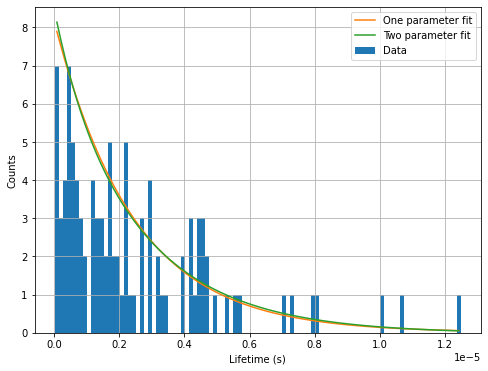

0.30038525000000504

In [ ]:
# 100
m1e2 = s1e2.obtain_metrics(present = True)
s1e2.plot_result(plot_1_fit = True, plot_2_fit = True)
tres1e2.best

Single parameter fit:
----------
tau_avg = 2.233304351595525e-06 ± 9.66352558654586e-08
    -> Error = 5.016485639967584e-08 (0.02297831014008363)
  -> 𝜒² = 137.4051785864617
  -> P(𝜒²) = 0.0035859946661891983 

Est. tau+ (t) = 2.1969811e-06 ± 9.506354589756625e-08
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.250374504312123e-06 ± 9.737388273017982e-08
    -> Error = 5.339340431212316e-08 (0.02372645273478338)
Est. tau+ = 2.2477914887794147e-06 ± 9.72621154368032e-08
    -> Error = 5.0810388779414725e-08 (0.022604582779608952)

Double parameter fit:
----------
tau - = 2.233305207751432e-06 ± 0.001430265573895839
    -> Error = 6.758447987260627e-08 (0.031206461203703125)
tau + = 2.2333052506011343e-06 ± 0.001286348372891178
    -> Error = 3.632415060113432e-08 (0.01653366549267735)
    -> 𝜒² = 137.40495423681207
    -> P(𝜒²) = 0.002361717797998236 

Charge ratios:
--------------
rho (tau) = -1.8874724573683879
    -> Error = 3.164072457368388 (2.4785151632213593)

rho (N) = 0.93433047472

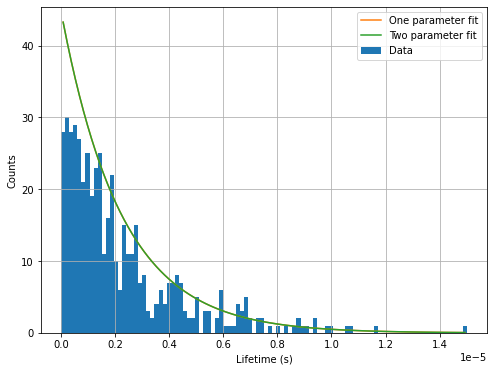

1.48370220999999

In [ ]:
# 500
m5e2 = s5e2.obtain_metrics(present = True)
s5e2.plot_result(plot_1_fit = True, plot_2_fit = True)
tres5e2.best

Single parameter fit:
----------
tau_avg = 2.3327729145964943e-06 ± 8.764026946337739e-08
    -> Error = 1.4963341940064533e-07 (0.06854047564524582)
  -> 𝜒² = 92.19902203240724
  -> P(𝜒²) = 0.5908459065762296 

Est. tau+ (t) = 2.1969811000000008e-06 ± 8.25386879306681e-08
    -> Error = 8.470329472543003e-22 (3.8554403005756403e-16)
Est. tau+ (N) = 2.350953416601121e-06 ± 8.832329527875036e-08
    -> Error = 1.5397231660112116e-07 (0.06549356338320214)
Est. tau+ = 2.3485838356319854e-06 ± 8.823427215062751e-08
    -> Error = 1.516027356319855e-07 (0.0645507021431025)

Double parameter fit:
----------
tau - = 2.332772721048282e-06 ± 0.0017417511953530186
    -> Error = 1.6705199316945644e-07 (0.07713459589643046)
tau + = 2.332774950832571e-06 ± 0.0018934177785136935
    -> Error = 1.357938508325711e-07 (0.061809294050172346)
    -> 𝜒² = 92.19844702667824
    -> P(𝜒²) = 0.5332795343944452 

Charge ratios:
--------------
rho (tau) = -1.2479651014759277
    -> Error = 2.524565101475928 (1

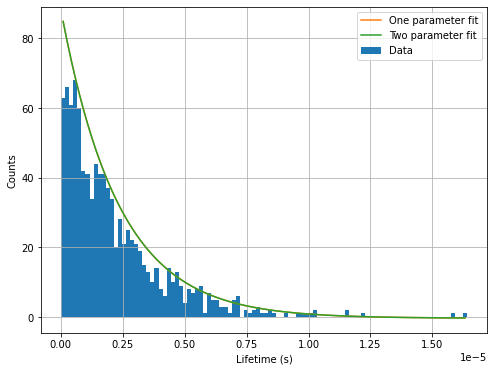

2.881072133000032

In [ ]:
# 1,000
m1e3 = s1e3.obtain_metrics(present = True)
s1e3.plot_result(plot_1_fit = True, plot_2_fit = True)
tres1e3.best

Single parameter fit:
----------
tau_avg = 2.3874051087300307e-06 ± 3.4975823972882225e-08
    -> Error = 2.0426561353418174e-07 (0.09356507634243368)
  -> 𝜒² = 178.38124978652823
  -> P(𝜒²) = 6.793082696480844e-07 

Est. tau+ (t) = 2.1969811000000008e-06 ± 3.218608519551276e-08
    -> Error = 8.470329472543003e-22 (3.8554403005756403e-16)
Est. tau+ (N) = 2.406266826413547e-06 ± 3.5252151287212675e-08
    -> Error = 2.0928572641354726e-07 (0.08697527810142319)
Est. tau+ = 2.4039678958684534e-06 ± 3.5218471157197734e-08
    -> Error = 2.069867958684535e-07 (0.08610214646551168)

Double parameter fit:
----------
tau - = 2.3874032565571806e-06 ± 0.0031366721048693806
    -> Error = 2.2168252867835488e-07 (0.10235970216505137)
tau + = 2.3874182669219663e-06 ± 0.003135633458609398
    -> Error = 1.904371669219664e-07 (0.08668129503798025)
    -> 𝜒² = 178.34519426321287
    -> P(𝜒²) = 3.5334008585369285e-07 

Charge ratios:
--------------
rho (tau) = -1.1809656327763352
    -> Error = 2.4575

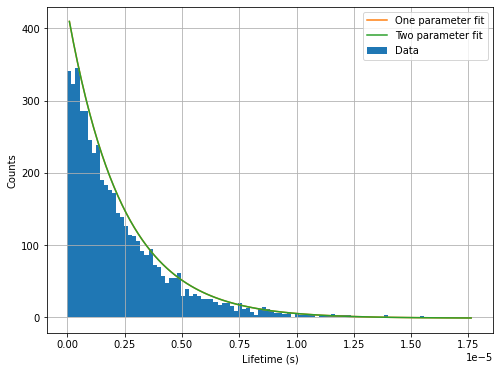

14.931825259999982

In [ ]:
# 5,000
m5e3 = s5e3.obtain_metrics(present = True)
s5e3.plot_result(plot_1_fit = True, plot_2_fit = True)
tres5e3.best

Single parameter fit:
----------
tau_avg = 2.404934548030922e-06 ± 3.038985190512039e-08
    -> Error = 2.2179505283507283e-07 (0.10159454002969043)
  -> 𝜒² = 224.77405291467548
  -> P(𝜒²) = 2.469621388199168e-12 

Est. tau+ (t) = 2.196981100000001e-06 ± 2.776205710978718e-08
    -> Error = 1.2705494208814505e-21 (5.783160450863459e-16)
Est. tau+ (N) = 2.4240851957485916e-06 ± 3.063184825557414e-08
    -> Error = 2.2710409574859167e-07 (0.09368651569956836)
Est. tau+ = 2.421742307648574e-06 ± 3.0602242436104074e-08
    -> Error = 2.2476120764857392e-07 (0.09280971263487117)

Double parameter fit:
----------
tau - = 2.40493407071317e-06 ± 0.46777384983976406
    -> Error = 2.392133428343445e-07 (0.11045438119283157)
tau + = 2.404934097363572e-06 ± 0.4677673301835927
    -> Error = 2.0795299736357198e-07 (0.09465397647871071)
    -> 𝜒² = 224.76737715063894
    -> P(𝜒²) = 1.0197807582701317e-12 

Charge ratios:
--------------
rho (tau) = -1.166927860047784
    -> Error = 2.443527860047784

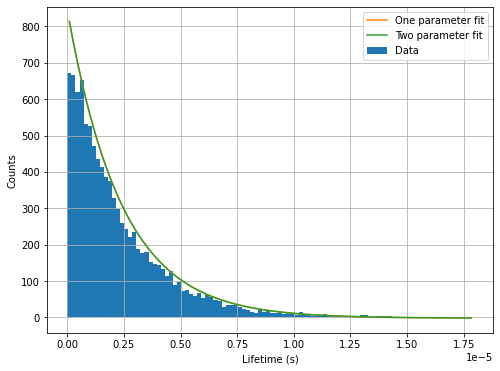

28.38172763

In [ ]:
# 10,000
m1e4 = s1e4.obtain_metrics(present = True)
s1e4.plot_result(plot_1_fit = True, plot_2_fit = True)
tres1e4.best

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:283: RuntimeWarning: invalid value encountered in sqrt


Single parameter fit:
----------
tau_avg = 2.35277544073711e-06 ± 2.570262675427059e-08
    -> Error = 1.6963594554126113e-07 (0.07770275143414193)
  -> 𝜒² = 320.217294488554
  -> P(𝜒²) = 0.999999999922886 

Est. tau+ (t) = 2.1969811000000004e-06 ± 2.4000669261537464e-08
    -> Error = 4.235164736271502e-22 (1.9277201502878204e-16)
Est. tau+ (N) = 2.3711018866820236e-06 ± nan
    -> Error = 1.741207866820237e-07 (0.07343454436100921)
Est. tau+ = 2.3688596027117657e-06 ± 2.5878336345900925e-08
    -> Error = 1.7187850271176575e-07 (0.072557488217118)

Double parameter fit:
----------
tau - = 2.3527361636787003e-06 ± 0.0013867600377103747
    -> Error = 1.8701543579987465e-07 (0.08635251692079587)
tau + = 2.3528219778607394e-06 ± 0.0013957580628038686
    -> Error = 1.5584087786073943e-07 (0.07093410037106802)
    -> 𝜒² = 320.6745763919736
    -> P(𝜒²) = 0.9999999998635207 

Charge ratios:
--------------
rho (tau) = -1.2179819286414122
    -> Error = 2.4945819286414124 (1.954082663826893

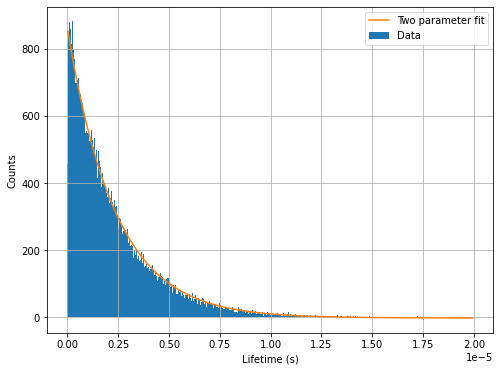

144.530419435

In [ ]:
# 50,000
m5e4 = s5e4.obtain_metrics(present = True, bins = 500)
s5e4.plot_result(plot_2_fit = True, bins = 500)
tres5e4.best

Single parameter fit:
----------
tau_avg = 2.3380306565423426e-06 ± 2.2180711679409656e-08
    -> Error = 1.5489116134649366e-07 (0.07094881554171985)
  -> 𝜒² = 518.8098674958937
  -> P(𝜒²) = 0.23132513938037982 

Est. tau+ (t) = 2.1969811000000008e-06 ± 2.0842585706957835e-08
    -> Error = 8.470329472543003e-22 (3.8554403005756403e-16)
Est. tau+ (N) = 2.356127815887592e-06 ± 2.235239921222626e-08
    -> Error = 1.591467158875919e-07 (0.06754587540389388)
Est. tau+ = 2.3539131717008554e-06 ± 2.233138784291036e-08
    -> Error = 1.569320717008555e-07 (0.06666858981355794)

Double parameter fit:
----------
tau - = 2.3380257105131226e-06 ± 0.0005423535047152511
    -> Error = 1.723049826342969e-07 (0.07956011152142307)
tau + = 2.338041030253154e-06 ± 0.000544035758104167
    -> Error = 1.4105993025315393e-07 (0.06420625569020777)
    -> 𝜒² = 519.1613241693643
    -> P(𝜒²) = 0.209427096603541 

Charge ratios:
--------------
rho (tau) = -1.2392600376238057
    -> Error = 2.515860037623806 

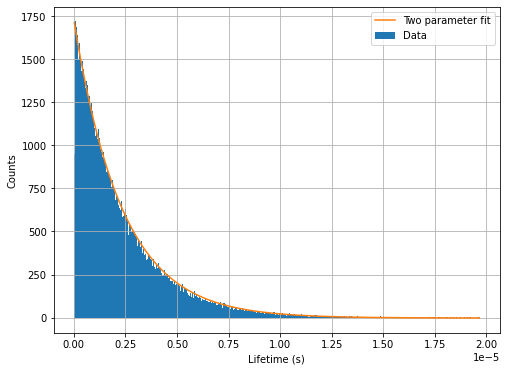

279.44252753100005

In [ ]:
# 100,000
m1e5 = s1e5.obtain_metrics(present = True, bins = 500)
s1e5.plot_result(plot_2_fit = True, bins = 500)
tres1e5.best

In [ ]:
d = detector()
p = muon_plane(d.height+10, d.radius*5, p_max=250)

s = system(d,p)

o = s.simulate(100000,scint_time_steps = 100)

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Single parameter fit:
----------
tau_avg = 2.3331167261796337e-06 ± 2.102482467622275e-08
    -> Error = 1.4997723098378476e-07 (0.06869796058099821)
  -> 𝜒² = 524.2549865632077
  -> P(𝜒²) = 1.5597357507585517e-05 

Est. tau+ (t) = 2.1969811000000004e-06 ± 1.9798041789517414e-08
    -> Error = 4.235164736271502e-22 (1.9277201502878204e-16)
Est. tau+ (N) = 2.351138896386337e-06 ± 2.1187232466301793e-08
    -> Error = 1.5415779638633718e-07 (0.06556728597501205)
Est. tau+ = 2.348932323886057e-06 ± 2.1167346550587653e-08
    -> Error = 1.519512238860572e-07 (0.06468948566158354)

Double parameter fit:
----------
tau - = 2.3331164088146115e-06 ± 0.00033554079112601957
    -> Error = 1.6739568093578578e-07 (0.07729329030328777)
tau + = 2.3331165275158385e-06 ± 0.00034670395493635603
    -> Error = 1.3613542751583855e-07 (0.0619647695266193)
    -> 𝜒² = 521.9688901171805
    -> P(𝜒²) = 1.5577403479363442e-05 

Charge ratios:
--------------
rho (tau) = -1.2473753172809252
    -> Error = 2.523

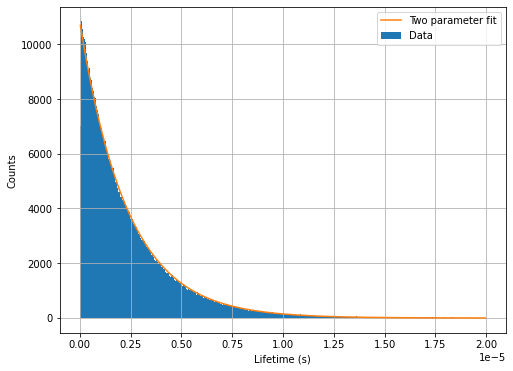

1383.968761969

In [ ]:
# 500,000
m5e5 = s5e5.obtain_metrics(present = True, bins = 400)
s5e5.plot_result(plot_2_fit = True, bins = 400)
tres5e5.best

Single parameter fit:
----------
tau_avg = 2.342638621448584e-06 ± 1.9033277177116338e-08
    -> Error = 1.5949912625273507e-07 (0.073059521209581)
  -> 𝜒² = -3037.3784729146264
  -> P(𝜒²) = 1.0 

Est. tau+ (t) = 2.1969811000000008e-06 ± 1.784985095292181e-08
    -> Error = 8.470329472543003e-22 (3.8554403005756403e-16)
Est. tau+ (N) = 2.3608063716752634e-06 ± 1.9180886999328424e-08
    -> Error = 1.6382527167526346e-07 (0.06939377732999365)
Est. tau+ = 2.358584016670251e-06 ± 1.9162829009897523e-08
    -> Error = 1.616029166702511e-07 (0.06851692181752136)

Double parameter fit:
----------
tau - = 2.342645856715001e-06 ± 0.01771813834395975
    -> Error = 1.769251288361753e-07 (0.08169341806570844)
tau + = 2.3426462128203037e-06 ± 0.017718549854557987
    -> Error = 1.4566511282030377e-07 (0.06630239687555974)
    -> 𝜒² = -3040.140109416955
    -> P(𝜒²) = 1.0 

Charge ratios:
--------------
rho (tau) = -1.2321475334636927
    -> Error = 2.508747533463693 (1.9651790172831682)

rho (N) 

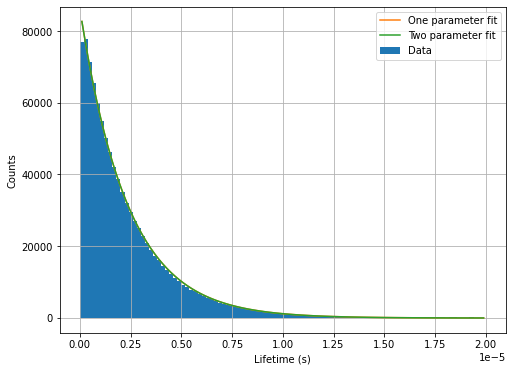

2759.825496202

In [ ]:
# 1,000,000
m1e6 = s1e6.obtain_metrics(present = True, bins = 99)
s1e6.plot_result(plot_1_fit = True, plot_2_fit = True)
tres1e6.best

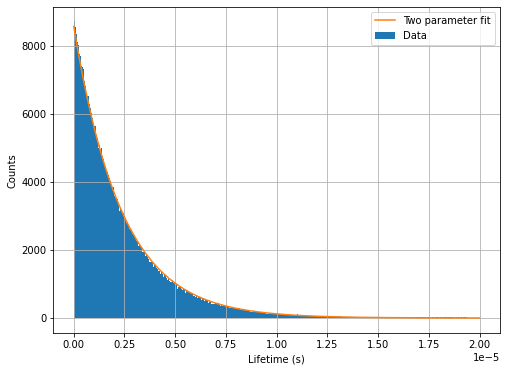

No fit could be obtained with this value of bins: try increasing the bins or gathering more data.
Single parameter fit:
----------
tau_avg = 2.3512366658758223e-06 ± 2.159921471224997e-08
    -> Error = 1.680971706799733e-07 (0.0769979064782085)
  -> 𝜒² = -5908.1800788906685
  -> P(𝜒²) = 1.0 

Est. tau+ (t) = 2.1969811000000008e-06 ± nan
    -> Error = 8.470329472543003e-22 (3.8554403005756403e-16)
Est. tau+ (N) = nan ± nan
    -> Error = nan (nan)
Est. tau+ = 2.367299724010801e-06 ± 2.1746775120195346e-08
    -> Error = 1.7031862401080104e-07 (0.07194637091506033)

Double parameter fit:
----------
tau - = nan ± nan
    -> Error = nan (nan)
tau + = nan ± nan
    -> Error = nan (nan)
    -> 𝜒² = nan
    -> P(𝜒²) = nan 

Charge ratios:
--------------
rho (tau) = -1.2200124173223998
    -> Error = 2.4966124173224 (1.955673207991853)

rho (N) = nan
    -> Error = nan (nan)

Proportions:
-----------
N generated = 32099136
N detected = 1000000
N measured = 999291
Proportion detected = 0.0311

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:355: UserWarning: No fit could be obtained for the two-parameter distribution. Try increasing bins?


In [ ]:
s1e6.plot_result(bins = 1000, plot_2_fit = True)
a = s1e6.obtain_metrics(bins = 500, present=True)

In [ ]:
m_n_mu = [m1e2,m5e2,m1e3,m5e3,m1e4,m5e4,m1e5,m5e5,m1e6]
n_mus = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]

mmr_n_mu = multi_metric_result(m_n_mu, ind_var_list=n_mus)

mmr_n_mu.print_all()

[2.43427171e-06 2.23330435e-06 2.33277291e-06 2.38740511e-06
 2.40493455e-06 2.35277544e-06 2.33803066e-06 2.33311673e-06
 2.34263862e-06]
[3.04984681e-07 9.66352559e-08 8.76402695e-08 3.49758240e-08
 3.03898519e-08 2.57026268e-08 2.21807117e-08 2.10248247e-08
 1.90332772e-08] 

[   96.6676532    137.40517859    92.19902203   178.38124979
   224.77405291   320.21729449   518.8098675    524.25498656
 -3037.37847291]
[4.61688361e-01 3.58599467e-03 5.90845907e-01 6.79308270e-07
 2.46962139e-12 1.00000000e+00 2.31325139e-01 1.55973575e-05
 1.00000000e+00] 

[2.1969811e-06 2.1969811e-06 2.1969811e-06 2.1969811e-06 2.1969811e-06
 2.1969811e-06 2.1969811e-06 2.1969811e-06 2.1969811e-06]
[2.75255049e-07 9.50635459e-08 8.25386879e-08 3.21860852e-08
 2.77620571e-08 2.40006693e-08 2.08425857e-08 1.97980418e-08
 1.78498510e-08] 

[2.44075417e-06 2.25037450e-06 2.35095342e-06 2.40626683e-06
 2.42408520e-06 2.37110189e-06 2.35612782e-06 2.35113890e-06
 2.36080637e-06]
[2.35293865e-06 9.73738827e-08 

##### 3.1.2 - Data presentation

In [ ]:
n_mus = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]

In [ ]:
1/(1/tau_plus + cap_rate/(charge_ratio + 1))

2.183139495195849e-06

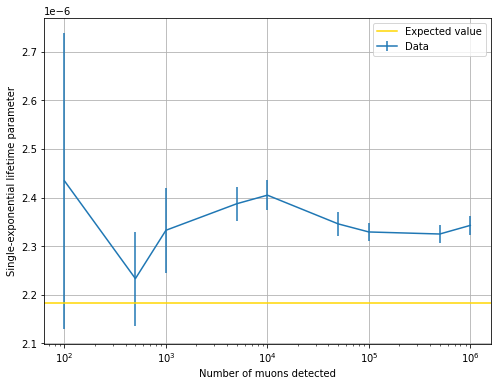

In [ ]:
# Single parameter errorbar
plt.figure(figsize = (8,6))
plt.errorbar(n_mus, mmr_n_mu.avgs, mmr_n_mu.avgs_u, label = 'Data')
plt.axhline(1/(1/tau_plus + cap_rate/(charge_ratio + 1)) , label='Expected value', color = 'gold')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel('Single-exponential lifetime parameter')
plt.xscale('log')
plt.legend()
plt.show()

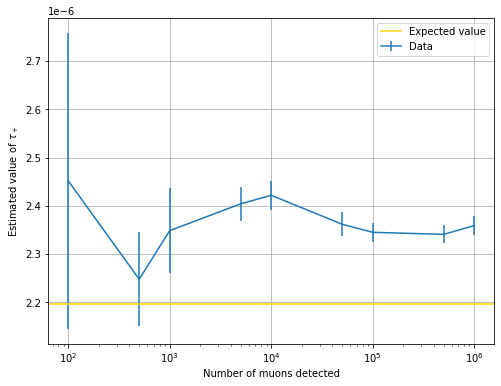

In [ ]:
# Single parameter tau_+ errorbar
plt.figure(figsize = (8,6))
plt.errorbar(n_mus, mmr_n_mu.avg_ps, mmr_n_mu.avg_ps_u, label = 'Data')
plt.axhline(tau_plus , label='Expected value', color = 'gold')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel(r'Estimated value of $\tau_+$')
plt.xscale('log')
plt.legend()
plt.show()

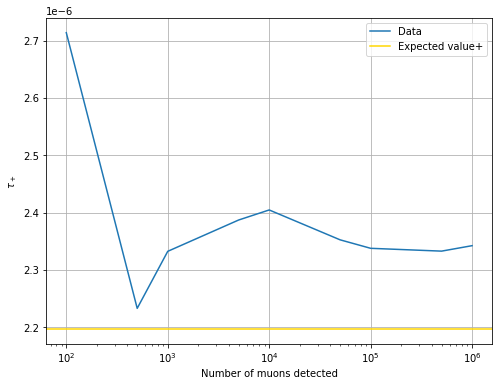

In [ ]:
# Double parameter tau_+ errorbar
plt.figure(figsize = (8,6))
#plt.errorbar(n_mus, mmr_n_mu.tau_ps, mmr_n_mu.tau_ps_u, label = 'Data')
plt.plot(n_mus, mmr_n_mu.tau_ps, label = 'Data')
#plt.plot(n_mus, mmr_n_mu.tau_ps_u, label = 'Uncertainty upon data')
plt.axhline(tau_plus, label = 'Expected value+', color = 'gold')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel(r'$\tau_+$')
plt.xscale('log')
plt.legend()
plt.show()

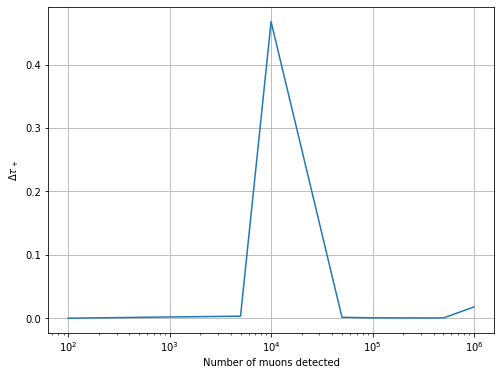

In [ ]:
# Double parameter tau_+ errorbar
plt.figure(figsize = (8,6))
#plt.errorbar(n_mus, mmr_n_mu.tau_ps, mmr_n_mu.tau_ps_u, label = 'Data')
plt.plot(n_mus, mmr_n_mu.tau_ps_u, label = 'Uncertainty')
#plt.plot(n_mus, mmr_n_mu.tau_ps_u, label = 'Uncertainty upon data')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel(r'$\Delta \tau_+$')
plt.xscale('log')
plt.show()

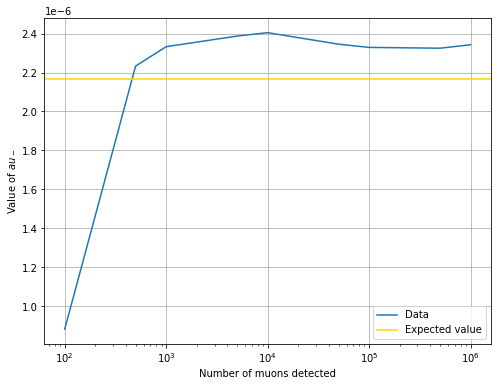

In [ ]:
# Double parameter tau_- errorbar
plt.figure(figsize = (8,6))
#plt.errorbar(n_mus, mmr_n_mu.tau_ms, mmr_n_mu.tau_ms_u, label = 'Data')
plt.plot(n_mus, mmr_n_mu.tau_ms, label = 'Data')
plt.axhline(tau_minus, label = 'Expected value', color = 'gold')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel('Value of $\tau_-$')
plt.xscale('log')
plt.legend()
plt.show()

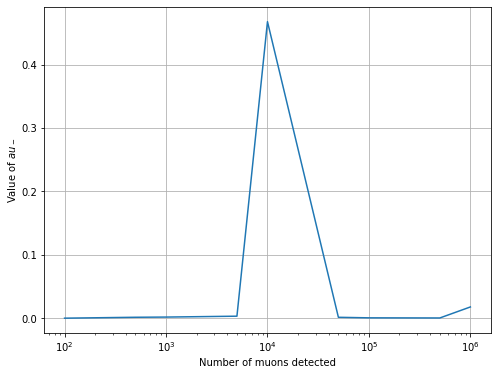

In [ ]:
# Double parameter tau_- errorbar
plt.figure(figsize = (8,6))
#plt.errorbar(n_mus, mmr_n_mu.tau_ms, mmr_n_mu.tau_ms_u, label = 'Data')
plt.plot(n_mus, mmr_n_mu.tau_ms_u, label = 'Data')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel('Value of $\tau_-$')
plt.xscale('log')
plt.show()

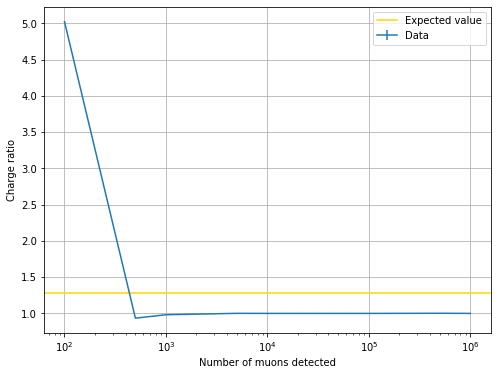

In [ ]:
# Rho n errorbar
plt.figure(figsize = (8,6))
plt.errorbar(n_mus, mmr_n_mu.rho_ns, mmr_n_mu.rho_ns_u, label = 'Data')
plt.axhline(charge_ratio, label = 'Expected value', color = 'gold')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel('Charge ratio')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
rates = mmr_n_mu.rate_m
print('Average detection rate:',np.mean(mmr_n_mu.rate_m),'per minute')
total_mu = sum(mus)

print(mmr_n_mu.rate_m)

Average detection rate: 149.03410641107527 per minute
[253.39278043 237.38082973 235.10995705 227.08815341 234.48489819
  60.73118761  37.36421832  28.33048405  27.42444891]


In [ ]:
# real time detection rates
times = np.array([tres1e2.best, tres5e2.best, tres1e3.best, tres5e3.best, tres1e4.best, tres5e4.best, tres1e5.best, tres5e5.best, tres1e6.best])
mus = np.array([100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000])
real_rates = np.divide(mus, times) # mus per second
print('Average no. of detections per real-time seconds:',np.mean(real_rates))
print(real_rates) 
[264.72567402, 345.49348964, 357.5226771, 322.52348563, 262.36624441, 397.3762404,  381.09559601, 366.95028223, 378.85525532]

Average no. of detections per real-time seconds: 341.878771642459
[264.72567402 345.49348964 357.5226771  322.52348563 262.36624441
 397.3762404  381.09559601 366.95028223 378.85525532]


In [ ]:
times2 = np.array([tres1e2.best, tres5e2.best, tres1e3.best, tres5e3.best, tres1e4.best, tres5e4.best, tres1e5.best, tres5e5.best, tres1e6.best])
mus = np.array([100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000])
total_t = sum(times2)
total_mu = sum(mus)
print('Average no. of detections per real-time seconds:',total_mu/total_t)

Average no. of detections per real-time seconds: 361.0684014555426


### 3.1 (again) - 1 million muons, more realistic

In [91]:
# 100
d1e2 = detector()
p1e2 = muon_plane(d1e2.height + 10, d1e2.radius*5, p_max = 200, n_pre_gen = 1000000)
s1e2 = system(d1e2,p1e2)

# 500
d5e2 = detector()
p5e2 = muon_plane(d5e2.height + 10, d5e2.radius*5, p_max = 200, n_pre_gen = 1000000)
s5e2 = system(d5e2,p5e2)

# 1,000
d1e3 = detector()
p1e3 = muon_plane(d1e3.height + 10, d1e3.radius*5, p_max = 200, n_pre_gen = 1000000)
s1e3 = system(d1e3,p1e3)

# 5,000
d5e3 = detector()
p5e3 = muon_plane(d5e3.height + 10, d5e3.radius*5, p_max = 200, n_pre_gen = 1000000)
s5e3 = system(d5e3,p5e3)

# 10,000
d1e4 = detector()
p1e4 = muon_plane(d1e4.height + 10, d1e4.radius*5, p_max = 200, n_pre_gen = 1000000)
s1e4 = system(d1e4,p1e4)

# 50,000
d5e4 = detector()
p5e4 = muon_plane(d5e4.height + 10, d5e4.radius*5, p_max = 200, n_pre_gen = 1000000)
s5e4 = system(d5e4,p5e4)

# 100,000
d1e5 = detector()
p1e5 = muon_plane(d1e5.height + 10, d1e5.radius*5, p_max = 200, n_pre_gen = 1000000)
s1e5 = system(d1e5,p1e5)

# 500,000
d5e5 = detector()
p5e5 = muon_plane(d5e5.height + 10, d5e5.radius*5, p_max = 200, n_pre_gen = 1000000)
s5e5 = system(d5e5,p5e5)

# 1,000,000
d1e6 = detector()
p1e6 = muon_plane(d1e6.height + 10, d1e6.radius*5, p_max = 200, n_pre_gen = 1000000)
s1e6 = system(d1e6,p1e6)


In [92]:
# 100
tres1e2 = %timeit -oq -r 1 -n 1 res1e2, rej1e2 = s1e2.simulate(int(1e2), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 500
tres5e2 = %timeit -oq -r 1 -n 1 res5e2, rej5e2 = s5e2.simulate(int(5e2), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 1,000
tres1e3 = %timeit -oq -r 1 -n 1 res1e3, rej1e3 = s1e3.simulate(int(1e3), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 5,000
tres5e3 = %timeit -oq -r 1 -n 1 res5e3, rej5e3 = s5e3.simulate(int(5e3), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 10,000
tres1e4 = %timeit -oq -r 1 -n 1 res1e4, rej1e4 = s1e4.simulate(int(1e4), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 50,000
tres5e4 = %timeit -oq -r 1 -n 1 res5e4, rej5e4 = s5e4.simulate(int(5e4), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 100,000
tres1e5 = %timeit -oq -r 1 -n 1 res1e5, rej1e5 = s1e5.simulate(int(1e5), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 500,000
tres5e5 = %timeit -oq -r 1 -n 1 res5e5, rej5e5 = s5e5.simulate(int(5e5), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

# 1,000,000
tres1e6 = %timeit -oq -r 1 -n 1 res1e6, rej1e6 = s1e6.simulate(int(1e6), treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)


Generating muons:   0%|          | 0/100 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/500 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/5000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/10000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/50000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/500000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/1000000 [00:00<?, ?it/s]

##### 3.1.1 - Data dump

No fit could be obtained with this value of bins: try increasing the bins or gathering more data.
Single parameter fit:
----------
tau_avg = 1.968025554609131e-06 ± 1.2880138375740683e-07
    -> Error = 2.1511394058671815e-07 (0.09853421692021577)
  -> 𝜒² = 12.335277357524575
  -> P(𝜒²) = 0.05489375788778563 

Est. tau+ (t) = 2.196981099999999e-06 ± nan
    -> Error = 8.470329472543003e-22 (3.8554403005756433e-16)
Est. tau+ (N) = nan ± nan
    -> Error = nan (nan)
Est. tau+ = 1.979266781335489e-06 ± 1.295370884102731e-07
    -> Error = 2.17714318664511e-07 (0.1099974600279052)

Double parameter fit:
----------
tau - = nan ± nan
    -> Error = nan (nan)
tau + = nan ± nan
    -> Error = nan (nan)
    -> 𝜒² = nan
    -> P(𝜒²) = nan 

Charge ratios:
--------------
rho (tau) = -0.8759287216280072 ± nan
    -> Error = 2.1525287216280073 (1.6861418781356785)

rho (N) = nan ± nan
    -> Error = nan (nan)

Proportions:
-----------
N generated = 4029
N detected = 100
N measured = 100
Proportion 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:355: UserWarning: No fit could be obtained for the two-parameter distribution. Try increasing bins?


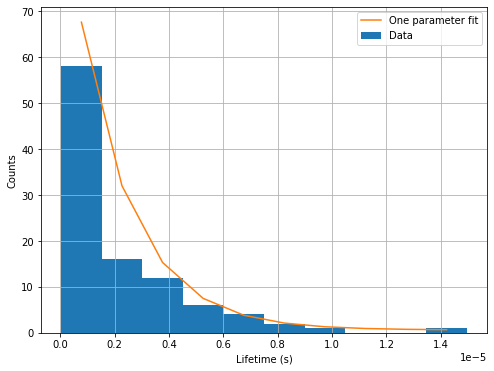

0.41506767199825845

In [95]:
# 100
m1e2 = s1e2.obtain_metrics(present = True, bins = 10)
s1e2.plot_result(plot_1_fit = True, bins = 10)
tres1e2.best

Single parameter fit:
----------
tau_avg = 2.418164579142652e-06 ± 1.14185137312267e-07
    -> Error = 2.3502508394680317e-07 (0.10765463428424628)
  -> 𝜒² = 2.47272406374446
  -> P(𝜒²) = 1.0 

Est. tau+ (t) = 2.1969811000000008e-06 ± 1.037409077699601e-07
    -> Error = 8.470329472543003e-22 (3.8554403005756403e-16)
Est. tau+ (N) = 2.4306361114808906e-06 ± 1.1477404001026345e-07
    -> Error = 2.3365501148089062e-07 (0.09612916157101518)
Est. tau+ = 2.4351584265491134e-06 ± 1.1498758261160988e-07
    -> Error = 2.3817732654911348e-07 (0.0978077335554044)

Double parameter fit:
----------
tau - = 2.417767688423833e-06 ± 0.0034006610562022266
    -> Error = 2.520469605450072e-07 (0.11638017649296355)
tau + = 2.4183539240060353e-06 ± 0.0015838563260733185
    -> Error = 2.2137282400603532e-07 (0.10076227966004593)
    -> 𝜒² = 2.471544293386641
    -> P(𝜒²) = 1.0 

Charge ratios:
--------------
rho (tau) = -1.1578064901936522 ± -1.8695708222234938e-07
    -> Error = 2.4344064901936524 (1.

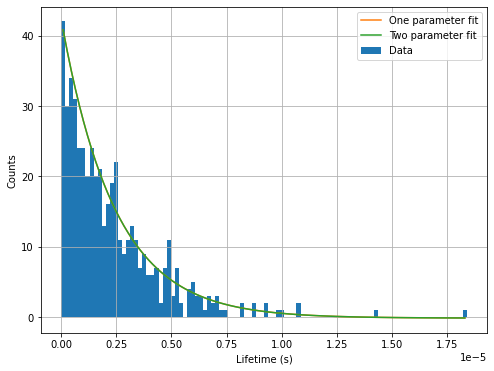

1.9070668120002665

In [96]:
# 500
m5e2 = s5e2.obtain_metrics(present = True)
s5e2.plot_result(plot_1_fit = True, plot_2_fit = True)
tres5e2.best

Single parameter fit:
----------
tau_avg = 1.9568036143413935e-06 ± 5.203774771852088e-08
    -> Error = 2.2633588085445548e-07 (0.10367449324815176)
  -> 𝜒² = 205.13434271232722
  -> P(𝜒²) = 6.612780105151387e-10 

Est. tau+ (t) = 2.1969810999999982e-06 ± 5.842484518451969e-08
    -> Error = 1.6940658945086007e-21 (7.71088060115129e-16)
Est. tau+ (N) = 1.9815886881811556e-06 ± 8.874201408029621e-05
    -> Error = 2.153924118188443e-07 (0.10869683153901476)
Est. tau+ = 1.967916646711613e-06 ± 5.233327925302486e-08
    -> Error = 2.2906445328838695e-07 (0.11639946929213361)

Double parameter fit:
----------
tau - = 1.819794993795887e-08 ± 1.942717663394335e-05
    -> Error = 2.147522777940867e-06 (0.9915972776620269)
tau + = 2.074788946181477e-06 ± 6.272512357153437e-08
    -> Error = 1.2219215381852276e-07 (0.055618208922472184)
    -> 𝜒² = 249.10392997096042
    -> P(𝜒²) = 5.628787544592742e-16 

Charge ratios:
--------------
rho (tau) = -0.8824001850846894 ± -4.868862052754583e-08
  

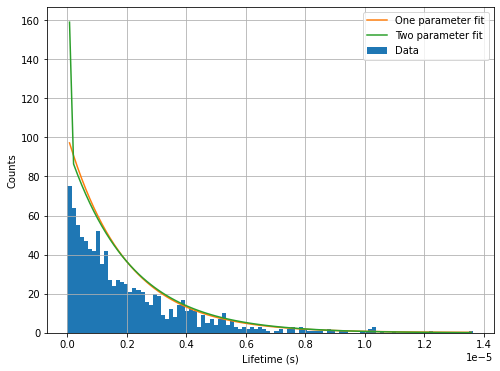

3.613371276998805

In [97]:
# 1,000
m1e3 = s1e3.obtain_metrics(present = True)
s1e3.plot_result(plot_1_fit = True, plot_2_fit = True)
tres1e3.best

Single parameter fit:
----------
tau_avg = 2.0686728575372276e-06 ± 3.101035916008624e-08
    -> Error = 1.144666376586214e-07 (0.052432122597073264)
  -> 𝜒² = 257.18759827144146
  -> P(𝜒²) = 1.168729379787819e-16 

Est. tau+ (t) = 2.196981099999999e-06 ± 3.2933758825583126e-08
    -> Error = 8.470329472543003e-22 (3.8554403005756433e-16)
Est. tau+ (N) = 2.0757115355780965e-06 ± 3.6652791330646327e-06
    -> Error = 1.2126956442190344e-07 (0.058423129776618614)
Est. tau+ = 2.0810968950938302e-06 ± 3.1196601206741856e-08
    -> Error = 1.1588420490616972e-07 (0.055684194801004144)

Double parameter fit:
----------
tau - = 1.2041522516965306e-06 ± 8.82048481572163e-07
    -> Error = 9.61568476182295e-07 (0.44399467752432015)
tau + = 2.3630563903353063e-06 ± 4.596415655090525e-07
    -> Error = 1.6607529033530639e-07 (0.07559249842217869)
    -> 𝜒² = 274.5522688324936
    -> P(𝜒²) = 1.3978329188611374e-19 

Charge ratios:
--------------
rho (tau) = -0.7672825494732347 ± -3.05050712224132e

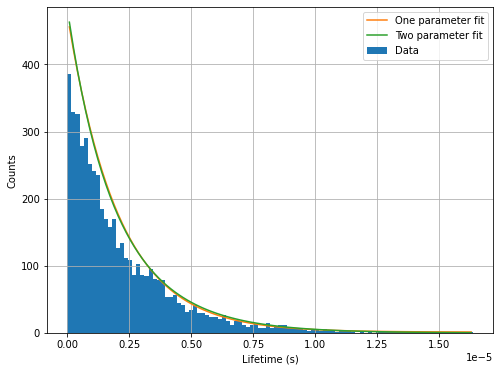

17.669236844001716

In [98]:
# 5,000
m5e3 = s5e3.obtain_metrics(present = True)
s5e3.plot_result(plot_1_fit = True, plot_2_fit = True)
tres5e3.best

Single parameter fit:
----------
tau_avg = 2.1580508778430177e-06 ± 1.9399772009841744e-08
    -> Error = 2.5088617352831238e-08 (0.011491990048295353)
  -> 𝜒² = 164.00797485449678
  -> P(𝜒²) = 1.9001380999978694e-05 

Est. tau+ (t) = 2.1969811e-06 ± 1.9749734766516655e-08
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.1609953814024226e-06 ± 7.077849598603762e-05
    -> Error = 3.598571859757732e-08 (0.016652381077382795)
Est. tau+ = 2.171575190074522e-06 ± 1.9521348649472844e-08
    -> Error = 2.5405909925477883e-08 (0.011699300140100618)

Double parameter fit:
----------
tau - = 5.187605927895198e-07 ± 2.0239621083338127e-07
    -> Error = 1.6469601350893058e-06 (0.7604674572710904)
tau + = 2.281998673532068e-06 ± 5.0679704394107145e-08
    -> Error = 8.501757353206813e-08 (0.03869745330629751)
    -> 𝜒² = 1325.4876956052126
    -> P(𝜒²) = 1.7641083675777328e-216 

Charge ratios:
--------------
rho (tau) = -0.1998590681481011 ± -4.204511311296993e-09
    -> Error = 1.4764590681481014 (1.

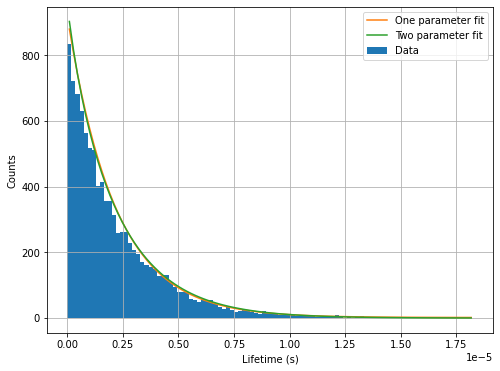

37.00611774900244

In [99]:
# 10,000
m1e4 = s1e4.obtain_metrics(present = True)
s1e4.plot_result(plot_1_fit = True, plot_2_fit = True)
tres1e4.best

Single parameter fit:
----------
tau_avg = 2.202534823630798e-06 ± 9.428857057400609e-09
    -> Error = 1.9395328434949057e-08 (0.008884145276850074)
  -> 𝜒² = 487.4990574480689
  -> P(𝜒²) = 0.5988082664528168 

Est. tau+ (t) = 2.1969811e-06 ± 9.405082057074263e-09
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.2168157426901585e-06 ± 9.49000622365098e-09
    -> Error = 1.9834642690158518e-08 (0.00894735737760898)
Est. tau+ = 2.216624256204298e-06 ± 9.489172673903062e-09
    -> Error = 1.9643156204298043e-08 (0.008861743775164936)

Double parameter fit:
----------
tau - = 2.2025106734031946e-06 ± 0.0003526919290348614
    -> Error = 3.678994552436894e-08 (0.016987391333878103)
tau + = 2.202553086773063e-06 ± 0.00028249368075332923
    -> Error = 5.571986773063063e-09 (0.0025362015053579947)
    -> 𝜒² = 487.4614844430951
    -> P(𝜒²) = 0.574447131593618 

Charge ratios:
--------------
rho (tau) = -6.724403120769032 ± -8.966587901207995e-08
    -> Error = 8.001003120769031 (6.267431553163896)

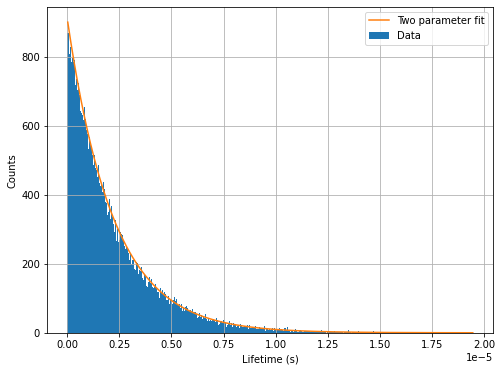

179.70400317800159

In [100]:
# 50,000
m5e4 = s5e4.obtain_metrics(present = True, bins = 500)
s5e4.plot_result(plot_2_fit = True, bins = 500)
tres5e4.best

Single parameter fit:
----------
tau_avg = 2.199777223531625e-06 ± 8.659889889593248e-09
    -> Error = 1.663772833577618e-08 (0.007621010188487115)
  -> 𝜒² = 1158.0092219498813
  -> P(𝜒²) = 6.97481065991384e-55 

Est. tau+ (t) = 2.1969811e-06 ± 8.648882355943711e-09
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.2157893926605736e-06 ± 8.722931828365331e-09
    -> Error = 1.880829266057362e-08 (0.008488303411358903)
Est. tau+ = 2.213831285353369e-06 ± 8.715216686587012e-09
    -> Error = 1.685018535336926e-08 (0.007611323168504077)

Double parameter fit:
----------
tau - = 2.1996594087783263e-06 ± 0.00017376592016135305
    -> Error = 3.393868089950063e-08 (0.01567084825971132)
tau + = 2.1998950234734416e-06 ± 0.00018182410422302997
    -> Error = 2.9139234734416617e-09 (0.001326330696901153)
    -> 𝜒² = 1157.654627429572
    -> P(𝜒²) = 3.285699537195722e-55 

Charge ratios:
--------------
rho (tau) = -12.355703304159048 ± -1.5131947926757408e-07
    -> Error = 13.632303304159048 (10.67860

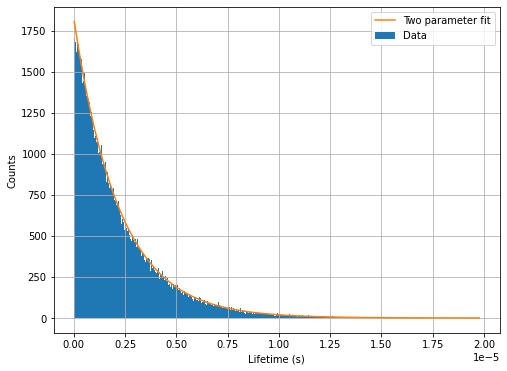

362.2003496489997

In [101]:
# 100,000, p_max = 250MeV/c
m1e5 = s1e5.obtain_metrics(present = True, bins = 500)
s1e5.plot_result(plot_2_fit = True, bins = 500)
tres1e5.best

Single parameter fit:
----------
tau_avg = 2.19376402959629e-06 ± 3.3375199415223986e-09
    -> Error = 1.0624534400440975e-08 (0.00486663102555792)
  -> 𝜒² = 491.6956880781556
  -> P(𝜒²) = 0.0007291397285290853 

Est. tau+ (t) = 2.1969811e-06 ± 3.3424142859077097e-09
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.2096921906801366e-06 ± 3.361879461168444e-09
    -> Error = 1.2711090680136642e-08 (0.005752425941381549)
Est. tau+ = 2.2077411174639462e-06 ± 3.358784220110875e-09
    -> Error = 1.076001746394629e-08 (0.0048737677524013446)

Double parameter fit:
----------
tau - = 2.1937335930103703e-06 ± 0.000259395197764971
    -> Error = 2.80128651315446e-08 (0.01293466178299973)
tau + = 2.193794811639524e-06 ± 0.00026035696685229836
    -> Error = 3.186288360476098e-09 (0.0014503030365059118)
    -> 𝜒² = 491.71890758233917
    -> P(𝜒²) = 0.0005726102891470449 

Charge ratios:
--------------
rho (tau) = 8.8428538436659 ± 4.1737972474693546e-08
    -> Error = 7.5662538436658995 (5.9268790879

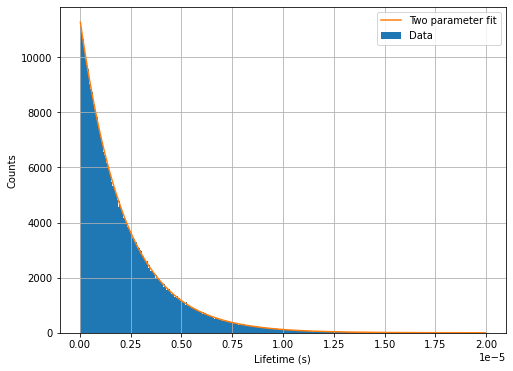

1802.783563404002

In [102]:
# 500,000
m5e5 = s5e5.obtain_metrics(present = True, bins = 400)
s5e5.plot_result(plot_2_fit = True, bins = 400)
tres5e5.best

Single parameter fit:
----------
tau_avg = 2.205873339527827e-06 ± 2.9290573745805456e-09
    -> Error = 2.273384433197822e-08 (0.010413372293435958)
  -> 𝜒² = 1456.2494132164884
  -> P(𝜒²) = 1.0944311411637638e-107 

Est. tau+ (t) = 2.1969811e-06 ± 2.917249860854585e-09
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.2219736059686774e-06 ± 2.9507922111469323e-09
    -> Error = 2.4992505968677462e-08 (0.011247886069187528)
Est. tau+ = 2.220005653920469e-06 ± 2.9478228943181927e-09
    -> Error = 2.3024553920469065e-08 (0.010371394270914732)

Double parameter fit:
----------
tau - = 2.2058733464023826e-06 ± 0.14021148120793583
    -> Error = 4.015261852355691e-08 (0.018540072137040325)
tau + = 2.2058733954510184e-06 ± 0.14019742112286496
    -> Error = 8.892295451018504e-09 (0.004047506576646702)
    -> 𝜒² = 1455.5448729931534
    -> P(𝜒²) = 4.248558950767068e-108 

Charge ratios:
--------------
rho (tau) = -4.580643714832874 ± -1.897445873977217e-08
    -> Error = 5.857243714832874 (4.58815

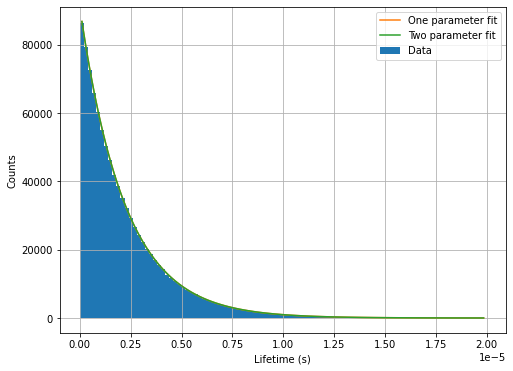

3629.2256634840014

In [105]:
# 1,000,000
m1e6 = s1e6.obtain_metrics(present = True, bins = 449)
s1e6.plot_result(plot_1_fit = True, plot_2_fit = True)
tres1e6.best

In [106]:
m_n_mu = [m1e2,m5e2,m1e3,m5e3,m1e4,m5e4,m1e5,m5e5,m1e6]
n_mus = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]

mmr_n_mu = multi_metric_result(m_n_mu, ind_var_list=n_mus)

mmr_n_mu.print_all()

avgs
[1.96802555e-06 2.41816458e-06 1.95680361e-06 2.06867286e-06
 2.15805088e-06 2.20253482e-06 2.19977722e-06 2.19376403e-06
 2.20587334e-06]
[1.28801384e-07 1.14185137e-07 5.20377477e-08 3.10103592e-08
 1.93997720e-08 9.42885706e-09 8.65988989e-09 3.33751994e-09
 2.92905737e-09] 

chi2s 1
[  12.33527736    2.47272406  205.13434271  257.18759827  164.00797485
  487.49905745 1158.00922195  491.69568808 1456.24941322]
[5.48937579e-002 1.00000000e+000 6.61278011e-010 1.16872938e-016
 1.90013810e-005 5.98808266e-001 6.97481066e-055 7.29139729e-004
 1.09443114e-107] 

+ ests t
[2.1969811e-06 2.1969811e-06 2.1969811e-06 2.1969811e-06 2.1969811e-06
 2.1969811e-06 2.1969811e-06 2.1969811e-06 2.1969811e-06]
[           nan 1.03740908e-07 5.84248452e-08 3.29337588e-08
 1.97497348e-08 9.40508206e-09 8.64888236e-09 3.34241429e-09
 2.91724986e-09] 

+ ests n
[           nan 2.43063611e-06 1.98158869e-06 2.07571154e-06
 2.16099538e-06 2.21681574e-06 2.21578939e-06 2.20969219e-06
 2.22197361e-06]
[

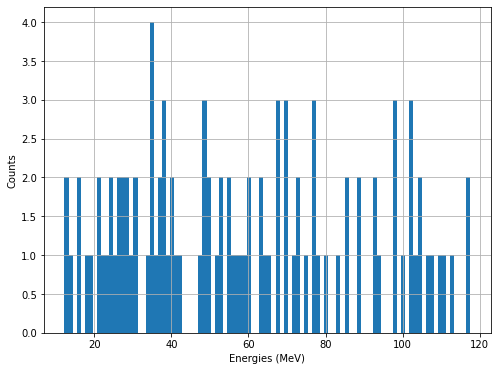

In [107]:
# energy dists

# 100
s1e2.plot_result('energies')

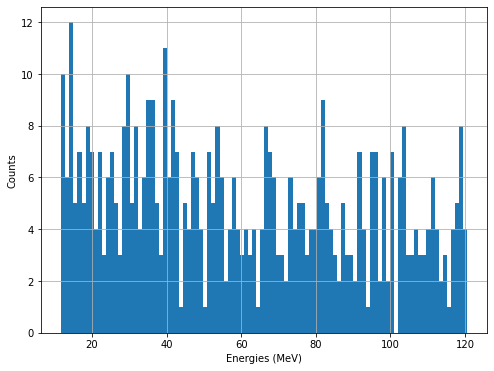

In [108]:
# 500
s5e2.plot_result('energies')

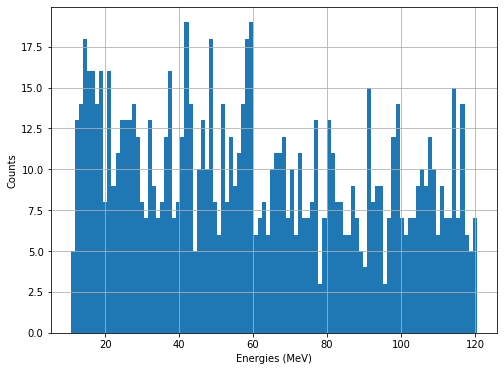

In [109]:
# 1,000
s1e3.plot_result('energies')

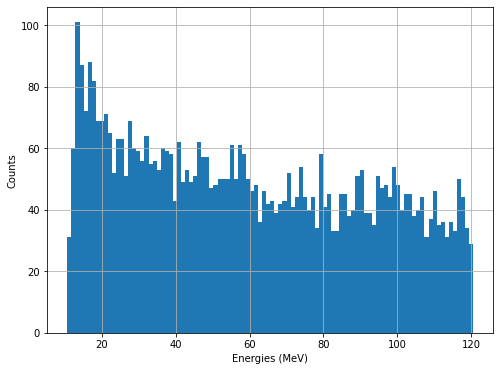

In [110]:
# 5,000
s5e3.plot_result('energies')

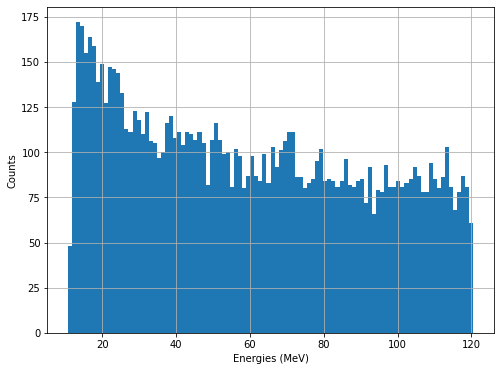

In [111]:
# 10,000
s1e4.plot_result('energies')

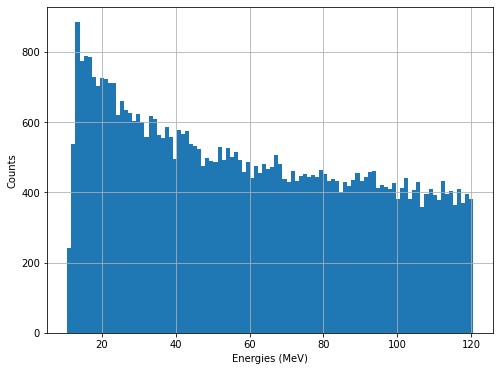

In [112]:
# 50,000
s5e4.plot_result('energies')

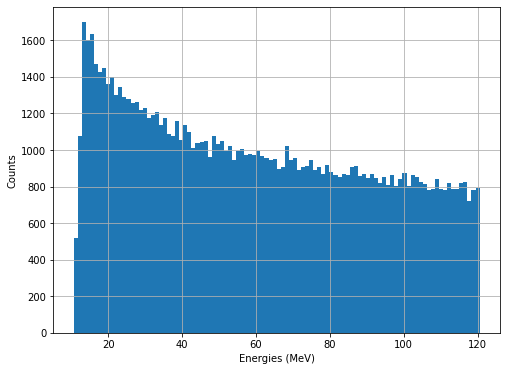

In [113]:
# 100,000
s1e5.plot_result('energies')

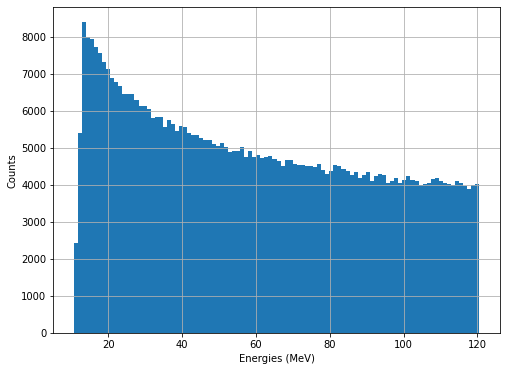

In [114]:
# 500,000
s5e5.plot_result('energies')

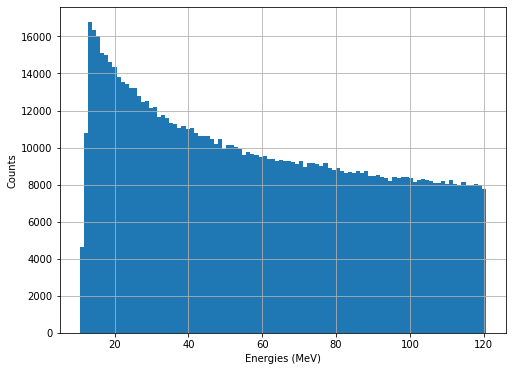

In [115]:
# 1,000,000
s1e6.plot_result('energies')

In [116]:
n_mus = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]
m_n_mu = [m1e2,m5e2,m1e3,m5e3,m1e4,m5e4,m1e5,m5e5,m1e6]

mmr_n_mu = multi_metric_result(m_n_mu, ind_var_list=n_mus)

mmr_n_mu.print_all()

avgs
[1.96802555e-06 2.41816458e-06 1.95680361e-06 2.06867286e-06
 2.15805088e-06 2.20253482e-06 2.19977722e-06 2.19376403e-06
 2.20587334e-06]
[1.28801384e-07 1.14185137e-07 5.20377477e-08 3.10103592e-08
 1.93997720e-08 9.42885706e-09 8.65988989e-09 3.33751994e-09
 2.92905737e-09] 

chi2s 1
[  12.33527736    2.47272406  205.13434271  257.18759827  164.00797485
  487.49905745 1158.00922195  491.69568808 1456.24941322]
[5.48937579e-002 1.00000000e+000 6.61278011e-010 1.16872938e-016
 1.90013810e-005 5.98808266e-001 6.97481066e-055 7.29139729e-004
 1.09443114e-107] 

+ ests t
[2.1969811e-06 2.1969811e-06 2.1969811e-06 2.1969811e-06 2.1969811e-06
 2.1969811e-06 2.1969811e-06 2.1969811e-06 2.1969811e-06]
[           nan 1.03740908e-07 5.84248452e-08 3.29337588e-08
 1.97497348e-08 9.40508206e-09 8.64888236e-09 3.34241429e-09
 2.91724986e-09] 

+ ests n
[           nan 2.43063611e-06 1.98158869e-06 2.07571154e-06
 2.16099538e-06 2.21681574e-06 2.21578939e-06 2.20969219e-06
 2.22197361e-06]
[

##### 3.1.2 - Data presentation

In [5]:
mus = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]
avgs = [1.96802555e-06, 2.41816458e-06, 1.95680361e-06, 2.06867286e-06, 2.15805088e-06, 2.20253482e-06, 2.19977722e-06, 2.19376403e-06, 2.20587334e-06]
d_avgs = [1.28801384e-07, 1.14185137e-07, 5.20377477e-08, 3.10103592e-08, 1.93997720e-08, 9.42885706e-09, 8.65988989e-09, 3.33751994e-09, 2.92905737e-09]

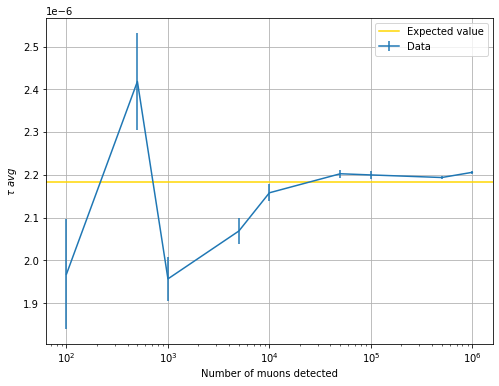

In [8]:
# Single parameter errorbar
plt.figure(figsize = (8,6))
#plt.errorbar(n_mus, mmr_n_mu.avgs, mmr_n_mu.avgs_u, label = 'Data')
plt.errorbar(mus, avgs, d_avgs, label = 'Data')
plt.axhline(1/(1/tau_plus + cap_rate/(charge_ratio + 1)) , label='Expected value', color = 'gold')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel(r'$\tau$ $avg$')
plt.xscale('log')
plt.legend()
plt.show()

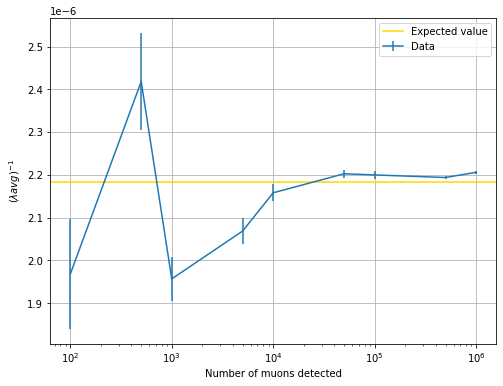

In [117]:
# Single parameter errorbar
plt.figure(figsize = (8,6))
#plt.errorbar(n_mus, mmr_n_mu.avgs, mmr_n_mu.avgs_u, label = 'Data')
plt.errorbar(mus, avgs, d_avgs, label = 'Data')
plt.axhline(1/(1/tau_plus + cap_rate/(charge_ratio + 1)) , label='Expected value', color = 'gold')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel(r'$(\lambda avg)^{-1}$')
plt.xscale('log')
plt.legend()
plt.show()

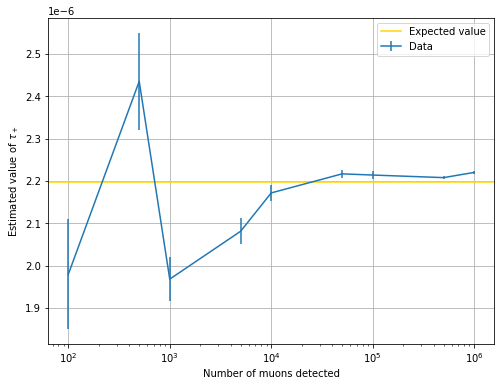

In [118]:
# Single parameter tau_+ errorbar
plt.figure(figsize = (8,6))
plt.errorbar(n_mus, mmr_n_mu.avg_ps, mmr_n_mu.avg_ps_u, label = 'Data')
plt.axhline(tau_plus , label='Expected value', color = 'gold')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel(r'Estimated value of $\tau_+$')
plt.xscale('log')
plt.legend()
plt.show()

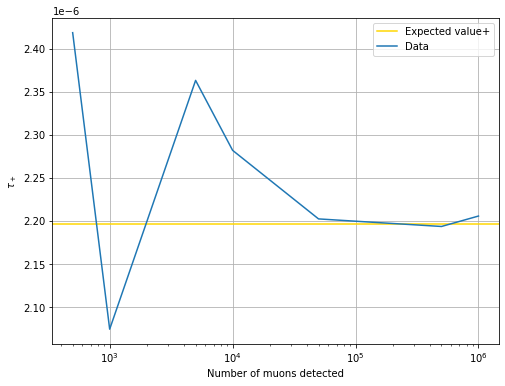

In [122]:
# Double parameter tau_+ plot
plt.figure(figsize = (8,6))
#plt.errorbar(n_mus, mmr_n_mu.tau_ps, mmr_n_mu.tau_ps_u, label = 'Data')
plt.errorbar(n_mus, mmr_n_mu.tau_ps, label = 'Data')
#plt.plot(mus, tps, label = 'Data')
#plt.plot(n_mus, mmr_n_mu.tau_ps_u, label = 'Uncertainty upon data')
plt.axhline(tau_plus, label = 'Expected value+', color = 'gold')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel(r'$\tau_+$')
plt.xscale('log')
plt.legend()
plt.show()

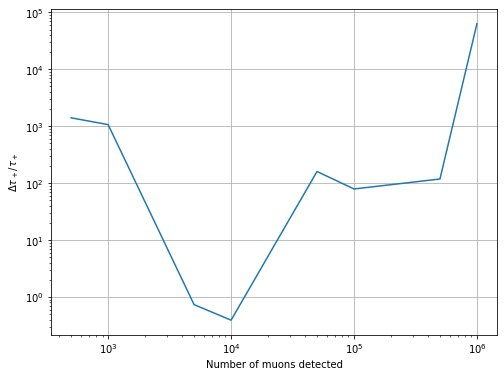

In [124]:
# Double parameter tau_+ error
plt.figure(figsize = (8,6))
#plt.errorbar(n_mus, mmr_n_mu.tau_ms, mmr_n_mu.tau_ms_u, label = 'Data')
#plt.plot(mus, np.array(dtps)/np.array(tps), label = 'Data')
plt.plot(mus, np.array(mmr_n_mu.tau_ms_u)/np.array(mmr_n_mu.tau_ms), label = 'Data')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel(r'$\Delta \tau_+/\tau_+$')
plt.xscale('log')
plt.yscale('log')
plt.show()

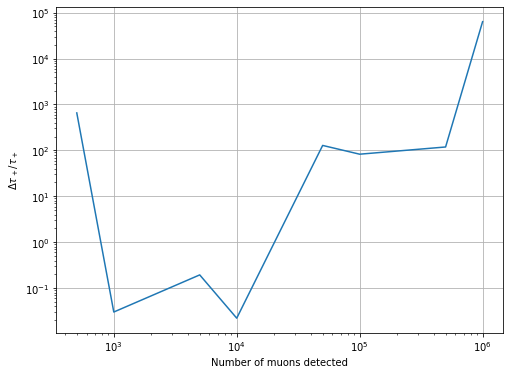

In [127]:
# Double parameter tau_+ error
plt.figure(figsize = (8,6))
#plt.errorbar(n_mus, mmr_n_mu.tau_ps, mmr_n_mu.tau_ps_u, label = 'Data')
plt.plot(n_mus, np.array(mmr_n_mu.tau_ps_u)/np.array(mmr_n_mu.tau_ps), label = 'Uncertainty')
#plt.plot(n_mus, mmr_n_mu.tau_ps_u, label = 'Uncertainty upon data')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel(r'$\Delta \tau_+/\tau_+$')
plt.xscale('log')
plt.yscale('log')
plt.show()

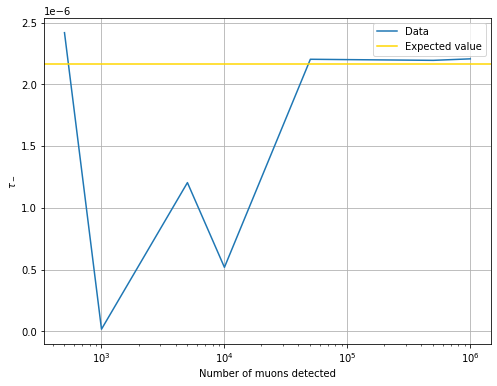

In [61]:
# Double parameter tau_- errorbar
plt.figure(figsize = (8,6))
#plt.errorbar(mus, mmr_n_mu.tau_ms, mmr_n_mu.tau_ms_u, label = 'Data')
#plt.plot(mus, mmr_n_mu.tau_ms, label = 'Data')
plt.plot(mus, tms, label = 'Data')
plt.axhline(tau_minus, label = 'Expected value', color = 'gold')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel(r'$\tau_-$')
plt.xscale('log')
plt.legend()
plt.show()

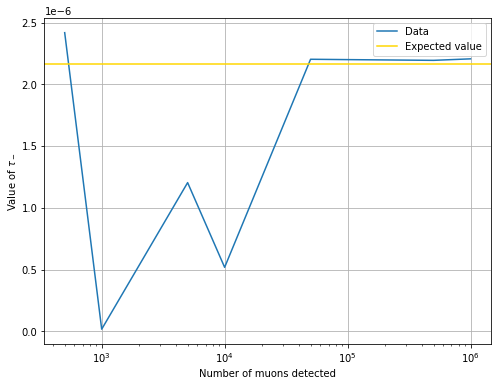

In [128]:
# Double parameter tau_- errorbar
plt.figure(figsize = (8,6))
#plt.errorbar(mus, mmr_n_mu.tau_ms, mmr_n_mu.tau_ms_u, label = 'Data')
plt.plot(mus, mmr_n_mu.tau_ms, label = 'Data')
#plt.plot(mus, tms, label = 'Data')
plt.axhline(tau_minus, label = 'Expected value', color = 'gold')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel(r'Value of $\tau_-$')
plt.xscale('log')
plt.legend()
plt.show()

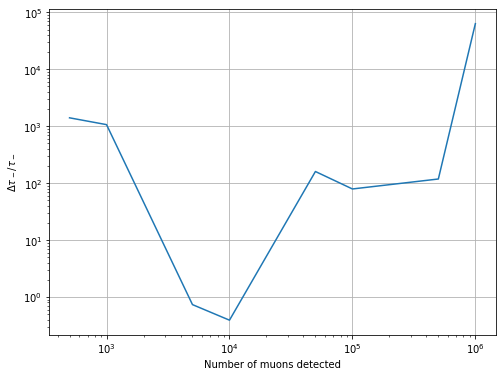

In [129]:
# Double parameter tau_- errorbar
plt.figure(figsize = (8,6))
#plt.errorbar(n_mus, mmr_n_mu.tau_ms, mmr_n_mu.tau_ms_u, label = 'Data')
plt.plot(mus, np.array(mmr_n_mu.tau_ms_u)/np.array(mmr_n_mu.tau_ms), label = 'Data')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel(r'$\Delta \tau_-/\tau_-$')
plt.xscale('log')
plt.yscale('log')
plt.show()

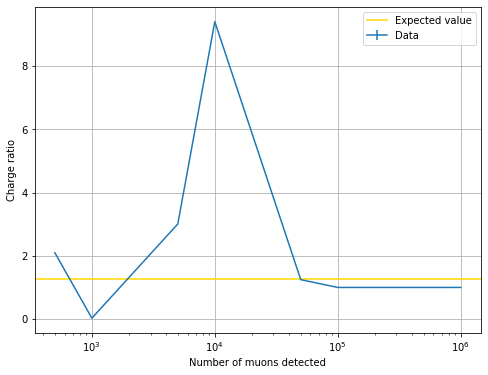

In [130]:
# Rho n errorbar
plt.figure(figsize = (8,6))
plt.errorbar(n_mus, mmr_n_mu.rho_ns, mmr_n_mu.rho_ns_u, label = 'Data')
plt.axhline(charge_ratio, label = 'Expected value', color = 'gold')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel('Charge ratio')
plt.xscale('log')
plt.legend()
plt.show()

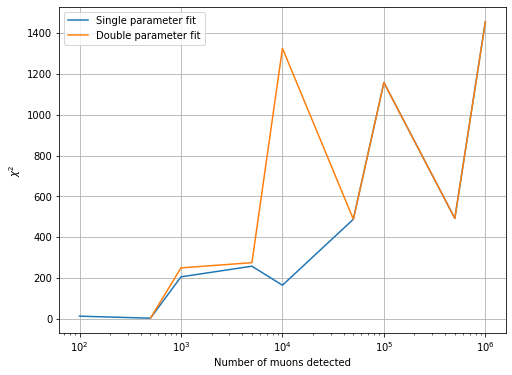

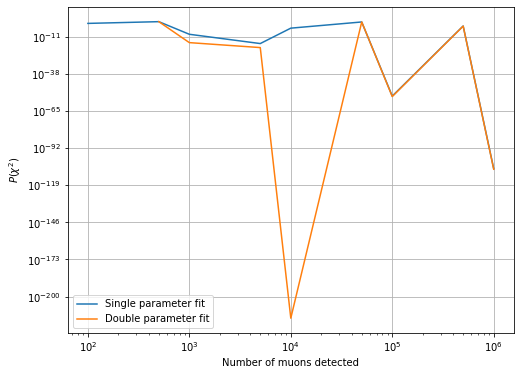

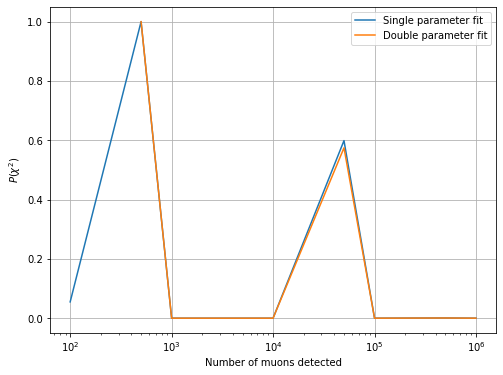

In [64]:
# chi2
plt.figure(figsize = (8,6))
plt.plot(mus, chi2_1, label ='Single parameter fit')
plt.plot(mus, chi2_2, label ='Double parameter fit')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel(r'$\chi^2$')
plt.xscale('log')
plt.legend()
plt.show()


plt.figure(figsize = (8,6))
plt.plot(mus, pchi2_1, label ='Single parameter fit')
plt.plot(mus, pchi2_2, label ='Double parameter fit')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel(r'$P(\chi^2)$')
plt.xscale('log')
plt.legend()
plt.yscale('log')
plt.show()

plt.figure(figsize = (8,6))
plt.plot(mus, pchi2_1, label ='Single parameter fit')
plt.plot(mus, pchi2_2, label ='Double parameter fit')
plt.grid()
plt.xlabel('Number of muons detected')
plt.ylabel(r'$P(\chi^2)$')
plt.xscale('log')
plt.legend()
plt.show()


In [142]:
tm1_1e2 = d1e2.scint_events[-1]
tm1_5e2 = d5e2.scint_events[-1]
tm1_1e3 = d1e3.scint_events[-1]
tm1_5e3 = d5e3.scint_events[-1]
tm1_1e4 = d1e4.scint_events[-1]
tm1_5e4 = d5e4.scint_events[-1]
tm1_1e5 = d1e5.scint_events[-1]
tm1_5e5 = d5e5.scint_events[-1]
tm1_1e6 = d1e6.scint_events[-1]

tm1s = [tm1_1e2, tm1_5e2, tm1_1e3, tm1_5e3, tm1_1e4, tm1_5e4, tm1_1e5, tm1_5e5,tm1_1e6]

total_mu = sum(n_mus)
total_iss = sum(tm1s)

avg_rate_s = total_mu/total_iss
avg_rate_m = avg_rate_s*60

avg_rate_m_u = np.sqrt(total_mu)/total_mu * avg_rate_m # poisson stats


print('Average detection rate:',avg_rate_m,'±',avg_rate_m_u)
print(tm1s)

Average detection rate: 5.433597204211058 ± 0.004208930475833041
[179.92377334649436, 902.2538721434888, 1656.033590686352, 9066.463708870277, 18102.856907450965, 339877.62474717037, 931001.2689953601, 5615422.482721142, 11487069.112090407]


In [145]:
times2 = np.array([tres1e2.best, tres5e2.best, tres1e3.best, tres5e3.best, tres1e4.best, tres5e4.best, tres1e5.best, tres5e5.best, tres1e6.best])
mus = np.array([100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000])
total_t = sum(times2)
total_mu = sum(mus)
total_t_u = np.sqrt(total_mu)/total_mu * total_t # poisson stats

print('Average no. of detections per real-time seconds:',total_mu/total_t,'±',total_t_u)
print(times2)

Average no. of detections per real-time seconds: 276.17752095489766 ± 4.674416020989101
[4.15067672e-01 1.90706681e+00 3.61337128e+00 1.76692368e+01
 3.70061177e+01 1.79704003e+02 3.62200350e+02 1.80278356e+03
 3.62922566e+03]


### 3.2 - Testing dependence upon detector geometry

#### 3.2.1 - Testing $r_d$

In [ ]:
rds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

res_rd = test_var('det r', rds,other_params = {'N muons':10000})

Running simulations:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:196: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
avgs = np.empty(len(rds))
avgs_u = np.empty(len(rds))

t_ps = np.empty(len(rds))
t_ps_u = np.empty(len(rds))
t_ms = np.empty(len(rds))
t_ms_u = np.empty(len(rds))
rhos_t = np.empty(len(rds))
rhos_t_u = np.empty(len(rds))
rhos_N = np.empty(len(rds))
rhos_N_u = np.empty(len(rds))

props = np.empty(len(rds))
rejs = np.empty(len(rds))

for i, metric in enumerate(res_rd):
    avgs[i] = metric['lifetime avg']
    avgs_u[i] = metric['uncert avg']

    t_ps[i] = metric['lifetime +']
    t_ps_u[i] = metric['uncert -']

    t_ms[i] = metric['lifetime -']
    t_ms_u[i] = metric['uncert -']

    rhos_t[i] = metric['ratio tau']
    rhos_t_u[i] = metric['ratio tau uncert']

    rhos_N[i] = metric['ratio N']
    rhos_N_u[i] = metric['ratio N uncert']

    props[i] = metric['proportion']
    rejs[i] = metric['mu generated'] - metric['detected']

print(avgs)
print(avgs_u,'\n')
print(t_ps)
print(t_ps_u,'\n')
print(t_ms)
print(t_ms_u,'\n')
print(rhos_t)
print(rhos_t_u,'\n')
print(rhos_N)
print(rhos_N_u,'\n')
print(props)
print(rejs)

[1.65613004e-06 1.54498060e-06 1.45004633e-06 1.49596650e-05
 1.06235464e-05 1.33397356e-06 1.31334377e-06 1.28991358e-06
 1.44924876e-06 2.42397223e-06]
[4.20934906e-03 4.52890461e-04 1.95380895e-04 5.43001310e-05
 2.42554386e-05 4.17807988e-08 4.25010392e-08 4.06926165e-08
 1.48978995e-08 1.18029617e-06] 

[1.65613004e-06 1.54498060e-06 1.45004633e-06 1.49596650e-05
 1.06235464e-05 1.82164439e-05 4.85277462e-06 4.17675350e-06
 1.44924876e-06 2.42397223e-06]
[4.19063862e-03 4.09813093e-04 2.61632338e-04 3.62901871e-08
 4.23904192e-08 4.17807988e-08 4.25010392e-08 4.06926165e-08
 6.56012767e-05 1.44437630e-07] 

[1.65593209e-06 1.54495779e-06 1.44982489e-06 1.39043352e-06
 1.37918536e-06 1.33397356e-06 1.31334377e-06 1.28991358e-06
 1.31868159e-08 1.19952180e-06]
[4.19063862e-03 4.09813093e-04 2.61632338e-04 3.62901871e-08
 4.23904192e-08 4.17807988e-08 4.25010392e-08 4.06926165e-08
 6.56012767e-05 1.44437630e-07] 

[  2.40651006   1.6361373    1.15969351  -2.30398555  -2.40252901
   0

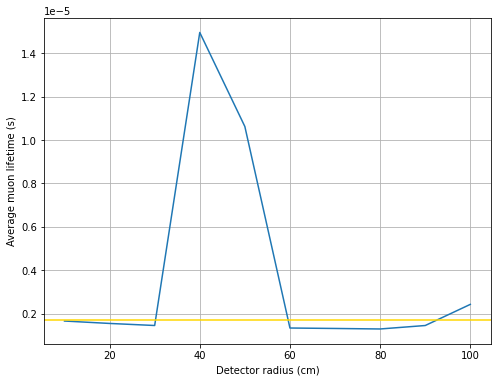

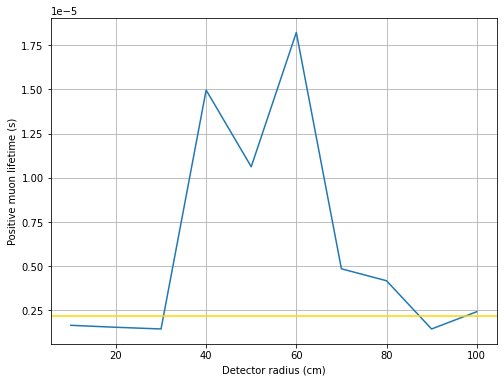

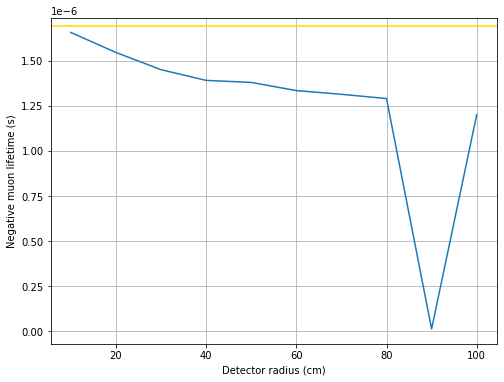

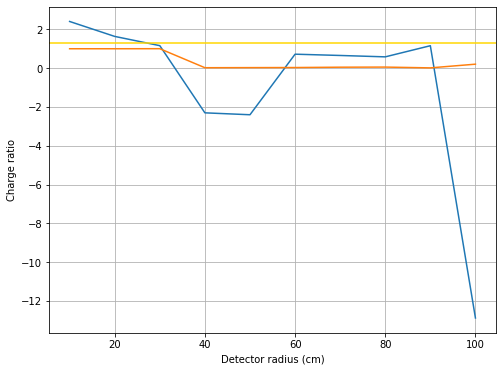

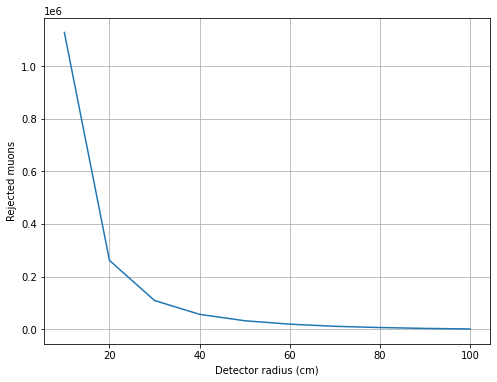

In [ ]:
plt.figure(figsize = (8,6))
#plt.errorbar(rds, avgs, avgs_u)
plt.plot(rds, avgs)
plt.grid()
plt.axhline(tau_average, color = 'gold')
plt.ylabel('Average muon lifetime (s)')
plt.xlabel('Detector radius (cm)')

plt.figure(figsize = (8,6))
#plt.errorbar(rds, t_ps, t_ps_u)
plt.plot(rds, t_ps)
plt.grid()
plt.axhline(tau_plus, color = 'gold')
plt.ylabel('Positive muon lifetime (s)')
plt.xlabel('Detector radius (cm)')

plt.figure(figsize = (8,6))
#plt.errorbar(rds, t_ms, t_ms_u)
plt.plot(rds, t_ms)
plt.grid()
plt.axhline(tau_average, color = 'gold')
plt.ylabel('Negative muon lifetime (s)')
plt.xlabel('Detector radius (cm)')

plt.figure(figsize = (8,6))
#plt.errorbar(rds, rhos, rhos_u)
plt.plot(rds, rhos_t)
plt.plot(rds, rhos_N)
plt.grid()
plt.axhline(Q_ratio, color = 'gold')
plt.ylabel('Charge ratio')
plt.xlabel('Detector radius (cm)')

plt.figure(figsize = (8,6))
plt.plot(rds, rejs)
plt.grid()
plt.ylabel('Rejected muons')
plt.xlabel('Detector radius (cm)')
plt.show()

#### 3.2.2 - Testing $h_d$

In [ ]:
hds = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

res_hd = test_var('det h', hds, other_params = {'N muons':10000, 'plane-det spacing':1})

Running simulations:   0%|          | 0/10 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:196: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
avgs_h = np.empty(len(hds))
avgs_u_h = np.empty(len(hds))

t_ps_h = np.empty(len(hds))
t_ps_u_h = np.empty(len(hds))
t_ms_h = np.empty(len(hds))
t_ms_u_h = np.empty(len(hds))
rhos_t_h = np.empty(len(hds))
rhos_t_u_h = np.empty(len(hds))
rhos_N_h = np.empty(len(hds))
rhos_N_u_h = np.empty(len(hds))

props_h = np.empty(len(hds))
rejs_h = np.empty(len(hds))

for i, metric in enumerate(res_hd):
    avgs_h[i] = metric['lifetime avg']
    avgs_u_h[i] = metric['uncert avg']

    t_ps_h[i] = metric['lifetime +']
    t_ps_u_h[i] = metric['uncert -']

    t_ms_h[i] = metric['lifetime -']
    t_ms_u_h[i] = metric['uncert -']

    rhos_t_h[i] = metric['ratio tau']
    rhos_t_u_h[i] = metric['ratio tau uncert']

    rhos_N_h[i] = metric['ratio N']
    rhos_N_u_h[i] = metric['ratio N uncert']

    props_h[i] = metric['proportion']
    rejs_h[i] = metric['mu generated'] - metric['detected']

print(avgs_h)
print(avgs_u_h,'\n')
print(t_ps_h)
print(t_ps_u_h,'\n')
print(t_ms_h)
print(t_ms_u_h,'\n')
print(rhos_t_h)
print(rhos_t_u_h,'\n')
print(rhos_N_h)
print(rhos_N_u_h,'\n')
print(props_h)
print(rejs_h)

[1.74632442e-06 1.69320657e-06 1.67399671e-06 1.69709310e-06
 1.65381234e-06 1.58723788e-06 1.62027736e-06 1.61216189e-06
 1.52993603e-06 1.56083122e-06]
[5.78996800e-02 7.84694588e-03 3.48812044e+00 1.29038832e-02
 3.40199209e-01 1.93952485e-01 6.38435978e-03 1.01742016e-03
 6.94810016e-03 3.33099570e-03] 

[1.74632442e-06 1.69321834e-06 1.67399671e-06 1.69710597e-06
 1.65381234e-06 1.58723824e-06 1.62027736e-06 1.61216189e-06
 1.52993603e-06 1.56083671e-06]
[5.78996762e-02 7.84694588e-03 3.48812045e+00 1.29038832e-02
 3.40235889e-01 1.93952485e-01 6.38952132e-03 9.32410868e-04
 6.94025554e-03 3.33099570e-03] 

[1.74632012e-06 1.69320657e-06 1.67399670e-06 1.69709310e-06
 1.65381229e-06 1.58723788e-06 1.62026585e-06 1.61213986e-06
 1.52993086e-06 1.56083122e-06]
[5.78996762e-02 7.84694588e-03 3.48812045e+00 1.29038832e-02
 3.40235889e-01 1.93952485e-01 6.38952132e-03 9.32410868e-04
 6.94025554e-03 3.33099570e-03] 

[3.31094065 2.73909645 2.560892   2.77681643 2.38722752 1.89592934
 2.

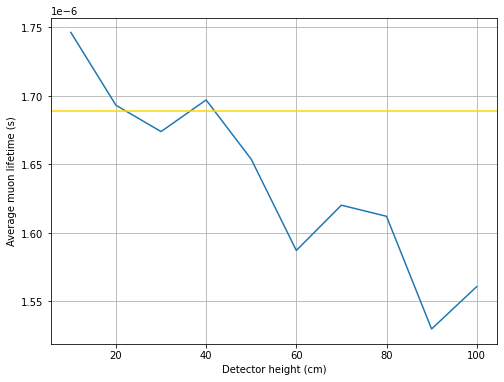

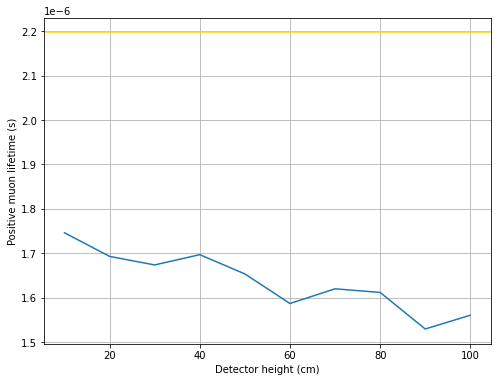

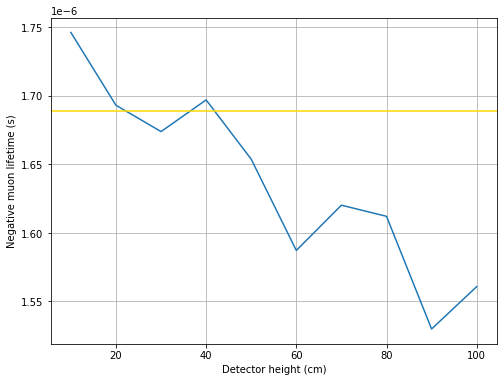

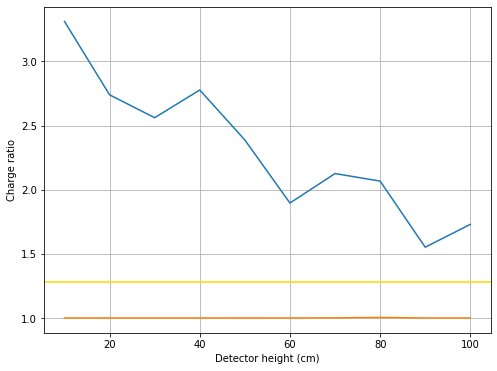

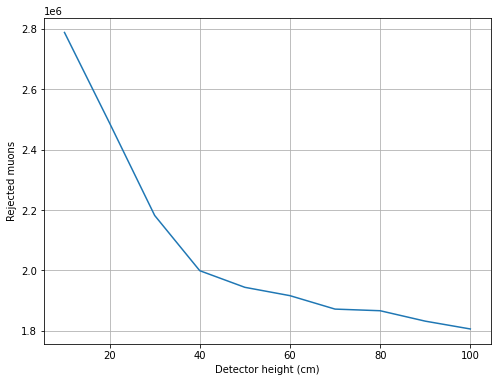

In [ ]:
plt.figure(figsize = (8,6))
#plt.errorbar(hds, avgs_h, avgs_u_h)
plt.plot(hds, avgs_h)
plt.grid()
plt.axhline(tau_average, color = 'gold')
plt.ylabel('Average muon lifetime (s)')
plt.xlabel('Detector height (cm)')

plt.figure(figsize = (8,6))
#plt.errorbar(hds, t_ps_h, t_ps_u_h)
plt.plot(hds, t_ps_h)
plt.grid()
plt.axhline(tau_plus, color = 'gold')
plt.ylabel('Positive muon lifetime (s)')
plt.xlabel('Detector height (cm)')

plt.figure(figsize = (8,6))
#plt.errorbar(hds, t_ms_h, t_ms_u_h)
plt.plot(hds, t_ms_h)
plt.grid()
plt.axhline(tau_average, color = 'gold')
plt.ylabel('Negative muon lifetime (s)')
plt.xlabel('Detector height (cm)')

plt.figure(figsize = (8,6))
#plt.errorbar(hds, rhos_h, rhos_u_h)
plt.plot(hds, rhos_t_h)
plt.plot(hds, rhos_N_h)
plt.grid()
plt.axhline(Q_ratio, color = 'gold')
plt.ylabel('Charge ratio')
plt.xlabel('Detector height (cm)')

plt.figure(figsize = (8,6))
plt.plot(hds, rejs_h)
plt.grid()
plt.ylabel('Rejected muons')
plt.xlabel('Detector height (cm)')
plt.show()

### 3.3 - Testing dependence upon plane position and size

#### 3.3.1 - Plane $z$

In [ ]:
plane_zs = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

res_pz = test_var('det h', plane_zs, other_params = {'N muons':10000, 'plane-det spacing':1})

Running simulations:   0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:196: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
avgs_pz = np.empty(len(plane_zs))
avgs_u_pz = np.empty(len(plane_zs))

t_ps_pz = np.empty(len(plane_zs))
t_ps_u_pz = np.empty(len(plane_zs))
t_ms_pz = np.empty(len(plane_zs))
t_ms_u_pz = np.empty(len(plane_zs))
rhos_t_pz = np.empty(len(plane_zs))
rhos_t_u_pz = np.empty(len(plane_zs))
rhos_N_pz = np.empty(len(plane_zs))
rhos_N_u_pz = np.empty(len(plane_zs))

props_pz = np.empty(len(plane_zs))
rejs_pz = np.empty(len(plane_zs))

for i, metric in enumerate(res_pz):
    avgs_pz[i] = metric['lifetime avg']
    avgs_u_pz[i] = metric['uncert avg']

    t_ps_pz[i] = metric['lifetime +']
    t_ps_u_pz[i] = metric['uncert -']

    t_ms_pz[i] = metric['lifetime -']
    t_ms_u_pz[i] = metric['uncert -']

    rhos_t_pz[i] = metric['ratio tau']
    rhos_t_u_pz[i] = metric['ratio tau uncert']

    rhos_N_pz[i] = metric['ratio N']
    rhos_N_u_pz[i] = metric['ratio N uncert']


    props_pz[i] = metric['proportion']
    rejs_pz[i] = metric['mu generated'] - metric['detected']

print(avgs_pz)
print(avgs_u_pz,'\n')
print(t_ps_pz)
print(t_ps_u_pz,'\n')
print(t_ms_pz)
print(t_ms_u_pz,'\n')
print(rhos_t_pz)
print(rhos_t_u_pz,'\n')
print(rhos_N_pz)
print(rhos_N_u_pz,'\n')
print(props_pz)
print(rejs_pz)

[1.75853521e-06 1.75995771e-06 1.73925288e-06 1.67047584e-06
 1.71076601e-06 1.66842315e-06 1.64292741e-06 1.64967827e-06
 1.55555246e-06 1.61696268e-06 1.55463802e-06]
[3.27651934e-01 4.30615057e-02 6.07052590e-03 4.11184816e-02
 1.89694755e-02 4.79057109e-01 2.20957454e-03 3.84328292e-04
 2.28899512e-03 5.65256294e-03 4.33339923e-02] 

[1.75853521e-06 1.75996366e-06 1.73929083e-06 1.67047584e-06
 1.71076601e-06 1.66842359e-06 1.64300212e-06 1.64967827e-06
 1.55555246e-06 1.61696268e-06 1.55466592e-06]
[0.32765166 0.04306151 0.00607053 0.04126372 0.01895416 0.47905711
 0.00220957 0.00048156 0.00229166 0.00570097 0.04333399] 

[1.75853437e-06 1.75995771e-06 1.73925288e-06 1.67043540e-06
 1.71072804e-06 1.66842315e-06 1.64292741e-06 1.64967824e-06
 1.55544818e-06 1.61688067e-06 1.55463802e-06]
[0.32765166 0.04306151 0.00607053 0.04126372 0.01895416 0.47905711
 0.00220957 0.00048156 0.00229166 0.00570097 0.04333399] 

[3.46198383 3.48012856 3.22715302 2.52963998 2.91430904 2.51161198
 2.

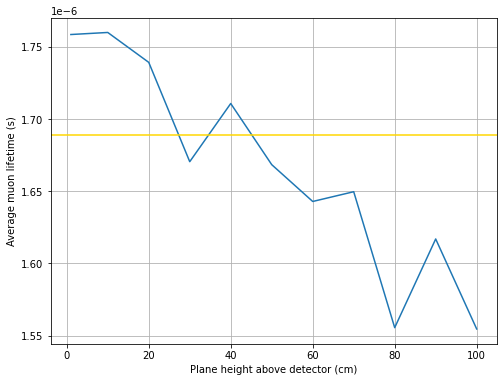

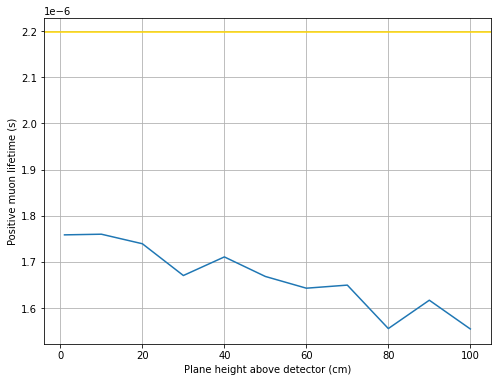

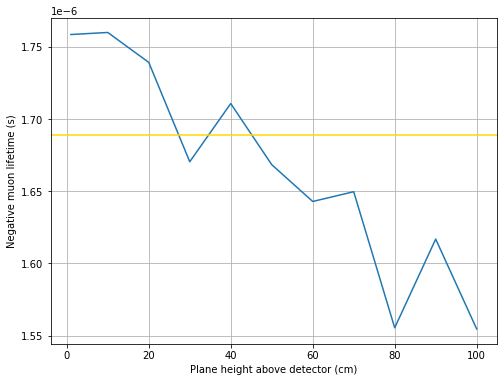

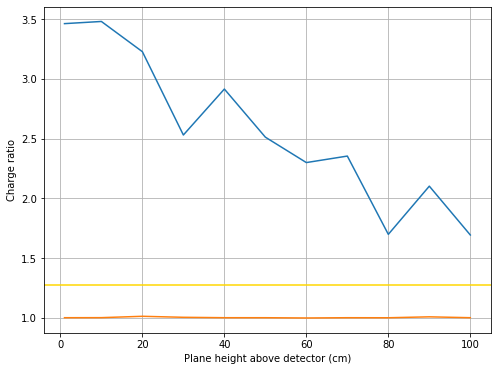

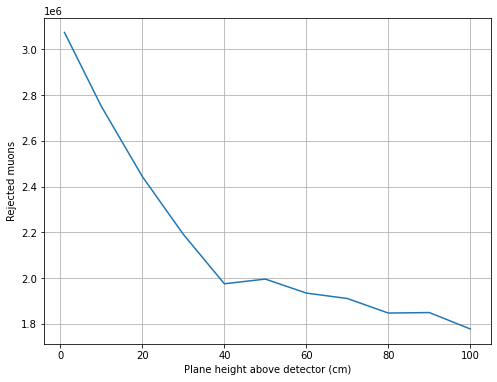

In [ ]:
plt.figure(figsize = (8,6))
#plt.errorbar(hds, avgs_pz, avgs_u_pz)
plt.plot(plane_zs, avgs_pz)
plt.grid()
plt.axhline(tau_average, color = 'gold')
plt.ylabel('Average muon lifetime (s)')
plt.xlabel('Plane height above detector (cm)')

plt.figure(figsize = (8,6))
#plt.errorbar(hds, t_ps_pz, t_ps_u_pz)
plt.plot(plane_zs, t_ps_pz)
plt.grid()
plt.axhline(tau_plus, color = 'gold')
plt.ylabel('Positive muon lifetime (s)')
plt.xlabel('Plane height above detector (cm)')

plt.figure(figsize = (8,6))
#plt.errorbar(hds, t_ms_pz, t_ms_u_pz)
plt.plot(plane_zs, t_ms_pz)
plt.grid()
plt.axhline(tau_average, color = 'gold')
plt.ylabel('Negative muon lifetime (s)')
plt.xlabel('Plane height above detector (cm)')

plt.figure(figsize = (8,6))
#plt.errorbar(hds, rhos_pz, rhos_u_pz)
plt.plot(plane_zs, rhos_t_pz)
plt.plot(plane_zs, rhos_N_pz)
plt.grid()
plt.axhline(Q_ratio, color = 'gold')
plt.ylabel('Charge ratio')
plt.xlabel('Plane height above detector (cm)')

plt.figure(figsize = (8,6))
plt.plot(plane_zs, rejs_pz)
plt.grid()
plt.ylabel('Rejected muons')
plt.xlabel('Plane height above detector (cm)')
plt.show()

In [ ]:
for metric in res_pz:
    present_results(metric)

Lifetimes:
----------
tau_avg = 1.7585352111580999e-06 ± 0.3276519339611665
    -> Error = 6.946881405809999e-08 (0.04112852767503558)
tau - = 1.75853437183796e-06 ± 0.32765166457940176
    -> Error = 7.1853437183796e-07 (0.6908984344595769)
tau + = 1.7585352111580999e-06 ± 0.3276519339611665
    -> Error = 4.3844588884190006e-07 (0.19956743771801227)

Charge ratio:
-------------
rho (tau) = 3.461983825609917
    -> Error = 2.1840794975916937 (1.7091103376876178)

rho (N) = 1.0000000222792067
    -> Error = 0.2779043057390165 (0.21746878826992555)

Proportion:
-----------
N generated = 3083684
N detected = 10000
Proportion = 0.0032428744320105434
Lifetimes:
----------
tau_avg = 1.7599577107817845e-06 ± 0.043061505685368186
    -> Error = 7.089131368178462e-08 (0.04197070867285009)
tau - = 1.7599577107817845e-06 ± 0.043061505685368186
    -> Error = 7.199577107817845e-07 (0.6922670295978697)
tau + = 1.7599636617690586e-06 ± 0.04304026471422682
    -> Error = 4.3701743823094136e-07 (0.19

#### 3.3.2 - Plane $r$

In [ ]:
plane_rs = [10, 50, 100, 250, 500, 1000]

res_pr = test_var('det h', plane_rs, other_params = {'N muons':10000, 'plane-det spacing':1})

Running simulations:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:196: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
avgs_pr = np.empty(len(plane_rs))
avgs_u_pr = np.empty(len(plane_rs))

t_ps_pr = np.empty(len(plane_rs))
t_ps_u_pr = np.empty(len(plane_rs))
t_ms_pr = np.empty(len(plane_rs))
t_ms_u_pr = np.empty(len(plane_rs))
rhos_t_pr = np.empty(len(plane_rs))
rhos_t_u_pr = np.empty(len(plane_rs))
rhos_N_pr = np.empty(len(plane_rs))
rhos_N_u_pr = np.empty(len(plane_rs))

props_pr = np.empty(len(plane_rs))
rejs_pr = np.empty(len(plane_rs))

for i, metric in enumerate(res_pr):
    avgs_pr[i] = metric['lifetime avg']
    avgs_u_pr[i] = metric['uncert avg']

    t_ps_pr[i] = metric['lifetime +']
    t_ps_u_pr[i] = metric['uncert -']

    t_ms_pr[i] = metric['lifetime -']
    t_ms_u_pr[i] = metric['uncert -']

    rhos_t_pr[i] = metric['ratio tau']
    rhos_t_u_pr[i] = metric['ratio tau uncert']

    rhos_N_pr[i] = metric['ratio N']
    rhos_N_u_pr[i] = metric['ratio N uncert']


    props_pr[i] = metric['proportion']
    rejs_pr[i] = metric['mu generated'] - metric['detected']

print(avgs_pr)
print(avgs_u_pr,'\n')
print(t_ps_pr)
print(t_ps_u_pr,'\n')
print(t_ms_pr)
print(t_ms_u_pr,'\n')
print(rhos_t_pr)
print(rhos_t_u_pr,'\n')
print(rhos_N_pr)
print(rhos_N_u_pr,'\n')
print(props_pr)
print(rejs_pr)

[1.73084901e-06 1.65721146e-06 1.51059962e-06 1.11886164e-06
 1.44033034e-06 1.35596036e-06]
[7.51367553e-03 2.82834633e-03 1.43297811e-01 1.98893620e-07
 2.69677945e-08 2.52874282e-08] 

[1.73084901e-06 1.65723109e-06 1.51059962e-06 2.19402383e-06
 1.44033034e-06 1.35596036e-06]
[7.59069076e-03 2.82834633e-03 1.34387313e-01 1.98893620e-07
 2.05945236e-08 1.56393110e-08] 

[1.73082084e-06 1.65721146e-06 1.51059887e-06 1.11886164e-06
 2.30130720e-07 1.80497234e-07]
[7.59069076e-03 2.82834633e-03 1.34387313e-01 1.98893620e-07
 2.05945236e-08 1.56393110e-08] 

[3.130885   2.41556377 1.44836827 0.15452256 1.11767624 0.79363145]
[3.32683313e-02 9.66203631e-03 2.93517127e-01 6.76508041e-08
 3.05235689e-08 2.02459212e-08] 

[1.01022856 0.9997151  0.93782209 0.34178884 1.86034292 1.57586137]
[6.16477699e-07 2.02458678e-07 7.48126889e-07 8.33146190e-01
 9.54334387e+01 8.79263129e+01] 

[0.00364592 0.00510682 0.00557827 0.00549242 0.0040973  0.00237073]
[2732791. 1948164. 1782670. 1810692. 24306

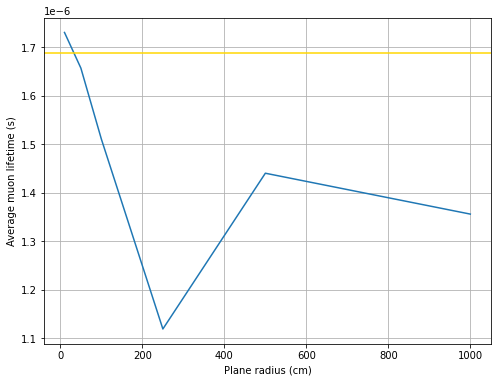

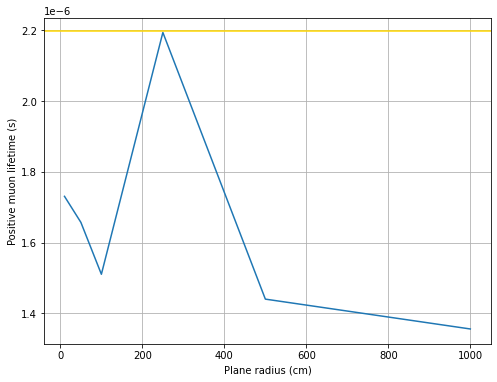

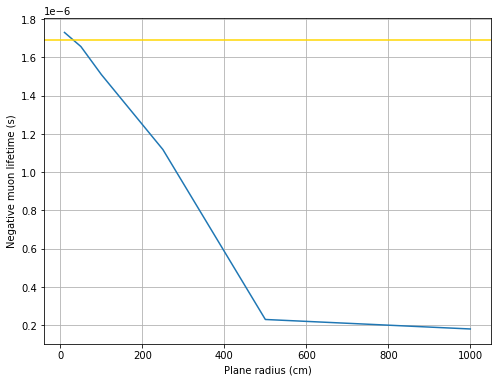

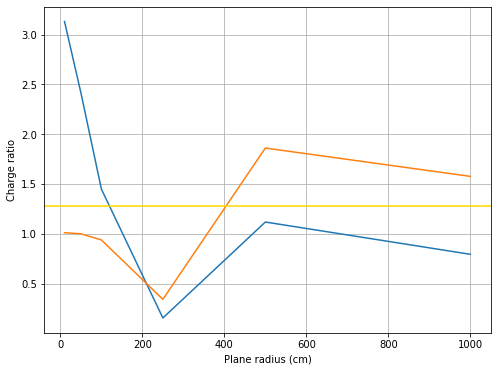

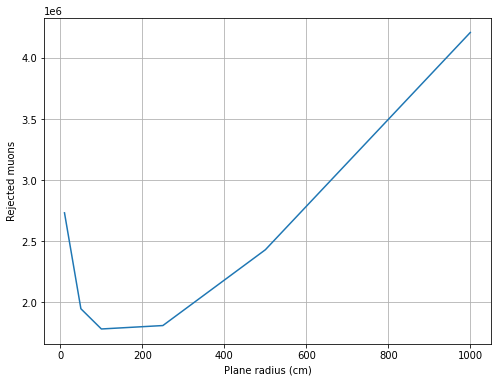

In [ ]:
plt.figure(figsize = (8,6))
#plt.errorbar(hds, avgs_pz, avgs_u_pz)
plt.plot(plane_rs, avgs_pr)
plt.grid()
plt.axhline(tau_average, color = 'gold')
plt.ylabel('Average muon lifetime (s)')
plt.xlabel('Plane radius (cm)')

plt.figure(figsize = (8,6))
#plt.errorbar(hds, t_ps_pz, t_ps_u_pz)
plt.plot(plane_rs, t_ps_pr)
plt.grid()
plt.axhline(tau_plus, color = 'gold')
plt.ylabel('Positive muon lifetime (s)')
plt.xlabel('Plane radius (cm)')

plt.figure(figsize = (8,6))
#plt.errorbar(hds, t_ms_pz, t_ms_u_pz)
plt.plot(plane_rs, t_ms_pr)
plt.grid()
plt.axhline(tau_average, color = 'gold')
plt.ylabel('Negative muon lifetime (s)')
plt.xlabel('Plane radius (cm)')

plt.figure(figsize = (8,6))
#plt.errorbar(hds, rhos_pz, rhos_u_pz)
plt.plot(plane_rs, rhos_t_pr)
plt.plot(plane_rs, rhos_N_pr)
plt.grid()
plt.axhline(Q_ratio, color = 'gold')
plt.ylabel('Charge ratio')
plt.xlabel('Plane radius (cm)')

plt.figure(figsize = (8,6))
plt.plot(plane_rs, rejs_pr)
plt.grid()
plt.ylabel('Rejected muons')
plt.xlabel('Plane radius (cm)')
plt.show()

### 3.4 - Testing dependence upon background rate

#### 3.4.1 - Single rate

In [31]:
backs = [[0.1], [1], [10], [100], [1000]]

# 100,000
dbp1 = detector()
pbp1 = muon_plane(dbp1.height + 10, dbp1.radius*5, p_max = 200, n_pre_gen = 1000000)
sbp1 = system(dbp1,pbp1)

db1 = detector()
pb1 = muon_plane(db1.height + 10, db1.radius*5, p_max = 200, n_pre_gen = 1000000)
sb1 = system(db1,pb1)

db1e1 = detector()
pb1e1 = muon_plane(db1e1.height + 10, db1e1.radius*5, p_max = 200, n_pre_gen = 1000000)
sb1e1 = system(db1e1,pb1e1)

db1e2 = detector()
pb1e2 = muon_plane(db1e2.height + 10, db1e2.radius*5, p_max = 200, n_pre_gen = 1000000)
sb1e2 = system(db1e2,pb1e2)

In [52]:
rejbp1 = sbp1.rejections
for key in rejbp1:
    print(key+'',rejbp1[key])

Path 3842961
Decays before scint 74
Stops in air 2428
Stops in casing 15017
Stops in spacing 40006
Passes through scint 57078
Total 3957564


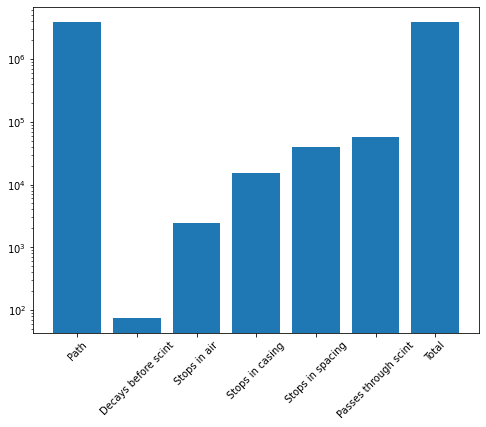

In [59]:
labs = []
cs = []
for key in rejbp1:
    labs.append(key)
    cs.append(rejbp1[key])

plt.figure(figsize = (8,6))
plt.bar(labs, cs)
plt.xticks(rotation = 45)
plt.yscale('log')

In [32]:
tresbp1 = %timeit -oq -r 1 -n 1 resbp1, rejbp1 = sbp1.simulate(100000, treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100, noise_rates=backs[0])
tresb1 = %timeit -oq -r 1 -n 1 resb1, rejb1 = sb1.simulate(100000, treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100, noise_rates=backs[1])
tresb1e1 = %timeit -oq -r 1 -n 1 resb1e1, rejb1e1 = sb1e1.simulate(100000, treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100, noise_rates=backs[2])
tresb1e2 = %timeit -oq -r 1 -n 1 resb1e2, rejb1e2 = sb1e2.simulate(100000, treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100, noise_rates=backs[3])

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

<ipython-input-22-2e56805f87ad>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "gen_noise" failed type inference due to: No implementation of function Function(<built-in function truediv>) found for signature:
 
 >>> truediv(none, float64)
 
There are 6 candidate implementations:
   - Of which 4 did not match due to:
   Overload of function 'truediv': File: <numerous>: Line N/A.
     With argument(s): '(none, float64)':
    No match.
   - Of which 2 did not match due to:
   Operator Overload in function 'truediv': File: unknown: Line unknown.
     With argument(s): '(none, float64)':
    No match for registered cases:
     * (int64, int64) -> float64
     * (int64, uint64) -> float64
     * (uint64, int64) -> float64
     * (uint64, uint64) -> float64
     * (float32, float32) -> float32
     * (float64, float64) -> float64
     * (complex64, complex64) -> complex64
     * (complex128, complex128) -> complex128

During: typing of 

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

<ipython-input-22-2e56805f87ad>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "gen_noise" failed type inference due to: No implementation of function Function(<built-in function truediv>) found for signature:
 
 >>> truediv(none, float64)
 
There are 6 candidate implementations:
      - Of which 4 did not match due to:
      Overload of function 'truediv': File: <numerous>: Line N/A.
        With argument(s): '(none, float64)':
       No match.
      - Of which 2 did not match due to:
      Operator Overload in function 'truediv': File: unknown: Line unknown.
        With argument(s): '(none, float64)':
       No match for registered cases:
        * (int64, int64) -> float64
        * (int64, uint64) -> float64
        * (uint64, int64) -> float64
        * (uint64, uint64) -> float64
        * (float32, float32) -> float32
        * (float64, float64) -> float64
        * (complex64, complex64) -> complex64
        * (complex12

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Single parameter fit:
----------
tau_avg = 2.1970602520174242e-06 ± 7.09924450142203e-09
    -> Error = 1.3920756821575264e-08 (0.006376485264550828)
  -> 𝜒² = 107.30924410315288
  -> P(𝜒²) = 0.20218472396070833 

Est. tau+ (t) = 2.1969811e-06 ± 7.098988748758298e-09
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.2290964011275085e-06 ± 0.0002508372286346691
    -> Error = 3.211530112750853e-08 (0.014407318190125898)
Est. tau+ = 2.21107950796912e-06 ± 7.144544181136191e-09
    -> Error = 1.4098407969119875e-08 (0.006376255543189076)

Double parameter fit:
----------
tau - = 2.1917348934044747e-06 ± 2.487972650811456e-08
    -> Error = 2.6014165525649033e-08 (0.01201178212443306)
tau + = 4.4546505071033774e-05 ± 0.002144572672556765
    -> Error = 4.2349523971033774e-05 (19.27623499857772)
    -> 𝜒² = 83.48196160764991
    -> P(𝜒²) = 0.7729597491817948 

Charge ratios:
--------------
rho (tau) = -401.6560166310623 ± -5.7884608839860475e-05
    -> Error = 402.9326166310623 (315.62949759600673

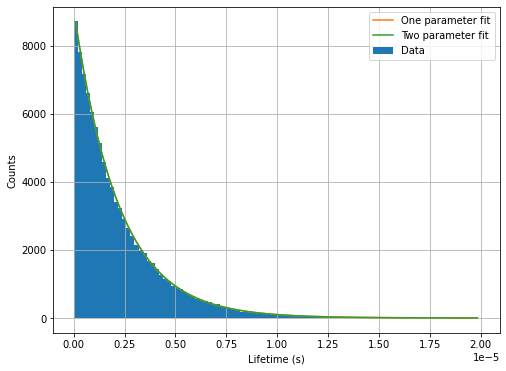

370.21114514700093

In [33]:
# 0.1
mbp1 = sbp1.obtain_metrics(present = True, bins = )
sbp1.plot_result(plot_1_fit = True, plot_2_fit = True)
tresbp1.best

Single parameter fit:
----------
tau_avg = 2.2190652783163877e-06 ± 7.194932880852777e-09
    -> Error = 3.59257831205387e-08 (0.016456018133333163)
  -> 𝜒² = 90.2877393561848
  -> P(𝜒²) = 0.6451803899100734 

Est. tau+ (t) = 2.1969811e-06 ± 7.123328777003292e-09
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.235364417376814e-06 ± 7.247793825834929e-09
    -> Error = 3.83833173768139e-08 (0.017170944065512363)
Est. tau+ = 2.233367679073735e-06 ± 7.241305925616132e-09
    -> Error = 3.638657907373496e-08 (0.016292247539297203)

Double parameter fit:
----------
tau - = 2.219065194849835e-06 ± 0.12491702234767466
    -> Error = 5.334446697100948e-08 (0.024631276915956155)
tau + = 2.219065514325587e-06 ± 0.12498079661174433
    -> Error = 2.208441432558694e-08 (0.010052164001586969)
    -> 𝜒² = 90.22895019517057
    -> P(𝜒²) = 0.5909494357853924 

Charge ratios:
--------------
rho (tau) = -2.450375728237461 ± -2.493299452442594e-08
    -> Error = 3.7269757282374614 (2.919454588937381)

rho (N)

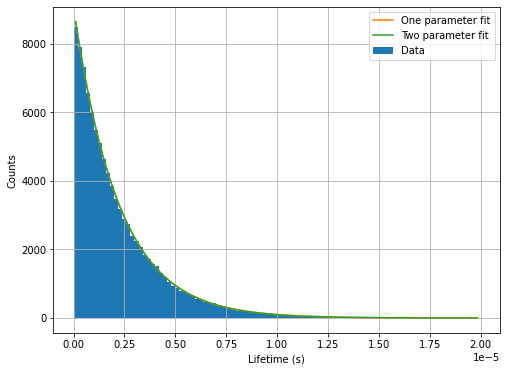

367.6651671630025

In [34]:
# 1
mb1 = sb1.obtain_metrics(present = True)
sb1.plot_result(plot_1_fit = True, plot_2_fit = True)
tresb1.best

Single parameter fit:
----------
tau_avg = 2.1994743529100962e-06 ± 6.875463440882603e-09
    -> Error = 1.6334857714247276e-08 (0.0074822785031342575)
  -> 𝜒² = 93.60805401448003
  -> P(𝜒²) = 0.5500714564659714 

Est. tau+ (t) = 2.1969811e-06 ± 6.867669638178567e-09
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.2153809000610793e-06 ± 6.925226759152682e-09
    -> Error = 1.8399800061079356e-08 (0.008305479234100133)
Est. tau+ = 2.2135245326451504e-06 ± 6.919383706185256e-09
    -> Error = 1.654343264515045e-08 (0.0074737968344905275)

Double parameter fit:
----------
tau - = 2.199469563989846e-06 ± 0.0004723182483933001
    -> Error = 3.374883611102051e-08 (0.015583189317338791)
tau + = 2.1994792599238374e-06 ± 0.0004655721103486267
    -> Error = 2.4981599238374162e-09 (0.0011370875806976293)
    -> 𝜒² = 93.60803361453439
    -> P(𝜒²) = 0.4920072171659784 

Charge ratios:
--------------
rho (tau) = -13.733396364876478 ± -1.3353494786532762e-07
    -> Error = 15.009996364876478 (11.757791

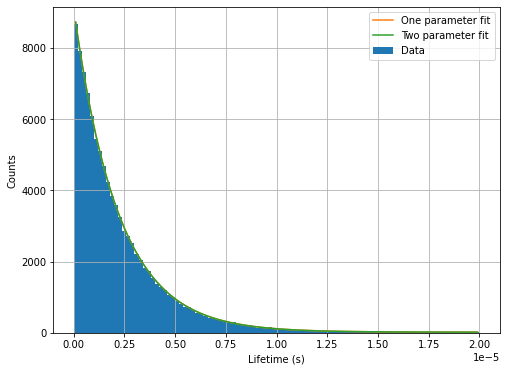

386.2337516160005

In [35]:
# 10
mb1e1 = sb1e1.obtain_metrics(present = True)
sb1e1.plot_result(plot_1_fit = True, plot_2_fit = True)
tresb1e1.best

Single parameter fit:
----------
tau_avg = 2.1941995026054653e-06 ± 1.2655429201086283e-08
    -> Error = 1.1060007409616312e-08 (0.005066102021402953)
  -> 𝜒² = 946.8375511324316
  -> P(𝜒²) = 0.8654580722745825 

Est. tau+ (t) = 2.1969811e-06 ± 1.2671472550373584e-08
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.210089448717007e-06 ± 1.274708725395081e-08
    -> Error = 1.3108348717007175e-08 (0.0059311394498610835)
Est. tau+ = 2.2081821577503046e-06 ± 1.2736076608953524e-08
    -> Error = 1.120105775030466e-08 (0.005072524343605916)

Double parameter fit:
----------
tau - = 2.194199405367717e-06 ± 0.00010930926012605856
    -> Error = 2.8478677488891184e-08 (0.013149746004778782)
tau + = 2.1941996317250286e-06 ± 0.00010925798791762912
    -> Error = 2.78146827497136e-09 (0.0012660410574179997)
    -> 𝜒² = 946.8375400250934
    -> P(𝜒²) = 0.8554181706128963 

Charge ratios:
--------------
rho (tau) = 10.386061671022945 ± 1.8588432837555503e-07
    -> Error = 9.109461671022945 (7.13572118

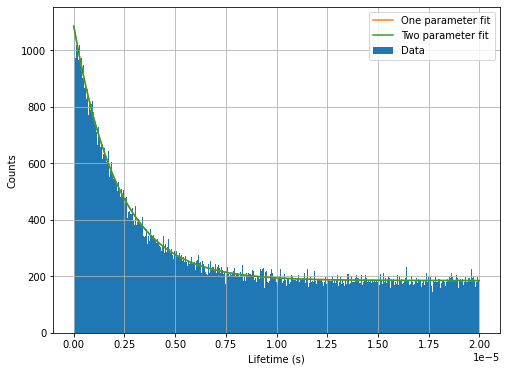

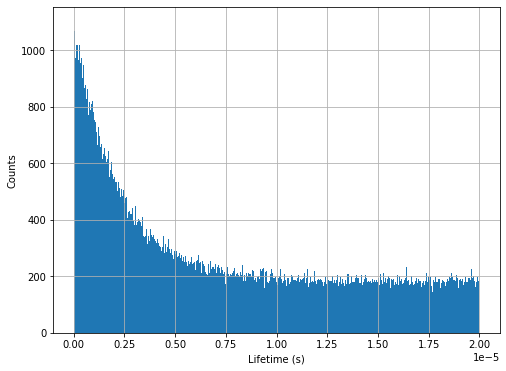

590.1249472390009

In [44]:
# 100
mb1e2 = sb1e2.obtain_metrics(present = True, bins = 1000)
sb1e2.plot_result(bins = 1000, plot_1_fit = True, plot_2_fit = True)
sb1e2.plot_result(bins = 1000)
tresb1e2.best

In [43]:
mmr_bs = multi_metric_result([mbp1, mb1, mb1e1, mb1e2], [0.1, 1, 10, 100])

mmr_bs.print_all()

avgs
[2.19706025e-06 2.21906528e-06 2.19947435e-06 2.19419950e-06]
[7.09924450e-09 7.19493288e-09 6.87546344e-09 1.26554292e-08] 

chi2s 1
[107.3092441   90.28773936  93.60805401 946.83755113]
[0.20218472 0.64518039 0.55007146 0.86545807] 

+ ests t
[2.1969811e-06 2.1969811e-06 2.1969811e-06 2.1969811e-06]
[7.09898875e-09 7.12332878e-09 6.86766964e-09 1.26714726e-08] 

+ ests n
[2.22909640e-06 2.23536442e-06 2.21538090e-06 2.21008945e-06]
[2.50837229e-04 7.24779383e-09 6.92522676e-09 1.27470873e-08] 

+ ests
[2.21107951e-06 2.23336768e-06 2.21352453e-06 2.20818216e-06]
[7.14454418e-09 7.24130593e-09 6.91938371e-09 1.27360766e-08] 

tau-
[2.19173489e-06 2.21906519e-06 2.19946956e-06 2.19419941e-06]
[2.48797265e-08 1.24917022e-01 4.72318248e-04 1.09309260e-04] 

tau+
[4.45465051e-05 2.21906551e-06 2.19947926e-06 2.19419963e-06]
[2.14457267e-03 1.24980797e-01 4.65572110e-04 1.09257988e-04] 

chi2s 2
[ 83.48196161  90.2289502   93.60803361 946.83754003]
[0.77295975 0.59094944 0.49200722 0.

In [ ]:
avgs_backs = np.empty(len(backs))
avgs_u_backs = np.empty(len(backs))

t_ps_backs = np.empty(len(backs))
t_ps_u_backs = np.empty(len(backs))
t_ms_backs = np.empty(len(backs))
t_ms_u_backs = np.empty(len(backs))
rhos_t_backs = np.empty(len(backs))
rhos_t_u_backs = np.empty(len(backs))
rhos_N_backs = np.empty(len(backs))
rhos_N_u_backs = np.empty(len(backs))

props_backs = np.empty(len(backs))
rejs_backs = np.empty(len(backs))

for i, metric in enumerate(res_backs):
    avgs_backs[i] = metric['lifetime avg']
    avgs_u_backs[i] = metric['uncert avg']

    t_ps_backs[i] = metric['lifetime +']
    t_ps_u_backs[i] = metric['uncert -']

    t_ms_backs[i] = metric['lifetime -']
    t_ms_u_backs[i] = metric['uncert -']

    rhos_t_backs[i] = metric['ratio tau']
    rhos_t_u_backs[i] = metric['ratio tau uncert']

    rhos_N_backs[i] = metric['ratio N']
    rhos_N_u_backs[i] = metric['ratio N uncert']


    props_backs[i] = metric['proportion detected']
    rejs_backs[i] = metric['mu generated'] - metric['detected']

print(avgs_backs)
print(avgs_u_backs,'\n')
print(t_ps_backs)
print(t_ps_u_backs,'\n')
print(t_ms_backs)
print(t_ms_u_backs,'\n')
print(rhos_t_backs)
print(rhos_t_u_backs,'\n')
print(rhos_N_backs)
print(rhos_N_u_backs,'\n')
print(props_backs)
print(rejs_backs)

[2.21618157e-06 2.14073182e-06 2.28431905e-06            nan
            nan]
[3.17981713e-08 2.49875799e-08 2.47625885e-08            nan
            nan] 

[2.21618348e-06 2.31117955e-06 2.28432295e-06            nan
            nan]
[           nan 1.47229733e-06 1.66011036e-02            nan
            nan] 

[2.21618071e-06 1.28618175e-06 2.28431547e-06            nan
            nan]
[           nan 1.47229733e-06 1.66011036e-02            nan
            nan] 

[-2.66603895 -0.45066536 -1.37752478         nan         nan]
[-1.19890214e-07 -1.39134634e-08 -4.82403542e-08             nan
             nan] 

[1.21309678 5.11768971 0.99999992        nan        nan]
[           nan 7.97579555e+00 2.30687777e-06            nan
            nan] 

[0.0235893  0.02330899 0.0235308  0.02334441 0.02368086]
[413921. 419019. 414975. 418368. 412282.]


In [ ]:
backs_l = np.empty(len(backs))
for i, a in enumerate(backs):
    backs_l[i] = a[0]

NameError: ignored

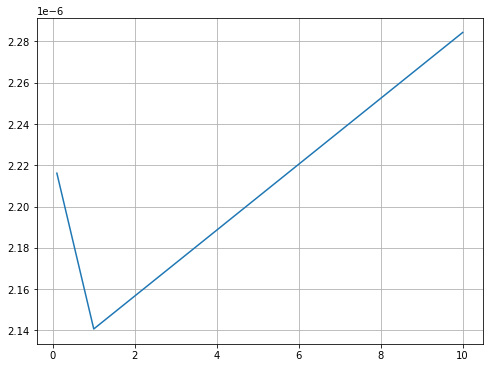

In [ ]:
plt.figure(figsize = (8,6))
#plt.errorbar(hds, avgs_pz, avgs_u_pz)
plt.plot(backs_l, avgs_backs)
plt.grid()
plt.axhline(tau_average, color = 'gold')
plt.ylabel('Average muon lifetime (s)')
plt.xlabel('Background rate (s^-1)')

plt.figure(figsize = (8,6))
#plt.errorbar(hds, t_ps_pz, t_ps_u_pz)
plt.plot(backs_l, t_ps_backs)
plt.grid()
plt.axhline(tau_plus, color = 'gold')
plt.ylabel('Positive muon lifetime (s)')
plt.xlabel('Background rate (s^-1)')

plt.figure(figsize = (8,6))
#plt.errorbar(hds, t_ms_pz, t_ms_u_pz)
plt.plot(backs_l, t_ms_backs)
plt.grid()
plt.axhline(tau_average, color = 'gold')
plt.ylabel('Negative muon lifetime (s)')
plt.xlabel('Background rate (s^-1)')

plt.figure(figsize = (8,6))
#plt.errorbar(hds, rhos_pz, rhos_u_pz)
plt.plot(backs_l, rhos_t_backs)
plt.plot(backs_l, rhos_N_backs)
plt.grid()
plt.axhline(Q_ratio, color = 'gold')
plt.ylabel('Charge ratio')
plt.xlabel('Background rate (s^-1)')

plt.figure(figsize = (8,6))
plt.plot(backs_l, rejs_backs)
plt.grid()
plt.ylabel('Rejected muons')
plt.xlabel('Background rate (s^-1)')
plt.show()

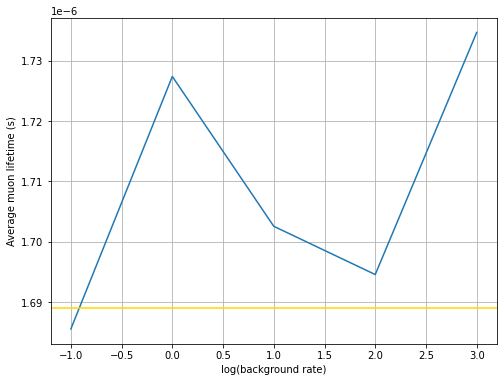

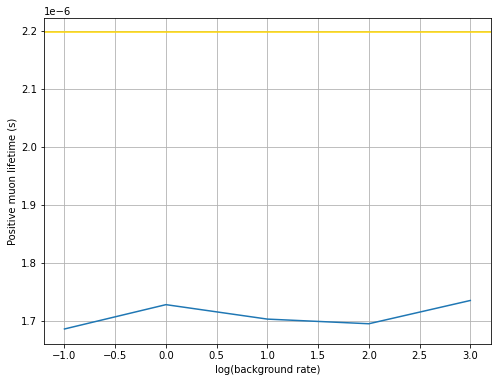

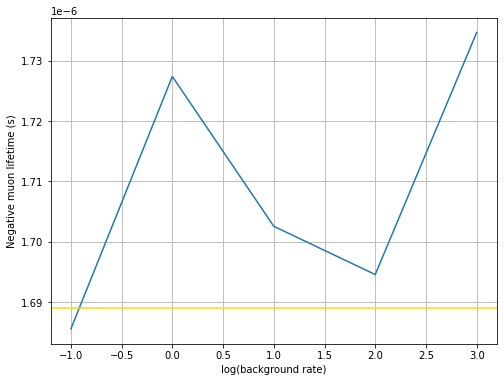

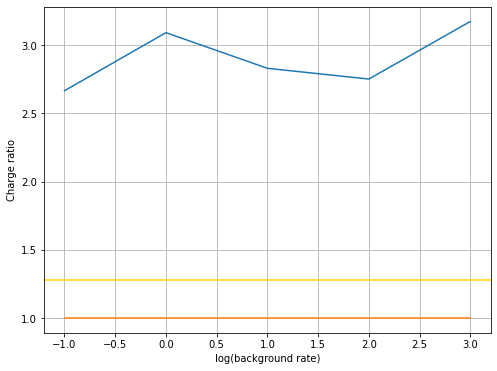

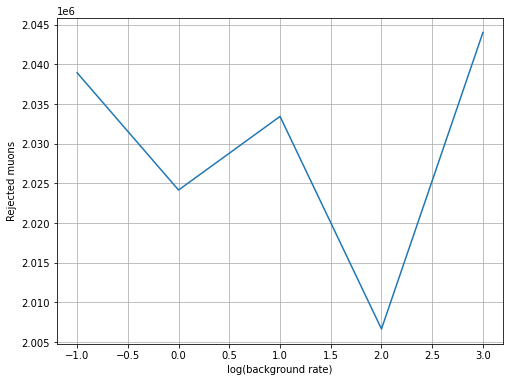

In [ ]:
plt.figure(figsize = (8,6))
#plt.errorbar(hds, avgs_pz, avgs_u_pz)
plt.plot(np.log10(backs_l), avgs_backs)
plt.grid()
plt.axhline(tau_average, color = 'gold')
plt.ylabel('Average muon lifetime (s)')
plt.xlabel('log(background rate)')

plt.figure(figsize = (8,6))
#plt.errorbar(hds, t_ps_pz, t_ps_u_pz)
plt.plot(np.log10(backs_l), t_ps_backs)
plt.grid()
plt.axhline(tau_plus, color = 'gold')
plt.ylabel('Positive muon lifetime (s)')
plt.xlabel('log(background rate)')

plt.figure(figsize = (8,6))
#plt.errorbar(hds, t_ms_pz, t_ms_u_pz)
plt.plot(np.log10(backs_l), t_ms_backs)
plt.grid()
plt.axhline(tau_average, color = 'gold')
plt.ylabel('Negative muon lifetime (s)')
plt.xlabel('log(background rate)')

plt.figure(figsize = (8,6))
#plt.errorbar(hds, rhos_pz, rhos_u_pz)
plt.plot(np.log10(backs_l), rhos_t_backs)
plt.plot(np.log10(backs_l), rhos_N_backs)
plt.grid()
plt.axhline(Q_ratio, color = 'gold')
plt.ylabel('Charge ratio')
plt.xlabel('log(background rate)')

plt.figure(figsize = (8,6))
plt.plot(np.log10(backs_l), rejs_backs)
plt.grid()
plt.ylabel('Rejected muons')
plt.xlabel('log(background rate)')
plt.show()

In [ ]:
for i, metric in enumerate(res_backs):
    print(backs_l[i])
    print('- - - - - - - - - - - - -')
    present_results(metric)
    print('\n--- - - - --- - - - --- - - - ---\n')

0.1
- - - - - - - - - - - - -
Lifetimes:
----------
tau_avg = 1.6855523008581028e-06 ± 0.01008557125672843
    -> Error = 3.5140962418970902e-09 (0.0020804962125411585)
tau - = 1.68554989068296e-06 ± 0.010078564613694342
    -> Error = 6.4554989068296e-07 (0.6207210487336154)
tau + = 1.6855523008581028e-06 ± 0.01008557125672843
    -> Error = 5.114287991418971e-07 (0.23278707274354665)

Charge ratio:
-------------
rho (tau) = 2.6664855522005015
    -> Error = 1.3885812241822784 (1.0866081237362215)

rho (N) = 0.9999894114678541
    -> Error = 0.27791491655036904 (0.21747709156080572)

Proportion:
-----------
N generated = 2048939
N detected = 10000
Proportion = 0.004880574775530165

--- - - - --- - - - --- - - - ---

1.0
- - - - - - - - - - - - -
Lifetimes:
----------
tau_avg = 1.7274111917730874e-06 ± 0.0013806534888981712
    -> Error = 3.8344794673087516e-08 (0.022701768704251443)
tau - = 1.7274111917730874e-06 ± 0.0013806534888981712
    -> Error = 6.874111917730874e-07 (0.66097229

### 3.5 - Testing pre-generation

In [ ]:
d_pg = detector()
p_pg = muon_plane(d_pg.height + 10, d_pg.radius*5, p_max = 250, n_pre_gen = 1000000)
s_pg = system(d_pg,p_pg)

d_pg = detector()
p_pg = muon_plane(d_pg.height + 10, d_pg.radius*5, p_max = 250, n_pre_gen = 1)
s_ng = system(d_pg,p_pg)

tres_pg = %timeit -oq -r 3 out = s_pg.simulate(100000, scint_time_steps = 100, treat_casing = True, track_rejections = False, n_pre_gen = 10000000) # generate 10000 events

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

NameError: ignored

In [ ]:
tres_ng = %timeit -oq -r 3 out = s_ng.simulate(100000, scint_time_steps = 100, treat_casing = True, track_rejections = False, use_pre_gen = False) # generate 10000 events

m_pg = s_pg.obtain_metrics()
m_ng = s_ng.obtain_metrics()

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
# new
print('Pre-gen:',tres_pg.best)
print('Normal :',tres_ng.best)

343.127308632
339.26720778699996


In [ ]:
# old
print(res_pp.best)
print(res_np.best)

1259.0271530369973
1216.0393515370015


In [ ]:
det_pp = detector() 
plane_pp = muon_plane(det_pp.height + 1, 25, E_min = 1, E_max=1500, 
                      n_pre_gen = 100000)

syst_pp = system(det_pp, plane_pp)

det_np = detector()
plane_np = muon_plane(det_np.height + 1, 25, E_min = 1, E_max=1500, 
                      n_pre_gen = 1)

syst_np = system(det_np, plane_np)

res_pp = %timeit -oq out = syst_pp.simulate(100000, scint_time_steps = 1000, treat_casing = True, track_rejections = False, n_pre_gen = 10000000) # generate 10000 events

res_np = %timeit -oq out = syst_np.simulate(100000, scint_time_steps = 1000, treat_casing = True, track_rejections = False, use_pre_gen = False) # generate 10000 events

metrics_pp = syst_pp.obtain_metrics()
metrics_np = syst_np.obtain_metrics()

print(res_pp.best)
print(res_np.best)

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

235.58048358700034
222.9502356539997


### 3.6 - Testing dependence of results on ```n_muons```

In [ ]:
mus = [1000, 10000, 100000]

res_mu = test_var('N muons', mus, other_params = {'det r':1000,
                                                  'plane r':10000,
                                                  'E min':1,
                                                  'E max':1500,
                                                  'plane-det spacing':0.5})

Running simulations:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:196: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
avgs_mus = np.empty(len(mus))
avgs_u_mus = np.empty(len(mus))

t_ps_mus = np.empty(len(mus))
t_ps_u_mus = np.empty(len(mus))
t_ms_mus = np.empty(len(mus))
t_ms_u_mus = np.empty(len(mus))
rhos_t_mus = np.empty(len(mus))
rhos_t_u_mus = np.empty(len(mus))
rhos_N_mus = np.empty(len(mus))
rhos_N_u_mus = np.empty(len(mus))

props_mus = np.empty(len(mus))
rejs_mus = np.empty(len(mus))

for i, metric in enumerate(res_mu):
    avgs_mus[i] = metric['lifetime avg']
    avgs_u_mus[i] = metric['uncert avg']

    t_ps_mus[i] = metric['lifetime +']
    t_ps_u_mus[i] = metric['uncert -']

    t_ms_mus[i] = metric['lifetime -']
    t_ms_u_mus[i] = metric['uncert -']

    rhos_t_mus[i] = metric['ratio tau']
    rhos_t_u_mus[i] = metric['ratio tau uncert']

    rhos_N_mus[i] = metric['ratio N']
    rhos_N_u_mus[i] = metric['ratio N uncert']


    props_mus[i] = metric['proportion']
    rejs_mus[i] = metric['mu generated'] - metric['detected']

print(avgs_mus)
print(avgs_u_mus,'\n')
print(t_ps_mus)
print(t_ps_u_mus,'\n')
print(t_ms_mus)
print(t_ms_u_mus,'\n')
print(rhos_t_mus)
print(rhos_t_u_mus,'\n')
print(rhos_N_mus)
print(rhos_N_u_mus,'\n')
print(props_mus)
print(rejs_mus)

[4.51811902e-07 1.06472650e-06 2.03514776e-06]
[1.98711866e-07 1.07619842e-07 1.23036532e-07] 

[1.57528227e-06 2.05344239e-06 2.03514776e-06]
[1.98711866e-07 1.07619842e-07 2.93476851e-08] 

[4.51811902e-07 1.06472650e-06 1.04256624e-06]
[1.98711866e-07 1.07619842e-07 2.93476851e-08] 

[-0.71198636  0.04613297 12.99010206]
[-5.13171314e-07  1.07858286e-08  1.79576912e-06] 

[2.15035047 0.33379839 0.36336203]
[11.59929484  1.38307992  5.66127322] 

[0.0100025  0.00976746 0.00991132]
[  98975. 1013808. 9989475.]


In [ ]:
#mus.append(1000000)
avgs_mus = np.append(avgs_mus,2.187556529693906e-06)
avgs_u_mus = np.append(avgs_u_mus,7.864652657207957e-08)

t_ps_mus = np.append(t_ps_mus,2.187556529693906e-06)
t_ps_u_mus = np.append(t_ps_u_mus,7.864652657207957e-08)

t_ms_mus = np.append(t_ms_mus,1.0665238519334543e-06)
t_ms_u_mus = np.append(t_ms_u_mus,1.2908940463045479e-08)

rhos_t_mus = np.append(rhos_t_mus,257.220460520925)
rhos_t_u_mus = np.append(rhos_t_u_mus,2.2505678954397565e-05)

rhos_N_mus = np.append(rhos_N_mus,0.2607936611939657)
rhos_N_u_mus = np.append(rhos_N_u_mus,10.032750428432896)

props_mus = np.append(props_mus,0.009954236492690867)
rejs_mus = np.append(rejs_mus,100459739 - 1000000)

print(mus,'\n')
print(avgs_mus)
print(avgs_u_mus,'\n')
print(t_ps_mus)
print(t_ps_u_mus,'\n')
print(t_ms_mus)
print(t_ms_u_mus,'\n')
print(rhos_t_mus)
print(rhos_t_u_mus,'\n')
print(rhos_N_mus)
print(rhos_N_u_mus,'\n')
print(props_mus)
print(rejs_mus)

[1000, 10000, 100000, 1000000] 

[4.51811902e-07 1.06472650e-06 2.03514776e-06 2.18755653e-06]
[1.98711866e-07 1.07619842e-07 1.23036532e-07 7.86465266e-08] 

[1.57528227e-06 2.05344239e-06 2.03514776e-06 2.18755653e-06]
[1.98711866e-07 1.07619842e-07 2.93476851e-08 7.86465266e-08] 

[4.51811902e-07 1.06472650e-06 1.04256624e-06 1.06652385e-06]
[1.98711866e-07 1.07619842e-07 2.93476851e-08 1.29089405e-08] 

[-7.11986362e-01  4.61329741e-02  1.29901021e+01  2.57220461e+02]
[-5.13171314e-07  1.07858286e-08  1.79576912e-06  2.25056790e-05] 

[2.15035047 0.33379839 0.36336203 0.26079366]
[11.59929484  1.38307992  5.66127322 10.03275043] 

[0.0100025  0.00976746 0.00991132 0.00995424]
[9.8975000e+04 1.0138080e+06 9.9894750e+06 9.9459739e+07]


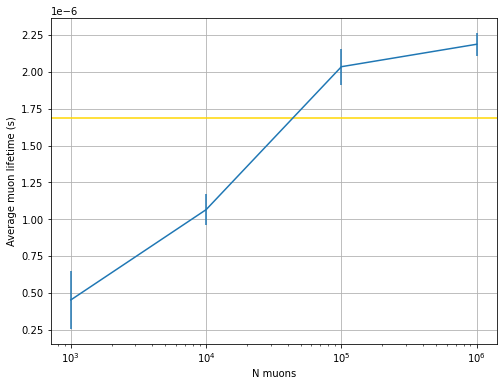

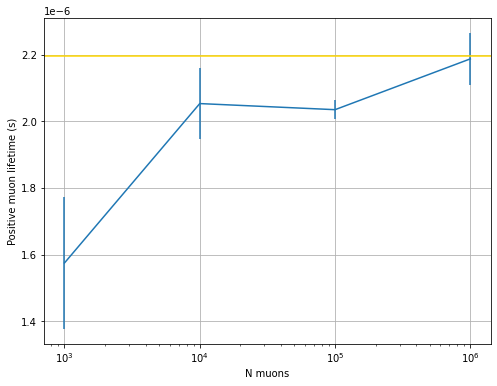

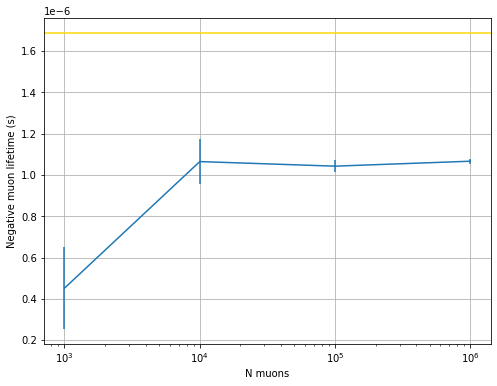

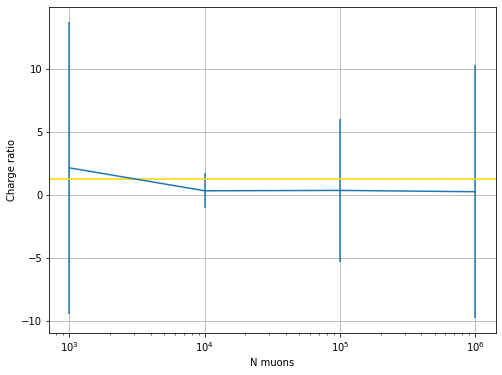

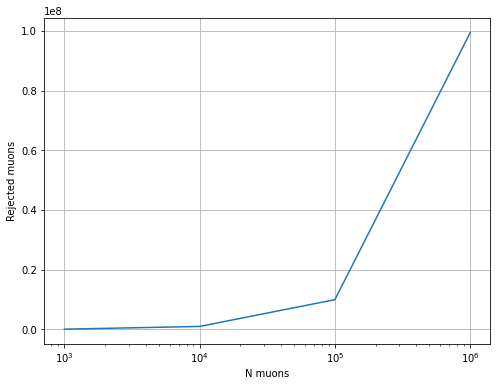

In [ ]:
plt.figure(figsize = (8,6))
plt.errorbar(mus, avgs_mus, avgs_u_mus)
#plt.plot(mus, avgs_mus)
plt.grid()
plt.axhline(tau_average, color = 'gold')
plt.xscale('log')
plt.ylabel('Average muon lifetime (s)')
plt.xlabel('N muons')

plt.figure(figsize = (8,6))
plt.errorbar(mus, t_ps_mus, t_ps_u_mus)
#plt.plot(mus, t_ps_mus)
plt.grid()
plt.axhline(tau_plus, color = 'gold')
plt.xscale('log')
plt.ylabel('Positive muon lifetime (s)')
plt.xlabel('N muons')

plt.figure(figsize = (8,6))
plt.errorbar(mus, t_ms_mus, t_ms_u_mus)
#plt.plot(mus, t_ms_mus)
plt.grid()
plt.axhline(tau_average, color = 'gold')
plt.xscale('log')
plt.ylabel('Negative muon lifetime (s)')
plt.xlabel('N muons')

plt.figure(figsize = (8,6))
#plt.errorbar(mus, rhos_t_mus, rhos_t_u_mus, label = 't')
plt.errorbar(mus, rhos_N_mus, rhos_N_u_mus) #, label = 'N')
#plt.plot(mus, rhos_t_mus)
#plt.plot(mus, rhos_N_mus)
plt.grid()
#plt.legend()
plt.axhline(Q_ratio, color = 'gold')
plt.xscale('log')
plt.ylabel('Charge ratio')
plt.xlabel('N muons')

plt.figure(figsize = (8,6))
plt.plot(mus, rejs_mus)
plt.grid()
plt.xscale('log')
plt.ylabel('Rejected muons')
plt.xlabel('N muons')
plt.show()

### 3.7 - Testing the energy range

In [71]:
d_175 = detector()
p_175 = muon_plane(d_175.height + 10, d_175.radius*5, p_max = 175, n_pre_gen = 1) # corresponding to a T range of ~ 1-99MeV.
s_175 = system(d_175,p_175)

d_250 = detector()
p_250 = muon_plane(d_250.height + 10, d_250.radius*5, p_max = 250, n_pre_gen = 1) # corresponding to a T range of ~ 1-166MeV.
s_250 = system(d_250,p_250)

d_500 = detector()
p_500 = muon_plane(d_500.height + 10, d_500.radius*5, p_max = 500, n_pre_gen = 1) # corresponding to a T range of ~ 1-406MeV.
s_500 = system(d_500,p_500)

d_1000 = detector()
p_1000 = muon_plane(d_1000.height + 10, d_1000.radius*5, p_max = 1000, n_pre_gen = 1) # corresponding to a T range of ~ 1-900MeV.
s_1000 = system(d_1000,p_1000)

In [72]:
res_175, rej_175 = s_175.simulate(100000, treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

res_250, rej_250 = s_250.simulate(100000, treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

res_500, rej_500 = s_500.simulate(100000, treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

res_1000, rej_1000 = s_1000.simulate(100000, treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Single parameter fit:
----------
tau_avg = 2.195359216870972e-06 ± 7.46947854859258e-09
    -> Error = 1.2219721675122879e-08 (0.0055973160221842126)
  -> 𝜒² = 484.37775414034587
  -> P(𝜒²) = 9.811414214731109e-18 

Est. tau+ (t) = 2.1969811e-06 ± 7.47499683517939e-09
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.211307488398872e-06 ± 7.52374640826523e-09
    -> Error = 1.4326388398872073e-08 (0.006478695737265058)
Est. tau+ = 2.2093567037510943e-06 ± 7.517103523668094e-09
    -> Error = 1.237560375109439e-08 (0.005601451196215993)

Double parameter fit:
----------
tau - = 2.1953506999650193e-06 ± 0.0020374954260644444
    -> Error = 2.9629972086193635e-08 (0.013681344831202752)
tau + = 2.1953680738963094e-06 ± 0.002037906000825429
    -> Error = 1.6130261036905351e-09 (0.0007342011743708378)
    -> 𝜒² = 484.3251224022697
    -> P(𝜒²) = 4.968068824782161e-18 

Charge ratios:
--------------
rho (tau) = 18.5378929708318 ± 1.9582389575825713e-07
    -> Error = 17.261292970831796 (13.52130108

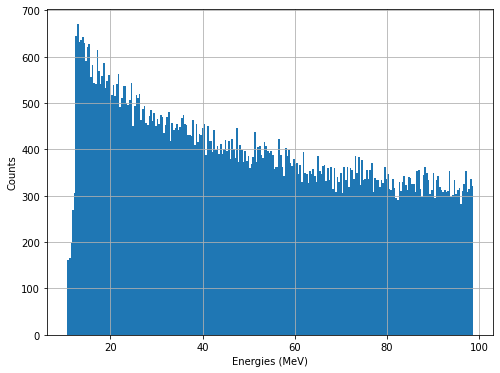

In [73]:
m_175 = s_175.obtain_metrics(present = True,bins=250)
s_175.plot_result('energies', bins = 250)

Single parameter fit:
----------
tau_avg = 2.2294428765485257e-06 ± 9.214393963383567e-09
    -> Error = 4.6303381352676746e-08 (0.02120953858174)
  -> 𝜒² = 495.0127595646177
  -> P(𝜒²) = 6.668302394822723e-19 

Est. tau+ (t) = 2.1969811e-06 ± 9.080227889466529e-09
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.2458911994146683e-06 ± 9.282376404210315e-09
    -> Error = 4.8910099414668335e-08 (0.02177759075213236)
Est. tau+ = 2.2438797974060054e-06 ± 9.274062447289713e-09
    -> Error = 4.689869740600551e-08 (0.020900717346901496)

Double parameter fit:
----------
tau - = 2.2293893194740065e-06 ± 0.00044799179056959467
    -> Error = 6.366859159518084e-08 (0.029398338749585612)
tau + = 2.2294965518617356e-06 ± 0.0004219776718716205
    -> Error = 3.2515451861735684e-08 (0.014800059892065382)
    -> 𝜒² = 494.80850750928573
    -> P(𝜒²) = 3.4375545615402275e-19 

Charge ratios:
--------------
rho (tau) = -1.9913243082620782 ± -2.5949188531711648e-08
    -> Error = 3.2679243082620784 (2.55986

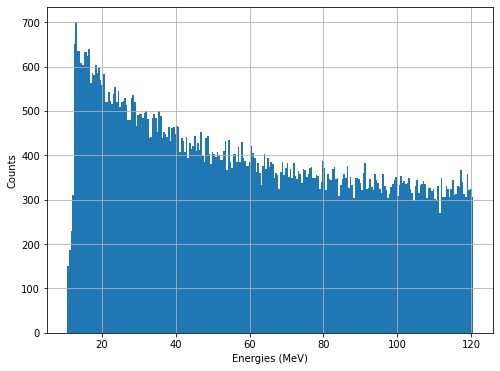

In [77]:
m_200 = s1e5.obtain_metrics(present = True,bins=250)
s1e5.plot_result('energies', bins = 250)

Single parameter fit:
----------
tau_avg = 2.2071724128363304e-06 ± 7.91384113898419e-09
    -> Error = 2.40329176404814e-08 (0.011008420530784916)
  -> 𝜒² = 297.6893110419807
  -> P(𝜒²) = 0.013408622370045926 

Est. tau+ (t) = 2.1969811e-06 ± 7.877300073940672e-09
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.2242121565680756e-06 ± 7.974951342401253e-09
    -> Error = 2.72310565680757e-08 (0.012243012199921069)
Est. tau+ = 2.221321430996425e-06 ± 7.964572600350951e-09
    -> Error = 2.4340330996424887e-08 (0.010957590674081991)

Double parameter fit:
----------
tau - = 2.207172162471335e-06 ± 8.839701323499828e-05
    -> Error = 4.145143459250945e-08 (0.01913978753535239)
tau + = 2.2071727480138452e-06 ± 9.904400013010178e-05
    -> Error = 1.0191648013845293e-08 (0.004638932949330011)
    -> 𝜒² = 297.689784455187
    -> P(𝜒²) = 0.010675943649302577 

Charge ratios:
--------------
rho (tau) = -4.126063651199893 ± -4.617833368462501e-08
    -> Error = 5.402663651199894 (4.232072419865183)

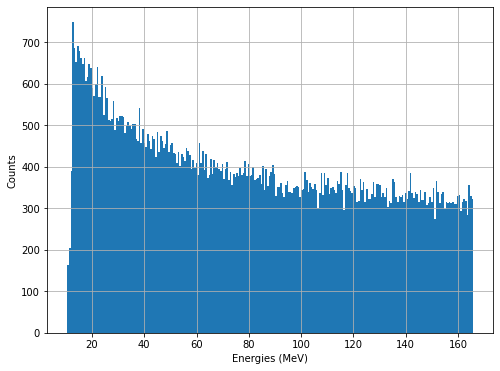

In [74]:
m_250 = s_250.obtain_metrics(present = True,bins=250)
s_250.plot_result('energies', bins = 250)

Single parameter fit:
----------
tau_avg = 2.2624931066044704e-06 ± 1.1338994177559658e-08
    -> Error = 7.93536114086214e-08 (0.03634839257099447)
  -> 𝜒² = -83.13766424437301
  -> P(𝜒²) = 1.0 

Est. tau+ (t) = 2.1969811000000004e-06 ± 1.1010665989883691e-08
    -> Error = 4.235164736271502e-22 (1.9277201502878204e-16)
Est. tau+ (N) = 2.278950159640608e-06 ± 1.1421477351945953e-08
    -> Error = 8.196905964060796e-08 (0.03596790359537066)
Est. tau+ = 2.2773626659815913e-06 ± 1.1413516326028477e-08
    -> Error = 8.038156598159138e-08 (0.035295900465174807)

Double parameter fit:
----------
tau - = 2.2624939849594564e-06 ± 0.05138622836978003
    -> Error = 9.67732570806307e-08 (0.04468408868922515)
tau + = 2.2624950852933235e-06 ± 0.048549613468117425
    -> Error = 6.551398529332355e-08 (0.029820004047064197)
    -> 𝜒² = -82.1571087534027
    -> P(𝜒²) = 1.0 

Charge ratios:
--------------
rho (tau) = -1.4984918395240392 ± -2.402946969793454e-08
    -> Error = 2.7750918395240394 (2.1

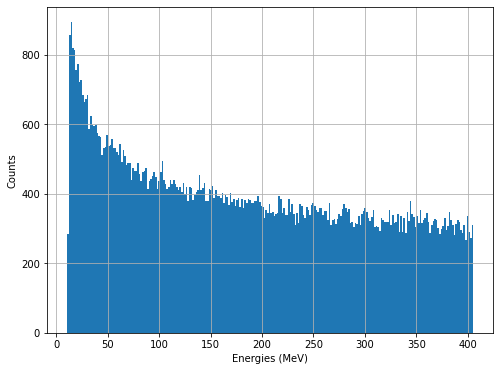

In [75]:
m_500 = s_500.obtain_metrics(present = True,bins=250)
s_500.plot_result('energies', bins = 250)

Single parameter fit:
----------
tau_avg = 2.347530185381752e-06 ± 2.1616573696695783e-08
    -> Error = 1.6439069018590295e-07 (0.07530013109453434)
  -> 𝜒² = -1158.9042157819524
  -> P(𝜒²) = 1.0 

Est. tau+ (t) = 2.1969811000000008e-06 ± 2.0230284643149994e-08
    -> Error = 8.470329472543003e-22 (3.8554403005756403e-16)
Est. tau+ (N) = 2.3657875915678046e-06 ± 2.1784693327421507e-08
    -> Error = 1.6880649156780464e-07 (0.07135319001987697)
Est. tau+ = 2.363542467501968e-06 ± 2.176401830833883e-08
    -> Error = 1.665613675019682e-07 (0.07047107034975647)

Double parameter fit:
----------
tau - = 2.347438809295293e-06 ± 0.0005961033555981378
    -> Error = 1.817180814164672e-07 (0.08390651623602806)
tau + = 2.34762636274473e-06 ± 0.0005939612679324938
    -> Error = 1.5064526274472996e-07 (0.06856921197216033)
    -> 𝜒² = -1162.7038592632784
    -> P(𝜒²) = 1.0 

Charge ratios:
--------------
rho (tau) = -1.225073702000687 ± -3.745109475667648e-08
    -> Error = 2.501673702000687 (1

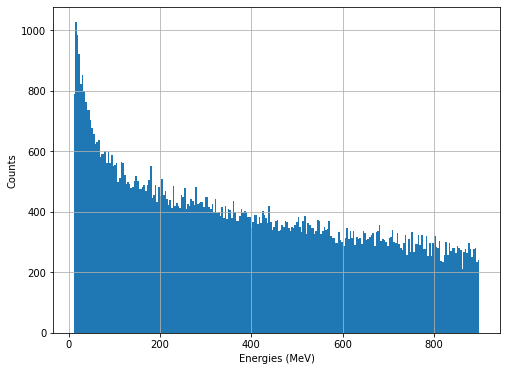

In [76]:
m_1000 = s_1000.obtain_metrics(present = True,bins=250)
s_1000.plot_result('energies', bins = 250)

In [82]:
ens = [175, 200, 250, 500, 1000]
mmr_ens = multi_metric_result([m_175, m_200, m_250, m_500, m_1000], ens)

mmr_ens.print_all()

avgs
[2.19535922e-06 2.22944288e-06 2.20717241e-06 2.26249311e-06
 2.34753019e-06]
[7.46947855e-09 9.21439396e-09 7.91384114e-09 1.13389942e-08
 2.16165737e-08] 

chi2s 1
[  484.37775414   495.01275956   297.68931104   -83.13766424
 -1158.90421578]
[9.81141421e-18 6.66830239e-19 1.34086224e-02 1.00000000e+00
 1.00000000e+00] 

+ ests t
[2.1969811e-06 2.1969811e-06 2.1969811e-06 2.1969811e-06 2.1969811e-06]
[7.47499684e-09 9.08022789e-09 7.87730007e-09 1.10106660e-08
 2.02302846e-08] 

+ ests n
[2.21130749e-06 2.24589120e-06 2.22421216e-06 2.27895016e-06
 2.36578759e-06]
[7.52374641e-09 9.28237640e-09 7.97495134e-09 1.14214774e-08
 2.17846933e-08] 

+ ests
[2.20935670e-06 2.24387980e-06 2.22132143e-06 2.27736267e-06
 2.36354247e-06]
[7.51710352e-09 9.27406245e-09 7.96457260e-09 1.14135163e-08
 2.17640183e-08] 

tau-
[2.19535070e-06 2.22938932e-06 2.20717216e-06 2.26249398e-06
 2.34743881e-06]
[2.03749543e-03 4.47991791e-04 8.83970132e-05 5.13862284e-02
 5.96103356e-04] 

tau+
[2.1953680

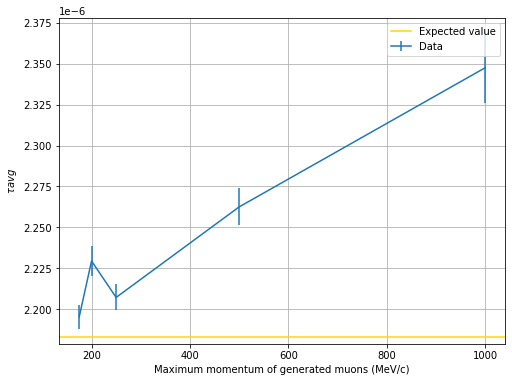

In [86]:
# Single parameter errorbar
plt.figure(figsize = (8,6))
plt.errorbar(ens, mmr_ens.avgs, mmr_ens.avgs_u, label = 'Data')
plt.axhline(1/(1/tau_plus + cap_rate/(charge_ratio + 1)) , label='Expected value', color = 'gold')
plt.grid()
plt.xlabel('Maximum momentum of generated muons (MeV/c)')
plt.ylabel(r'$\tau avg$')
plt.legend()
plt.show()

#### Old

In [ ]:
d_175 = detector()
p_175 = muon_plane(d_175.height + 10, d_175.radius*5, p_max = 175, n_pre_gen = 1) # corresponding to a T range of ~ 1-100MeV.
s_175 = system(d_175,p_175)

res_175, rej_175 = s_175.simulate(100000, treat_casing=True, n_pre_gen = 1000000, track_rejections = True, scint_time_steps = 100)

Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
m_175 = s_175.obtain_metrics(present = True,bins=250)

Single parameter fit:
----------
tau_avg = 2.1933820255069255e-06 ± 7.640610321494806e-09
    -> Error = 1.0242530311076486e-08 (0.004691651785703978)
  -> 𝜒² = 250.4317658897574
  -> P(𝜒²) = 0.40957873587009624 

Est. tau+ (t) = 2.1969811e-06 ± 7.65314763851509e-09
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.2075346144582605e-06 ± 7.689931301678853e-09
    -> Error = 1.0553514458260588e-08 (0.00478067903857103)
Est. tau+ = 2.2073542305859647e-06 ± 7.689282268788746e-09
    -> Error = 1.0373130585964772e-08 (0.0046993502185696395)

Double parameter fit:
----------
tau - = 2.1933806861300234e-06 ± 0.01750824143986327
    -> Error = 2.7659958251197762e-08 (0.012771710541962992)
tau + = 2.1933830102977846e-06 ± 0.014031657929626901
    -> Error = 3.5980897022153095e-09 (0.0016377426743522324)
    -> 𝜒² = 250.42724449368137
    -> P(𝜒²) = 0.37503370973225325 

Charge ratios:
--------------
rho (tau) = 7.796605888277471
    -> Error = 6.5200058882774705 (5.10732092141428)

rho (N) = 1.247766

Single parameter fit:
----------
tau_avg = 2.2212845817317192e-06 ± 8.57477759563389e-09
    -> Error = 3.814508653587028e-08 (0.017472583231539354)
  -> 𝜒² = 239.44759436161033
  -> P(𝜒²) = 1.0 

Est. tau+ (t) = 2.1969811e-06 ± 8.480959382393683e-09
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.237613982812139e-06 ± 8.637814668143392e-09
    -> Error = 4.0632882812139146e-08 (0.018159022567902194)
Est. tau+ = 2.2356156970430923e-06 ± 8.630099695063674e-09
    -> Error = 3.8634597043092347e-08 (0.01728141249598126)

Double parameter fit:
----------
tau - = 2.221247225189873e-06 ± 0.0005970139312889925
    -> Error = 5.552649731104746e-08 (0.025638807717111262)
tau + = 2.2213244314839248e-06 ± 0.0005733419659706406
    -> Error = 2.434333148392483e-08 (0.011080355440438169)
    -> 𝜒² = 237.89887660519543
    -> P(𝜒²) = 1.0 

Charge ratios:
--------------
rho (tau) = -2.3192508939913905
    -> Error = 3.5958508939913907 (2.8167404778249963)

rho (N) = 0.9997904160256784
    -> Error = 0.276

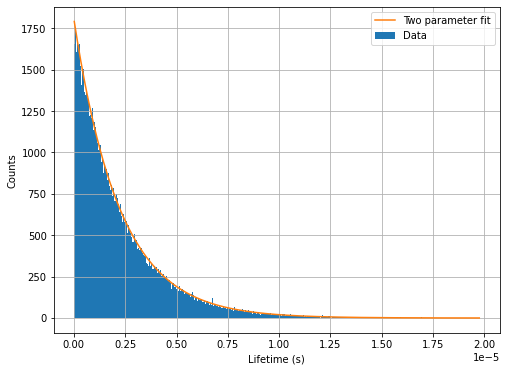

516.0695233030001

In [ ]:
# 100,000, p_max = 250MeV/c
m1e5 = s1e5.obtain_metrics(present = True, bins = 500)
s1e5.plot_result(plot_2_fit = True, bins = 500)
tres1e5.best

### 3.8 - Testing keep passing mu

In [36]:
d_kpm = detector()
p_kpm = muon_plane(d_kpm.height + 10, d_kpm.radius*5, p_max = 250, n_pre_gen = 1000000) # corresponding to a T range of ~ 1-100MeV.
s_kpm = system(d_kpm,p_kpm)

res_kpm, rej_kpm = s_kpm.simulate(100000, treat_casing=True, n_pre_gen = 1000000,
                                  track_rejections = True, scint_time_steps = 100,
                                  keep_passing_mu = True)



Generating muons:   0%|          | 0/100000 [00:00<?, ?it/s]

Single parameter fit:
----------
tau_avg = 2.193427804113695e-06 ± 9.661374300619386e-09
    -> Error = 1.0288308917845826e-08 (0.004712620948173934)
  -> 𝜒² = 260.784197252066
  -> P(𝜒²) = 0.2471347300050564 

Est. tau+ (t) = 2.1969811e-06 ± 9.677025475261329e-09
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.1948366195622153e-06 ± 1.2548057042871707e-05
    -> Error = 2.1444804377846808e-09 (0.0009770569793994149)
Est. tau+ = 2.207400594291092e-06 ± 9.722920140274865e-09
    -> Error = 1.04194942910919e-08 (0.004720255271308435)

Double parameter fit:
----------
tau - = 1.1877945427909392e-06 ± 1.6632908412796176e-06
    -> Error = 9.779261850878864e-07 (0.451547686873597)
tau + = 2.240115209760452e-06 ± 1.1923797854082717e-07
    -> Error = 4.313410976045222e-08 (0.019633354952599377)
    -> 𝜒² = 313.68830894075467
    -> P(𝜒²) = 0.001718454120759628 

Charge ratios:
--------------
rho (tau) = 7.91012222656507
    -> Error = 6.63352222656507 (5.196241756670116)

rho (N) = 21.45105770547

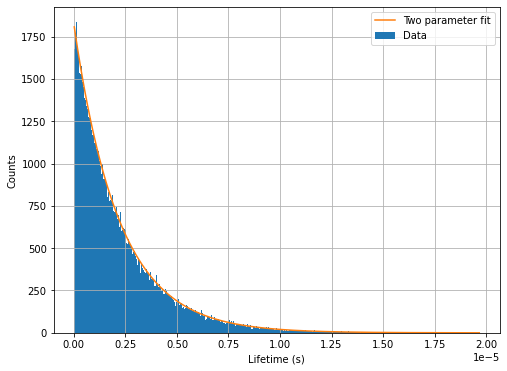

In [42]:
m_kpm = s_kpm.obtain_metrics(present = True,bins=250)
s_kpm.plot_result(bins = 500, plot_2_fit = True)

In [ ]:
m_kpm = s_kpm.obtain_metrics(present = True,bins=250)
s_kpm.plot_result()

Single parameter fit:
----------
tau_avg = 2.1827136320562097e-06 ± 7.789966392953695e-09
    -> Error = 4.2586313963924373e-10 (0.00019506913808136646)
  -> 𝜒² = 290.5950852843208
  -> P(𝜒²) = 0.026799239226938807 

Est. tau+ (t) = 2.1969811e-06 ± 7.8408860803654e-09
    -> Error = 0.0 (0.0)
Est. tau+ (N) = 2.1852699253309003e-06 ± 8.773574503931907e-06
    -> Error = 1.1711174669099609e-08 (0.005359143295456403)
Est. tau+ = 2.1965498201348607e-06 ± 7.839346869877615e-09
    -> Error = 4.3127986513922143e-10 (0.0001963442218272756)

Double parameter fit:
----------
tau - = 1.3332917987092022e-06 ± 1.1284267198086188e-06
    -> Error = 8.324289291696235e-07 (0.3843657764613678)
tau + = 2.259536126743537e-06 ± 1.4368362490478137e-07
    -> Error = 6.255502674353712e-08 (0.028473174732152738)
    -> 𝜒² = 1670.108250458903
    -> P(𝜒²) = 1.066037802864658e-210 

Charge ratios:
--------------
rho (tau) = 1.2082159667066565
    -> Error = 0.06838403329334364 (0.05356731418873854)

rho (N) =

## 4 - Testing

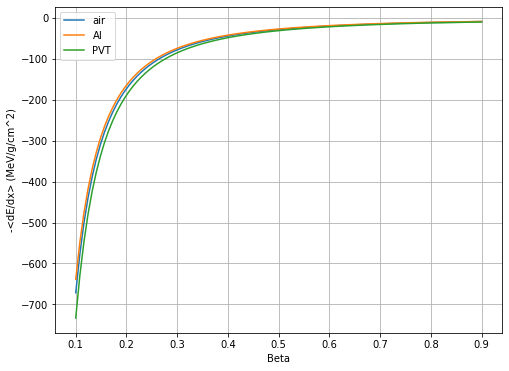

In [ ]:
d = detector()
vs = np.linspace(0.1,0.9,100)

dEs_air = np.empty_like(vs)
lns_air = np.empty_like(vs)
dens_air = np.empty_like(vs)

dEs_Al = np.empty_like(vs)
lns_Al = np.empty_like(vs)
dens_Al = np.empty_like(vs)

dEs_PVT = np.empty_like(vs)
lns_PVT = np.empty_like(vs)
dens_PVT = np.empty_like(vs)
for i, v in enumerate(vs):
    dEs_air[i], lns_air[i], dens_air[i] = Bethe_Bloch(air_properties, v*c_cms, multi_return=True)
    dEs_Al[i], lns_Al[i], dens_Al[i] = Bethe_Bloch(d.material, v*c_cms, multi_return=True)
    dEs_PVT[i], lns_PVT[i], dens_PVT[i] = Bethe_Bloch(d.scint['material'], v*c_cms, multi_return=True)

plt.figure(figsize = (8,6))
plt.grid()
# ln term
#plt.plot(vs, lns_air, label = 'ln term')
#plt.plot(vs, lns_Al, label = 'ln term')
#plt.plot(vs, lns_PVT, label = 'ln term')

# density term
#plt.plot(vs, -dens_air, label = 'dens term')
#plt.plot(vs, -dens_Al, label = 'dens term')
#plt.plot(vs, -dens_PVT, label = 'dens term')

# dE/dx
plt.plot(vs, dEs_air/air_properties['density'], label = 'air')
plt.plot(vs, dEs_Al/d.material['density'], label = 'Al')
plt.plot(vs, dEs_PVT/d.scint['material']['density'], label = 'PVT')

plt.legend()
plt.ylabel('-<dE/dx> (MeV/g/cm^2)')
plt.xlabel('Beta')
plt.show()


In [ ]:
def real_output(events, timeout = 20E-6):

    start_t = round(time.time()) # first second (in unix time)
    last_t = start_t + round(events[-1]) # last second (in unix time)
    #last_t = round(events[-1]) # last second (relative to start time of syst)

    seconds = np.arange(start_t, last_t+1) # all seconds 
    #seconds = np.arange(last_t+1) # all seconds from start time of syst

    events.sort() # ensure time ordering
    out = np.zeros((last_t - start_t + len(events) - 1,2), dtype = int) # for output - max possible size
    
    
    event_secs = np.floor(events) # seconds at which each event occurred

    just_measured = False
    c = 0

    for i, t_s in enumerate(seconds):

        # check for timeouts from previous seconds
        if c > 0:
            out[i][0] = 4000+c
            out[i][1] = t_s
            c = 0 # reset counter

        # if we've already filled this row of the array, move on to the next
        if out[i][1] > 0:
            continue
        
        # check if there was a detection this second
        t_inds = np.where(event_secs == t_s)[0]

        # if there was a detection, check if it passes the timeout check
        for t_i in t_inds:
            c = 0 # counter only counts for each second
            # if we've already used an event in a lifetime calculation, don't use it again
            if just_measured:
                just_measured = False
                continue

            # if less than timeout, record the time difference.
            if events[t_i+1] - events[t_i] <= timeout:
                if c > 0:
                    # if we've had timeouts before this, record those
                    out[i][0] = 4000+c
                    out[i][1] = t_s
                    c = 0 # reset counter

                    out[i+1][0] = round((events[t_i+1] - events[t_i])*1e9) # measurement in nanosecs
                    out[i+1][1] = t_s
                else:
                    out[i][0] = round((events[t_i+1] - events[t_i])*1e9) # measurement in nanosecs
                    out[i][1] = t_s
                    c = 0 # reset counter

                just_measured = True # skip the next interval (don't use events twice)
            else:
                c += 1

    return out

([0, 1, 2, 3, 4, 5, 6], <a list of 7 Text major ticklabel objects>)

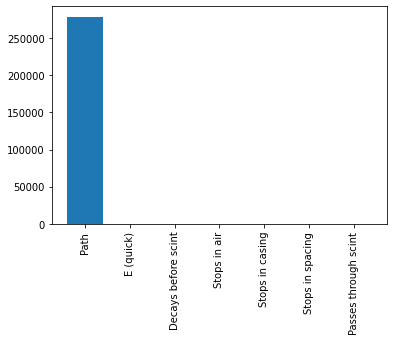

In [ ]:
ks = []
vs = []

for key in rej:
    #if key == 'Path':
    #    continue
    if key == 'Total':
        continue
    ks.append(key)
    vs.append(rej[key])

plt.bar(ks,vs)
plt.xticks(rotation = 'vertical')

In [ ]:
print(100/rej['Path'])

0.00035929606714524905


#### 4.1 - Testing background

Generating muons:   0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:196: RuntimeWarning: invalid value encountered in sqrt


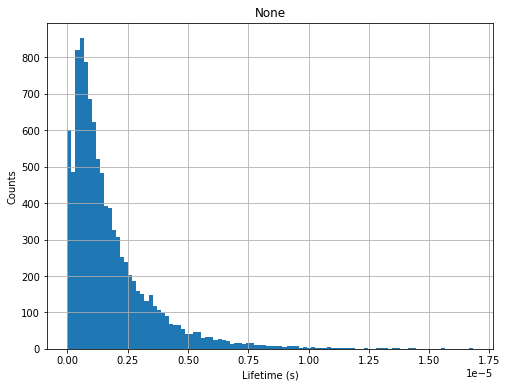

tau_avg = 2.090716442975782e-06 ± 0.0021096797926380595
    >Err 0.23779411310614249 
- - - - -
tau_pos = 2.090728137615317e-06 ± 0.002108892006846094
    >Err 0.04836316633979371
tau_neg = 2.090716442975782e-06 ± 0.0021096797926380595
    >Err 1.0103042720920978


Generating muons:   0%|          | 0/10000 [00:00<?, ?it/s]

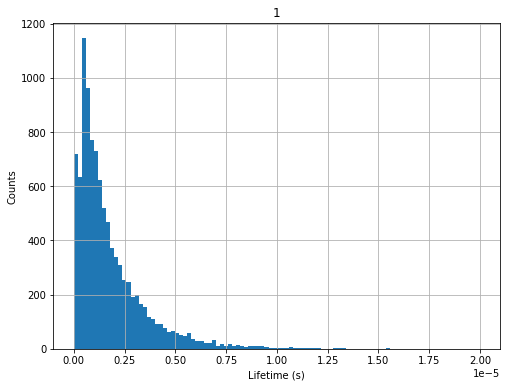

tau_avg = 2.0177369798232277e-06 ± 0.0028567079206683155
    >Err 0.194587130078208 
- - - - -
tau_pos = 2.0177369798232277e-06 ± 0.0028567079206683155
    >Err 0.08158655537672685
tau_neg = 2.0177224719354306e-06 ± 0.002859225475610708
    >Err 0.9401177614763756


Generating muons:   0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:206: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:261: RuntimeWarning: invalid value encountered in sqrt


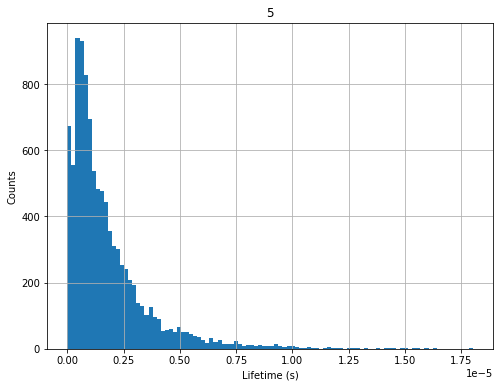

tau_avg = 2.0044944127457122e-06 ± 0.01158540448727864
    >Err 0.18674696044351988 
- - - - -
tau_pos = 2.0044944127457122e-06 ± 0.01158540448727864
    >Err 0.08761417531279068
tau_neg = 2.0044769110894473e-06 ± 0.010094558978161335
    >Err 0.9273816452783148


Generating muons:   0%|          | 0/10000 [00:00<?, ?it/s]

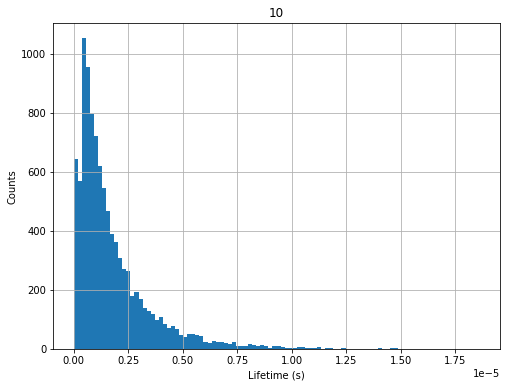

tau_avg = 2.0123840247567503e-06 ± 0.0047921081323482745
    >Err 0.1914179503019316 
- - - - -
tau_pos = 2.0123840247567503e-06 ± 0.0047921081323482745
    >Err 0.08402306020896112
tau_neg = 2.01234827574175e-06 ± 0.0023217371958010056
    >Err 0.9349502651362979


Generating muons:   0%|          | 0/10000 [00:00<?, ?it/s]

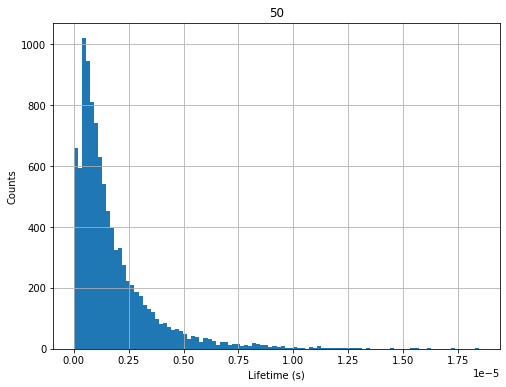

tau_avg = 1.9682139045053925e-06 ± 0.0008074590832565873
    >Err 0.16526733814885422 
- - - - -
tau_pos = 1.9682153762235455e-06 ± 0.000756548734887712
    >Err 0.10412730622782984
tau_neg = 1.9682139045053925e-06 ± 0.0008074590832565873
    >Err 0.8925133697167236


Generating muons:   0%|          | 0/10000 [00:00<?, ?it/s]

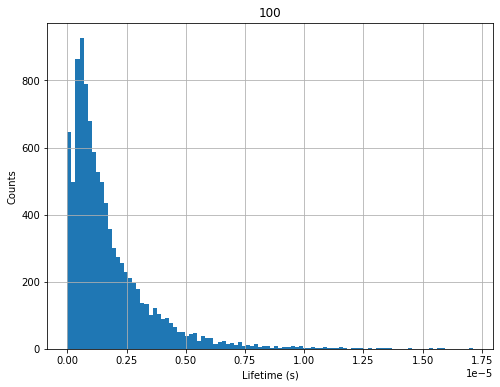

tau_avg = 2.0318683754665395e-06 ± 3.69204431516269
    >Err 0.20295352447666054 
- - - - -
tau_pos = 2.031868381663343e-06 ± 3.6920442985270197
    >Err 0.07515436447616992
tau_neg = 2.0318683754665395e-06 ± 3.69204431516269
    >Err 0.9537195917947495


Generating muons:   0%|          | 0/10000 [00:00<?, ?it/s]

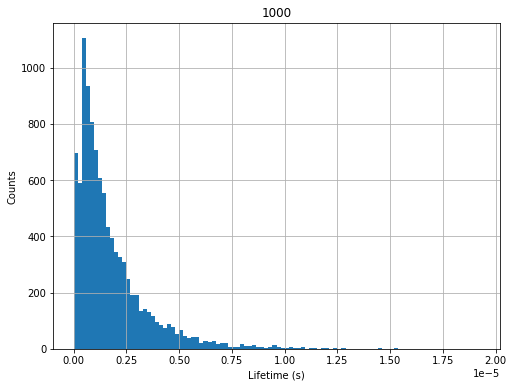

tau_avg = 2.00667075140897e-06 ± 1.4472717922286025
    >Err 0.1880354465959852 
- - - - -
tau_pos = 2.006671377488943e-06 ± 1.4472731951042137
    >Err 0.08662328615892823
tau_neg = 2.00667075140897e-06 ± 1.4472717922286025
    >Err 0.9294911071240096


In [ ]:
rates = [None, 1, 5, 10, 50, 100, 1000]

for r in rates:
    d = detector() 
    p = muon_plane(d.height + 0.5, 50,E_min = 1,E_max=1000)

    s = system(d, p)

    s.simulate(10000, scint_time_steps = 1000, noise_rates = r,
               n_pre_gen = 10000) # generate 5000 events
    ms = s.obtain_metrics(bins = 1000)
    
    s.plot_result(title = str(r))
    
    print('tau_avg =',ms['lifetime avg'],'±',ms['uncert avg'])
    print('    >Err',ms['rel avg'],'\n- - - - -')
    print('tau_pos =',ms['lifetime +'],'±',ms['uncert +'])
    print('    >Err',ms['rel mu+'])
    print('tau_neg =',ms['lifetime -'],'±',ms['uncert -'])
    print('    >Err',ms['rel mu-'])

In [ ]:
a = [1,2,3, 3.00000000006]
i = max(a)
np.where(np.array(a) == i)[0][0]

3

In [ ]:
1/(4.86356559e+05)

2.056104685945029e-06

1


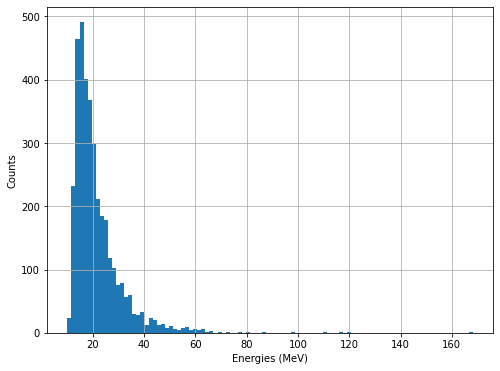

In [ ]:
syst.plot_result(plot_type = 'energies')

1


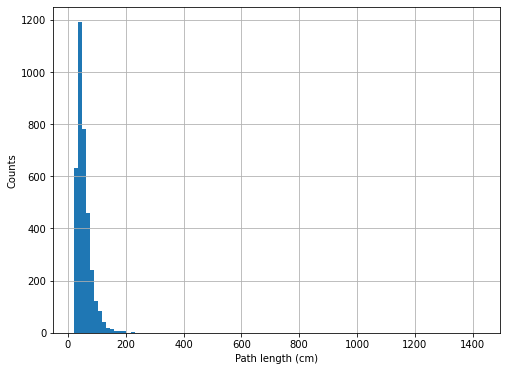

In [ ]:
syst.plot_result(plot_type = 'path_len')

### 4.2 - Testing ```system.test_var()```

In [ ]:
# testing timeout
# default value = 2e-05
timeouts = [2e-05, 3e-05, 4e-05, 5e-05]

test = test_var(var='timeout',values = timeouts)

Running simulations:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:240: RuntimeWarning: invalid value encountered in sqrt


In [ ]:
# quick inspection of results
for i in test:
    print(i)

{'proportion': 1.0, 'lifetime avg': 1.4347768336006522e-06, 'lifetime -': 1.5977590318413997e-06, 'lifetime +': 1.2304466978500537e-08, 'abs avg': 2.542895634993477e-07, 'rel avg': 0.15055036553681003, 'abs mu-': 5.577590318413997e-07, 'rel mu-': 0.5363067613859612, 'abs mu+': 2.1846766330214992e-06, 'rel mu+': 0.9943993751341326}
{'proportion': 1.0, 'lifetime avg': 1.445791121132283e-06, 'lifetime -': 1.6003794711188206e-06, 'lifetime +': 2.0036731594451637e-07, 'abs avg': 2.43275275967717e-07, 'rel avg': 0.14402943329249954, 'abs mu-': 5.603794711188206e-07, 'rel mu-': 0.5388264145373276, 'abs mu+': 1.9966137840554837e-06, 'rel mu+': 0.9087987985219735}
{'proportion': 1.0, 'lifetime avg': 1.2991810392942183e-06, 'lifetime -': 1.470284432505685e-06, 'lifetime +': 1.2491917844048003e-08, 'abs avg': 3.898853578057816e-07, 'rel avg': 0.23082891144787762, 'abs mu-': 4.30284432505685e-07, 'rel mu-': 0.41373503125546635, 'abs mu+': 2.184489182155952e-06, 'rel mu+': 0.9943140531140445}
{'pro